In [1]:
import re
from functools import reduce
from scipy.stats import hypergeom as hg
from scipy.optimize import curve_fit as cf
from scipy.cluster.vq import kmeans, kmeans2, whiten
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import networkx as nx

In [1]:
import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict

import numpy as np
from numpy import linalg as linalg


import os
from importlib import reload

import myfun as mf

# setup matplotlib latex use
#matplotlib.use('agg')
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'


matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
import xenbase_dict_gen as XDG
xdg = XDG.XenbaseDictGen()

In [4]:
# reload(XDG)
# xdg = XDG.XenbaseDictGen()

In [5]:
pgls     = [i[1] for i in list(xdg.xao_graph.out_edges('primary germ layer'))] + ['neuroectoderm']
tcols = [plt.cm.tab10.colors[i] for i in [0,1,2,7,5,8]]
pglCols  = dict(zip(pgls,tcols[0:len(pgls)]))
pglCols['non-derm'] = 'black'

def getDerm(word):
    derm = 'non-derm'
    if word in xdg.xao_graph_dat:
        try:
            derm = xdg.xao_shortest_path(word, 'primary germ layer')[-1][0]
        except nx.NetworkXNoPath:
            derm = 'non-derm'
    return derm


def getDerm2(word):
    derm = 'non-derm'
    if word in xdg.xao_graph_dat:
        try:
            path = xdg.xao_shortest_path(word, 'neuroectoderm')
            derm = 'neuroectoderm' #[-1][-1]
        except nx.NetworkXNoPath:
            derm = getDerm(word)
    return derm

def dermcf(word, font_size, position, orientation, random_state=None,**kwargs):
    return matplotlib.colors.to_hex(pglCols[getDerm2(word)])

# generic function to get len of list in dict where values are lists
dictCts = lambda d: {k:len(v) for k,v in d.items()}

In [6]:
def venn4b(g1,g2,g3,g4):
    # not the real 4 venn diagram
    # groups of interest, in binary rep (1=includes, 0=excludes, X=not exclusive of)
    # 100X, 01X0, 0X10, X001
    # 1111
    # 1100, 1010, 0011, 0101 # exclusive of 1111
    s1 = g1 - (g2|g3)
    s2 = g2 - (g1|g4)
    s3 = g3 - (g1|g4)
    s4 = g4 - (g2|g3)
    s5 = g1&g2&g3&g4
    s6 = g1&g2 - s5
    s7 = g1&g3 - s5
    s8 = g3&g4 - s5
    s9 = g2&g4 - s5
    
    # ordering like a square matrix, RowColumn = [00,01,02,11,...22]
    return [s1, s6, s2, 
            s7, s5, s9,
            s3, s8, s4]

def venn4bDict(d1,d2,d3,d4,cf = np.mean):
    # not the real 4 venn diagram
    # groups of interest, in binary rep (1=includes, 0=excludes, X=not exclusive of)
    # 100X, 01X0, 0X10, X001
    # 1111
    # 1100, 1010, 0011, 0101 # exclusive of 1111
    
    keys = venn4b(d1.keys(),d2.keys(),d3.keys(),d4.keys())
    ds = [
        {k:d1[k] for k in keys[0]},             {k:cf([d1[k],d2[k]]) for k in keys[1]},             {k:d2[k] for k in keys[2]},
        {k:cf([d1[k],d3[k]]) for k in keys[3]}, {k:cf([d1[k],d2[k],d3[k],d4[k]]) for k in keys[4]}, {k:cf([d2[k],d4[k]]) for k in keys[5]},
        {k:d3[k] for k in keys[6]},             {k:cf([d3[k],d4[k]]) for k in keys[7]},             {k:d4[k] for k in keys[8]}
    ]
    return ds

In [7]:
import kegg_dict_gen as KDG
kdg = KDG.KeggDictGen()

In [10]:
# reload(KDG)
# kdg = KDG.KeggDictGen()

In [8]:
lowIdxs = lambda x,p : np.where((np.isreal(x)) & (x<p))[0]
hiIdxs  = lambda x,p : np.where((np.isreal(x)) & (x>p))[0]
rmsl = lambda gnm : re.sub(r'.[lsLS]$','',gnm)
numvals = lambda d: {k:len(v) for k, v in d.items()}
trimPway = lambda x: x.replace(' signaling','').replace(' pathway','').replace(' system','').replace(' in diabetic complications',' (diabetic)')


# directories 
datdir  = '/Users/simonfreedman/cqub/xenopus/data'
plotdir = '/Users/simonfreedman/cqub/xenopus/plots'

stagestrs = ['9','10','10.5','11','12','13']

In [9]:
gnmsS = np.load('{0}/deGeneNames.npy'.format(datdir))
ngenes = gnmsS.shape[0]

In [10]:
numregex = r'\d+'
def longest_elem(l):
    if len(l) == 0:
        return '-1'
    else:
        longest = l[0]
        for i in range(1,len(l)):
            if len(l[i]) > len(longest):
                longest = l[i]
        return longest

# revisions were only done
# reviseFnm = '{0}/xenla_9-2_geneinfo.tsv'.format(datdir)
# revs = np.genfromtxt(reviseFnm, names=True, dtype=None, delimiter='\t', encoding=None)
# fixnm = lambda x: x.split('[')[0]
# revdict = {row[3]:fixnm(row[1]) for row in revs if len(row)>3}
gnums = [longest_elem(re.findall(numregex, gnm)) for gnm in gnmsS]

gnumlens             = np.array(list(map(lambda x : len(x) if type(x) is str else 1,gnums)))
unannotatedIdxs      = np.where(gnumlens > 4)[0]
unannotatedPrefaces  = np.array([re.split(numregex,gnmsS[i])[0] for i in unannotatedIdxs])
allPrefaces          = np.array([re.split(numregex,gnm)[0] for gnm in gnmsS])
np.setdiff1d(np.where(allPrefaces == 'xetrov')[0],unannotatedIdxs)

array([], dtype=int64)

In [11]:
# gene 2 state stuff
stages          = [9,10,10.5,11,12,13]

gene2state = xdg.gene2stateByInt(9,13, require_whole_interval = False, include_unspecified = True)

gene2stateByStg = [xdg.gene2stateByInt(i,i, require_whole_interval = False) for i in stages]

gene2stateEarly = xdg.gene2stateByInt(9,10.5, require_whole_interval = False)
gene2stateLate  = xdg.gene2stateByInt(10.5,13, require_whole_interval = False)

nullCts = {}
for gnm in gnmsS:
    for st in gene2state.get(gnm,[]):
        nullCts[st] = nullCts.get(st,0)+1

In [12]:
gcts = np.load('{0}/deGeneCounts.npy'.format(datdir))
gctsF   = gcts.reshape(-1,gcts.shape[-1])
gctsMu  = np.mean(gcts,axis=1).reshape(-1,gcts.shape[-1])
gctsMu2 = np.vstack([np.mean(gcts[0,1:],axis=0).reshape(-1,gcts.shape[-1]),
                     np.mean(gcts[1],axis=0).reshape(-1,gcts.shape[-1])])

In [13]:
gcts.shape

(3, 3, 6, 45660)

In [14]:
gtpm    = (10**6*gcts.transpose((3,0,1,2)) / gcts.sum(axis=3)).transpose((1,2,3,0))
gtpmMu  = np.mean(gtpm,axis=1).reshape(-1,gtpm.shape[-1])

gtpmMuS = np.mean(gtpm,axis=1)
gtpmT = gtpm.transpose((1,0,2,3))
errs = gtpmT-gtpmMuS
uperrs = np.max(errs,axis=0)
loerrs = np.abs(np.min(errs,axis=0))
loUpErrs = np.array([loerrs,uperrs])

gtpmf = gtpm.reshape((54,-1))

In [15]:
rownames = ['gene name'] + ['{0}_rep{1}_stage{2}'.format(c,r,stg) 
                            for c in ['epidermal', 'neural', 'endodermal'] 
                            for r in [1,2,3] for stg in stagestrs]

np.savetxt('{0}/animal_cap_counts.csv'.format(datdir),np.vstack([gnmsS,gctsF]).T,
           header=','.join(rownames),fmt='%s',delimiter=',')
np.savetxt('{0}/animal_cap_rpm.csv'.format(datdir),np.vstack([gnmsS,gtpmf]).T,
           header=','.join(rownames),fmt='%s',delimiter=',')

In [17]:
#sigidxs  = [i for i in range(gnmsS.shape[0]) if 'signal' in ','.join(kdg.gene2pway.get(gnmsS[i].lower(),[]))]
gene2sig = {}
for k,vs in kdg.gene2pway.items():
    for v in vs:
        if 'signal' in v:
            gene2sig[k] = gene2sig.get(k,[]) + [v]
            
nullPwayCts = {}
for gnm in gnmsS:
    for pway in gene2sig.get(gnm.lower(),[]):
        nullPwayCts[pway] = nullPwayCts.get(pway,0)+1

In [18]:
sigs = [i for i in kdg.pway2cat.keys() if 'signal' in i]
sigidxsnull = {}
for idx in range(gnmsS.shape[0]):
    gnm   = gnmsS[idx].lower()
    pways = kdg.gene2pway.get(gnm,[])
    mutual_sigs = np.intersect1d(pways,sigs)
    for i in mutual_sigs:
        sigidxsnull[i] = sigidxsnull.get(i,[])+[idx]

idx2sig=mf.reverseDictList(sigidxsnull)

def siglists(gidxs):
    nd1 = {}
    nd2 = {}
    for i in gidxs:
        for k in idx2sig.get(i,[]):
            nd1[k] = nd1.get(k,[]) + [i]
            nd2[k] = nd2.get(k,0)+1
            
    return (nd1,nd2)

In [19]:
# transcription factors from "gene function" field on Xenbase
tfstr = 'transcription factor'
tfdict = {}
gnmsRL = np.array(list(map(lambda x:rmsl(x.lower()),gnmsS)))

for i in range(ngenes):
    funcs = xdg.gene2func.get(rmsl(gnmsS[i]),[])
    for func in funcs:
        if tfstr in func:
            tfdict[func] = tfdict.get(func,[]) + [i]

tfdictcts = numvals(tfdict)
tfidxs    = set(mf.flatten2d(tfdict.values()))

In [20]:
# transcription factors based on "GO terms" from Xenabse
gotf1 = 'GO:0003700' # DNA Binding transcription factor activity
#gotf = 'GO:0140110' # Transcription regulator activity
#gotf = 'GO:0010468' # regulation of gene expression
#gotf2 = 'GO:0003677' # DNA Binding


# Getting transcription factors from GO terms
# construct the "is a GO" graph to capture children of the primary GO terms(s)
isago_graph  = nx.DiGraph()

for node in xdg.go_graph:
    go = node[0]
    isaGos  = node[1].get('is_a',[])

    isago_graph.add_node(go)

    for isa in isaGos:

        isago_graph.add_edge(go,isa)

# travers through this graph to find the children of the primary go term(s)

tfgos = set()
for node in xdg.go_graph:
    path = []
    try:
        path = nx.shortest_path(isago_graph,node[0],gotf1)
    except nx.NetworkXException: #$NoPath:
#         try:
#             path = nx.shortest_path(isago_graph,node[0],gotf2)
#         except nx.NetworkXException: #$NoPath:
#             path = []
        pass
    if len(path) > 0:
        tfgos.add(node[0])

# loop through the xdg.gene2go dict to find genes that have at least one of the transcription factor GO terms
# found through the graph traversal
tfs3 = [idx for idx in range(gnmsS.shape[0]) if len(tfgos.intersection(set(xdg.gene2go.get(rmsl(gnmsS[idx]),[]))))>0]
tfidxsA = np.union1d(list(tfidxs),tfs3) #np.array(list(tfidxs))
tfidxsS = set(tfidxsA)

In [21]:
# get a null for the number of genes per kegg pathway and transcription factors
# keggs = list(kdg.pway2cat.keys())
keggidxsnull      = {}
tfstr    = ' TF'
nontfstr = ' non TF'

for idx in range(gnmsS.shape[0]):
    gnm   = gnmsS[idx].lower()
    keggs = kdg.gene2pway.get(gnm,[])
    isTF  = idx in tfidxsS
    for i in keggs:
        keggidxsnull[i] = keggidxsnull.get(i,[])+[idx]
        i2 = i + tfstr if isTF else i + nontfstr
        keggidxsnull[i2]    = keggidxsnull.get(i2,[])+[idx]

keggidxsnull['transcription factors']      = tfidxsA
        
idx2kegg    = mf.reverseDictList(keggidxsnull)
nullKeggCts = dictCts(keggidxsnull)

# function to retrieve lists genes per kegg pathway for a given a list of genes
# differs from "siglists" because includes all kegg pathways, not just signalling pathways
def kegglists(gidxs):
    nd1 = {k:[] for k in nullKeggCts}
    nd2 = {k:0 for k in nullKeggCts}
    
    for i in gidxs:
        for k in idx2kegg.get(i,[]):
            nd1[k].append(i)
            nd2[k]+=1
            
    return (nd1,nd2)

In [22]:
#sig        = 'MAPK signaling pathway'

def keggCosThs(sig,grpidx):
    keyIdxs    = [keggIdxs[i].get(sig,[]) for i in range(ngrp)]
    degenes    = np.array(keyIdxs[grpidx])

    return cosThs(degenes) 

def cosThs(degenes):

    epidDat = gtpmMu[:6, degenes]
    epidDatN = epidDat / linalg.norm(epidDat,axis=0)

    neurDat  = gtpmMu[6:, degenes]
    neurDatN = neurDat / linalg.norm(neurDat,axis=0)
    return np.sum(epidDatN*neurDatN,axis=0) 


In [23]:
# function that given a list of indexes and a pathway group label will output the hypergeometric pvalue
def hgpv(idxs, pway_key, ng = ngenes):
    overlapLen = np.intersect1d(idxs, np.array(keggidxsnull[pway_key])).shape[0]
    pv = 1 - hg.cdf(overlapLen-1, ng, len(keggidxsnull[pway_key]), len(idxs))
    return pv

#previous version of the function
def hgpv_wrong(idxs, pway_key, ng = ngenes):
    overlapLen = np.intersect1d(idxs, np.array(keggidxsnull[pway_key])).shape[0]
    pv = 1 - hg.cdf(overlapLen, ng, len(keggidxsnull[pway_key]), len(idxs))
    return pv

In [24]:
# deEpid = [np.load('{0}/deseq_epid_{1}-{2}.npy'.format(datdir,stagestrs[i],stagestrs[i+1])) 
#           for i in range(len(stagestrs)-1)]
# deNeur = [np.load('{0}/deseq_neur_{1}-{2}.npy'.format(datdir,stagestrs[i],stagestrs[i+1])) 
#           for i in range(len(stagestrs)-1)]
# deNE = [np.load('{0}/deseq_epid_v_neur{1}.npy'.format(datdir,stagestrs[i])) 
#           for i in range(len(stagestrs))]set

In [25]:
# neurpvs = np.vstack([deNeur[i][5] for i in range(len(deNeur))])
# epidpvs = np.vstack([deEpid[i][5] for i in range(len(deEpid))])
# nepvs   = np.vstack([deNE[i][5] for i in range(len(deNE))])

In [26]:
# # tangent to compare replicates...
# deEpid2r = [[np.load('{0}/deseq_epid_reps{3}_{1}-{2}.npy'.format(datdir,stagestrs[i],stagestrs[i+1],repstr)) 
#              for i in range(len(stagestrs)-1)] for repstr in ['12','13','23']]
# deNeur2r = [[np.load('{0}/deseq_neur_reps{3}_{1}-{2}.npy'.format(datdir,stagestrs[i],stagestrs[i+1],repstr)) 
#              for i in range(len(stagestrs)-1)] for repstr in ['12','13','23']]

# neurpvs2r = np.array([np.vstack([deNeur2r[i][j][5] for j in range(len(deNeur2r[i]))]) for i in range(len(deNeur2r))])
# epidpvs2r = np.array([np.vstack([deEpid2r[i][j][5] for j in range(len(deEpid2r[i]))]) for i in range(len(deEpid2r))])

# lowPVneur2r = np.array([[lowpvalidxs(neurpvs2r[i,j],thresh) for j in range(neurpvs2r.shape[1])] 
#                for i in range(neurpvs2r.shape[0])])
# lowPVepid2r = np.array([[lowpvalidxs(epidpvs2r[i,j],thresh) for j in range(epidpvs2r.shape[1])] 
#                for i in range(epidpvs2r.shape[0])])

In [27]:
loadDE = lambda c1,c2,t1,t2,cols: np.genfromtxt('{0}/deseq_out/{1}_{2}_v_{3}_{4}.tsv'.format(datdir,c1,t1,c2,t2),
                                                dtype='float',delimiter='\t',encoding=None,skip_header=1,usecols=cols)

stgs   = ['9','10','105','11','12','13']
conds  = np.array(['epid','noggin','endo'])
tDEpvs = np.array([[loadDE(cond,cond,stgs[i],stgs[i+1],6) for i in range(5)] 
                   for cond in conds])

condVs = [('epid','noggin'),('epid','endo'),('endo','noggin')]
cDEpvs = np.array([[loadDE(condV[0],condV[1],stg,stg,6) for stg in stgs] 
                   for condV in condVs])

condVs = [('epid','noggin'),('epid','endo'),('noggin','endo')]
ctDEpvs = np.array([loadDE(condV[0],condV[1],'all','all',6) for condV in condVs])

In [28]:
# set all nan slices to high p-values
# find idxs where the whole slice is nan
# for those slices, replace with pvalues = 1
f                     = np.nanmin(cDEpvs,axis=1)
allnanIdxI,allnanIdxJ = np.where(np.isnan(f))
cDEpvs2               = np.copy(cDEpvs)
cDEpvs2[allnanIdxI,:,allnanIdxJ] = 1

# do the same thing for tDEpvs
f                     = np.nanmin(tDEpvs,axis=1)
allnanIdxI,allnanIdxJ = np.where(np.isnan(f))
tDEpvs2               = np.copy(tDEpvs)
tDEpvs2[allnanIdxI,:,allnanIdxJ] = 1

# do the same thing for ctDEpvs
f          = np.nanmin(ctDEpvs,axis=0)
allnanIdxI = np.where(np.isnan(f))
ctDEpvs2   = np.copy(ctDEpvs)
ctDEpvs2[:,allnanIdxI] = 1

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()


In [42]:
gtpmMu.shape
len(gnmsS[keggidxsnull['MAPK signaling pathway']])

466

In [115]:
pv_thresh       = 0.1
tDE_idxs        = [[np.where(tDEpvs2[i,t] < pv_thresh)[0] for t in range(5)] for i in range(2)]

In [116]:
len(tDE_idxs)

2

In [133]:
len(gnmsS[keggidxsnull['TGF-beta + BMP signaling pathway TF']])

37

In [136]:
sig = 'TGF-beta + BMP signaling pathway'
pway_idxs       = np.array(keggidxsnull[sig])


ngenes_per_plot = 50
gsort           = np.argsort(gnmsS[pway_idxs])
pway_idxs_srtd  = pway_idxs[gsort]

pmax            = np.amax(gtpmMu[0:12,pway_idxs])
sigT = trimPway(sig).replace(' ','_')

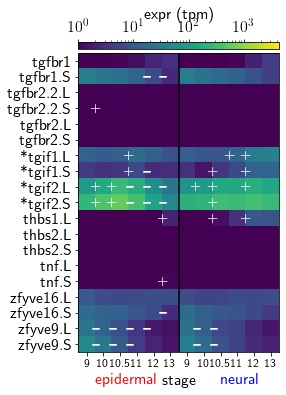

In [141]:

# setup: which genes
ii = 3
ngns = 50
gidxs           = pway_idxs_srtd[(ii*ngns):np.amin(((ii+1)*ngns, len(pway_idxs_srtd)))]
gidx_idx        = dict(zip(gidxs,np.arange(len(gidxs))))
de_pway_idxs    = [[np.intersect1d(gidxs, tDE_idxs[i][t]) for t in range(5)] for i in range(2)]


# add asterisk to TFs
tf_gidxs        = np.intersect1d(gidxs, keggidxsnull[sig+' TF'])
rnames          = gnmsS[gidxs]
for g in tf_gidxs:
    rnames[gidx_idx[g]] = '*'+rnames[gidx_idx[g]]


#plotting
fac             = 0.3
fig,axs = plt.subplots(1,1,figsize=(12*fac,len(gidxs)*fac))
datS    = gtpmMu[0:12,gidxs].T+0.005

im      = axs.imshow(datS,aspect='auto',norm=matplotlib.colors.LogNorm(),vmin=1,vmax=pmax)
axs.vlines(x=5.5,ymin=-0.5,ymax=len(gidxs)-0.5)

for i in range(len(de_pway_idxs)):
    for j in range(len(de_pway_idxs[i])):
        cidx = j if i == 0 else 6+j
        for k in range(de_pway_idxs[i][j].shape[0]):
            gidx = de_pway_idxs[i][j][k]
            ridx = gidx_idx[gidx]
            if gtpmMu[cidx,gidx] < gtpmMu[cidx+1,gidx]:
                axs.text(s=r'$\boldsymbol{+}$',x=cidx+0.18,y=ridx+0.25,color='white',size=13)#for jpg export
                #axs.text(s=r'$\boldsymbol{+}$',x=cidx+0.25,y=ridx+0.2,color='white',size=13) #for pdf export
            else:
                axs.text(s='-',x=cidx+0.35,y=ridx+0.1,color='white',size='30') #for jpg export
                #axs.text(s='-',x=cidx+0.35,y=ridx+0.45,color='white',size='30') #for pdf export
    
axs.set_yticks(np.arange(0,len(gidxs)))
axs.set_yticklabels(rnames)
axs.set_ylim(len(gidxs)-0.5,-0.5)


axs.set_xticks(range(len(stages)*2))
axs.set_xlabel('stage')

divider = make_axes_locatable(axs)
cax2     = divider.append_axes("top", size=0.1, pad=0.05)

cbar = fig.colorbar(im, cax=cax2,orientation='horizontal')
cbar.set_label('expr (tpm)',rotation=0, labelpad=2)
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_ticks_position('top')

axs.text(s='epidermal',y=len(gidxs)+1.5,x=0.5,color='red',size=16)
axs.text(s='neural',y=len(gidxs)+1.5,x=8,color='blue',size=16)


mf.set_axs_fontsize(axs,16)
mf.set_axs_fontsize(cax2,16)
axs.set_xticklabels(stagestrs*2,fontsize=12)

plt.savefig('{0}/pway_gexp_{1}_n{2}.jpg'.format(plotdir,sigT,ii),bbox_inches="tight")

Text(0.5, 1.0, 'cacng4.L')

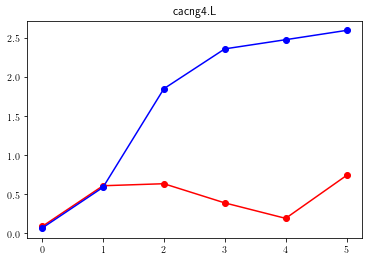

In [121]:
fig,axs=plt.subplots()
k=gidxs[6]
axs.plot(gtpmMu[0:6,k],'ro-')
axs.plot(gtpmMu[6:12,k],'bo-')
axs.set_title(gnmsS[k])
                

In [122]:
np.set_printoptions(precision=3)
tDEpvs2[:,:,k]

array([[0.009, 0.937, 0.753,   nan, 0.067],
       [0.021, 0.139, 0.97 , 0.943, 0.989],
       [0.001, 0.693, 0.285, 0.051, 0.224]])

In [114]:
tDEpvs2.shape

(3, 5, 45660)

In [30]:
tDEpvs.shape,cDEpvs.shape

((3, 5, 45660), (3, 6, 45660))

In [34]:
thresh    = 0.1
lowPVsamp = [[lowpvalidxs(tDEpvs[i,j],thresh) for j in range(len(stgs)-1)] for i in range(tDEpvs.shape[0])]

NameError: name 'lowpvalidxs' is not defined

In [73]:
nloPV = np.array([[len(lowPVsamp[i][j]) 
                   for j in range(len(stgs)-1)] for i in range(len(samps))])

In [74]:
nloPV

array([[5081, 4329, 2384, 4680, 4997],
       [4669, 4149,  534, 1600,  320],
       [4936, 7172, 6674, 6495, 6328]])

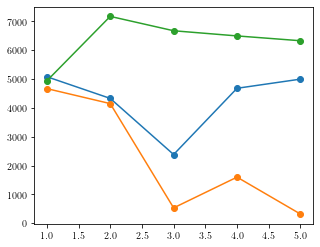

In [75]:
fig,axs=plt.subplots(figsize=(5,4))
for i in range(3):
    axs.plot(range(1,6),nloPV[i],'o-')

In [32]:
thresh = 0.1
lowPVneur = [lowpvalidxs(neurpvs[i],thresh) for i in range(len(stagestrs)-1)]
lowPVepid = [lowpvalidxs(epidpvs[i],thresh) for i in range(len(stagestrs)-1)]
lowPVne   = [lowpvalidxs(nepvs[i],thresh) for i in range(len(stagestrs))]

NameError: name 'lowpvalidxs' is not defined

In [37]:
deGenesEpidEarly = np.union1d(lowPVepid[0],lowPVepid[1]) # np.union1d(lowPVepid2r[2,0],lowPVepid2r[2,1]) #
deGenesNeurEarly = np.union1d(lowPVneur[0],lowPVneur[1])

deGenesEpidLate = reduce(np.union1d,[deg for deg in lowPVepid[2:]]) #reduce(np.union1d,[deg for deg in lowPVepid2r[2,2:]]) #
deGenesNeurLate = reduce(np.union1d,[deg for deg in lowPVneur[2:]])

# joint treatment:
# (a) epidermal and neural, early but not late -- should look at joint PCA and individual PCAs
# (b) epidermal but not neural, early but not late -- only epidermal PCA (+ neural projection, maybe)
# (c) neural but not epidermal, early but not late -- only neural PCA (+ epidermal projection, maybe)
# (d) epidermal and neural, late but not early -- joint + individual PCAs
# (e) epidermal but not neural, late but not early -- only epidermal PCA (+ neural projection, maybe)
# (f) neural but not epidermal, late but not early -- only neural PCA (+ epidermal projection, maybe)
# (g) epidermal and neural, early and late -- joint and individual PCAs
# (h) epidermal but not neural, early and late -- only epidermal PCA (+ neural projection, maybe)
# (i) neural but not epidermal, early and late -- only neural PCA (+ epidermal projection, maybe)

idxsA = np.setdiff1d(np.intersect1d(deGenesEpidEarly, deGenesNeurEarly), np.union1d(deGenesEpidLate, deGenesNeurLate))
idxsB = np.setdiff1d(deGenesEpidEarly, reduce(np.union1d,[deGenesEpidLate,deGenesNeurEarly,deGenesNeurLate]))
idxsC = np.setdiff1d(deGenesNeurEarly, reduce(np.union1d,[deGenesNeurLate,deGenesEpidEarly,deGenesEpidLate]))

idxsD = np.setdiff1d(np.intersect1d(deGenesEpidLate, deGenesNeurLate), np.union1d(deGenesEpidEarly, deGenesNeurEarly))
idxsE = np.setdiff1d(deGenesEpidLate, reduce(np.union1d,[deGenesEpidEarly, deGenesNeurEarly, deGenesNeurLate]))
idxsF = np.setdiff1d(deGenesNeurLate, reduce(np.union1d,[deGenesNeurEarly,deGenesEpidEarly,deGenesEpidLate]))

idxsG = reduce(np.intersect1d,[deGenesEpidEarly,deGenesNeurEarly,deGenesEpidLate,deGenesNeurLate])
idxsH = np.setdiff1d(np.intersect1d(deGenesEpidEarly, deGenesEpidLate),np.union1d(deGenesNeurEarly,deGenesNeurLate))
idxsI = np.setdiff1d(np.intersect1d(deGenesNeurEarly, deGenesNeurLate),np.union1d(deGenesEpidEarly,deGenesEpidLate))

idxsDF = np.union1d(idxsD, idxsF)

jointIdxGroups = [idxsA, idxsB, idxsC, idxsD, idxsE, idxsF, idxsG, idxsH, idxsI, idxsDF]

In [38]:
idxGroups  = [deGenesNeurEarly, deGenesNeurLate, deGenesEpidEarly, deGenesEpidLate]
idxGroups9 = [np.array(list(y)) for y in venn4b(*[set(x) for x in idxGroups])] # this is more accurate than jointIdxGroups above

In [39]:
grps = idxGroups #jointIdxGroups
ngrp = len(grps)

state_cts    = [{} for i in range(ngrp)]
state_sig    = [{} for i in range(ngrp)]
state_tf_cts = [{} for i in range(ngrp)]
state_tf_sig = [{} for i in range(ngrp)]

pway_cts    = [{} for i in range(ngrp)]
pway_sig    = [{} for i in range(ngrp)]

tfs_by_grp   = [{} for i in range(ngrp)]

earlyInds = [0,1]
lateInds  = [2,3,4]

# neurIndc = [1,1,0]*3+[1]
# epidIndc = [1,0,1]*3+[0]
# earlyIndc = [1,1,1,0,0,0,1,1,1,0]
# lateIndc  = [0,0,0,1,1,1,1,1,1,1]

neurIndc  = [1,1,0,0]
epidIndc  = [0,0,1,1]
earlyIndc = [1,0,1,0]
lateIndc  = [0,1,0,1]


ngenesPerGrp = [grp.shape[0] for grp in grps]
totSigPerGrp = [0 for i in range(ngrp)]
for i in range(ngrp):
    idxs = grps[i]
   
    g2s  = gene2state
    
    if not lateIndc[i]:
        g2s = gene2stateEarly
    elif not earlyIndc[i]:
        g2s = gene2stateLate
        
    for idx in idxs:
        gnm = gnmsS[idx]
                
        nepv = -np.log10(np.nanmin(neurpvs[earlyInds,idx]))*neurIndc[i]*earlyIndc[i]
        nlpv = -np.log10(np.nanmin(neurpvs[lateInds,idx]))*neurIndc[i]*lateIndc[i]
        eepv = -np.log10(np.nanmin(epidpvs[earlyInds,idx]))*epidIndc[i]*earlyIndc[i]
        elpv = -np.log10(np.nanmin(epidpvs[lateInds,idx]))*epidIndc[i]*lateIndc[i]
        
        sig = 0
        norm = (neurIndc[i]+epidIndc[i])*(earlyIndc[i]+lateIndc[i])
        
        for pv in [nepv, nlpv, eepv, elpv]:
            if not np.isnan(pv) and pv > 0:
                sig += pv
        
        sig = sig/norm
        
        totSigPerGrp[i] += sig
        
        if idx in tfidxs and sig!=0:
            gnmr = rmsl(gnm)
            tfs_by_grp[i][gnmr] = tfs_by_grp[i].get(gnmr,0) + sig
        
        sts   = g2s.get(gnm,[])
        pways = gene2sig.get(gnm.lower(),[])
        
        for pway in pways:
            pway_cts[i][pway] = pway_cts[i].get(pway,0) + 1
            pway_sig[i][pway] = pway_sig[i].get(pway,0) + sig
        
        for st in sts:
            state_cts[i][st] = state_cts[i].get(st,0) + 1
            state_sig[i][st] = state_sig[i].get(st,0) + sig

#             if idx in tfidxs:
#                 state_tf_cts[i][gnm] = state_tf_cts[i].get(st,0) + 1
#                 state_tf_sig[i][gnm] = state_tf_sig[i].get(st,0) + sig 

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: All-NaN slice encountered
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: All-NaN slice encountered
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: All-NaN slice encountered
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log10
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: All-NaN slice encou

In [182]:
state_ct_pvs = [{} for i in range(ngrp)]
thresh2 = 0.0000001
threshB = thresh2 / len(nullCts)
for i in range(ngrp):
    for k,v in state_cts[i].items():
        pv = max(1-hg.cdf(v,ngenes,nullCts[k],ngenesPerGrp[i]),10**-12)
        if pv < threshB:
            state_ct_pvs[i][k] = -np.log10(pv)

In [183]:
pway_ct_pvs = [{} for i in range(ngrp)]
thresh2 = len(nullPwayCts)
threshB = thresh2 / len(nullPwayCts)

for i in range(ngrp):
    for k,v in pway_cts[i].items():
        pv = 1-hg.cdf(v,ngenes,nullPwayCts[k],ngenesPerGrp[i])
        if pv < threshB:
            pway_ct_pvs[i][trimPway(k)] = -np.log10(max(pv,10**-12))

In [184]:
pwayPVs9 = venn4bDict(*pway_ct_pvs)
statePVs9 = venn4bDict(*state_ct_pvs)

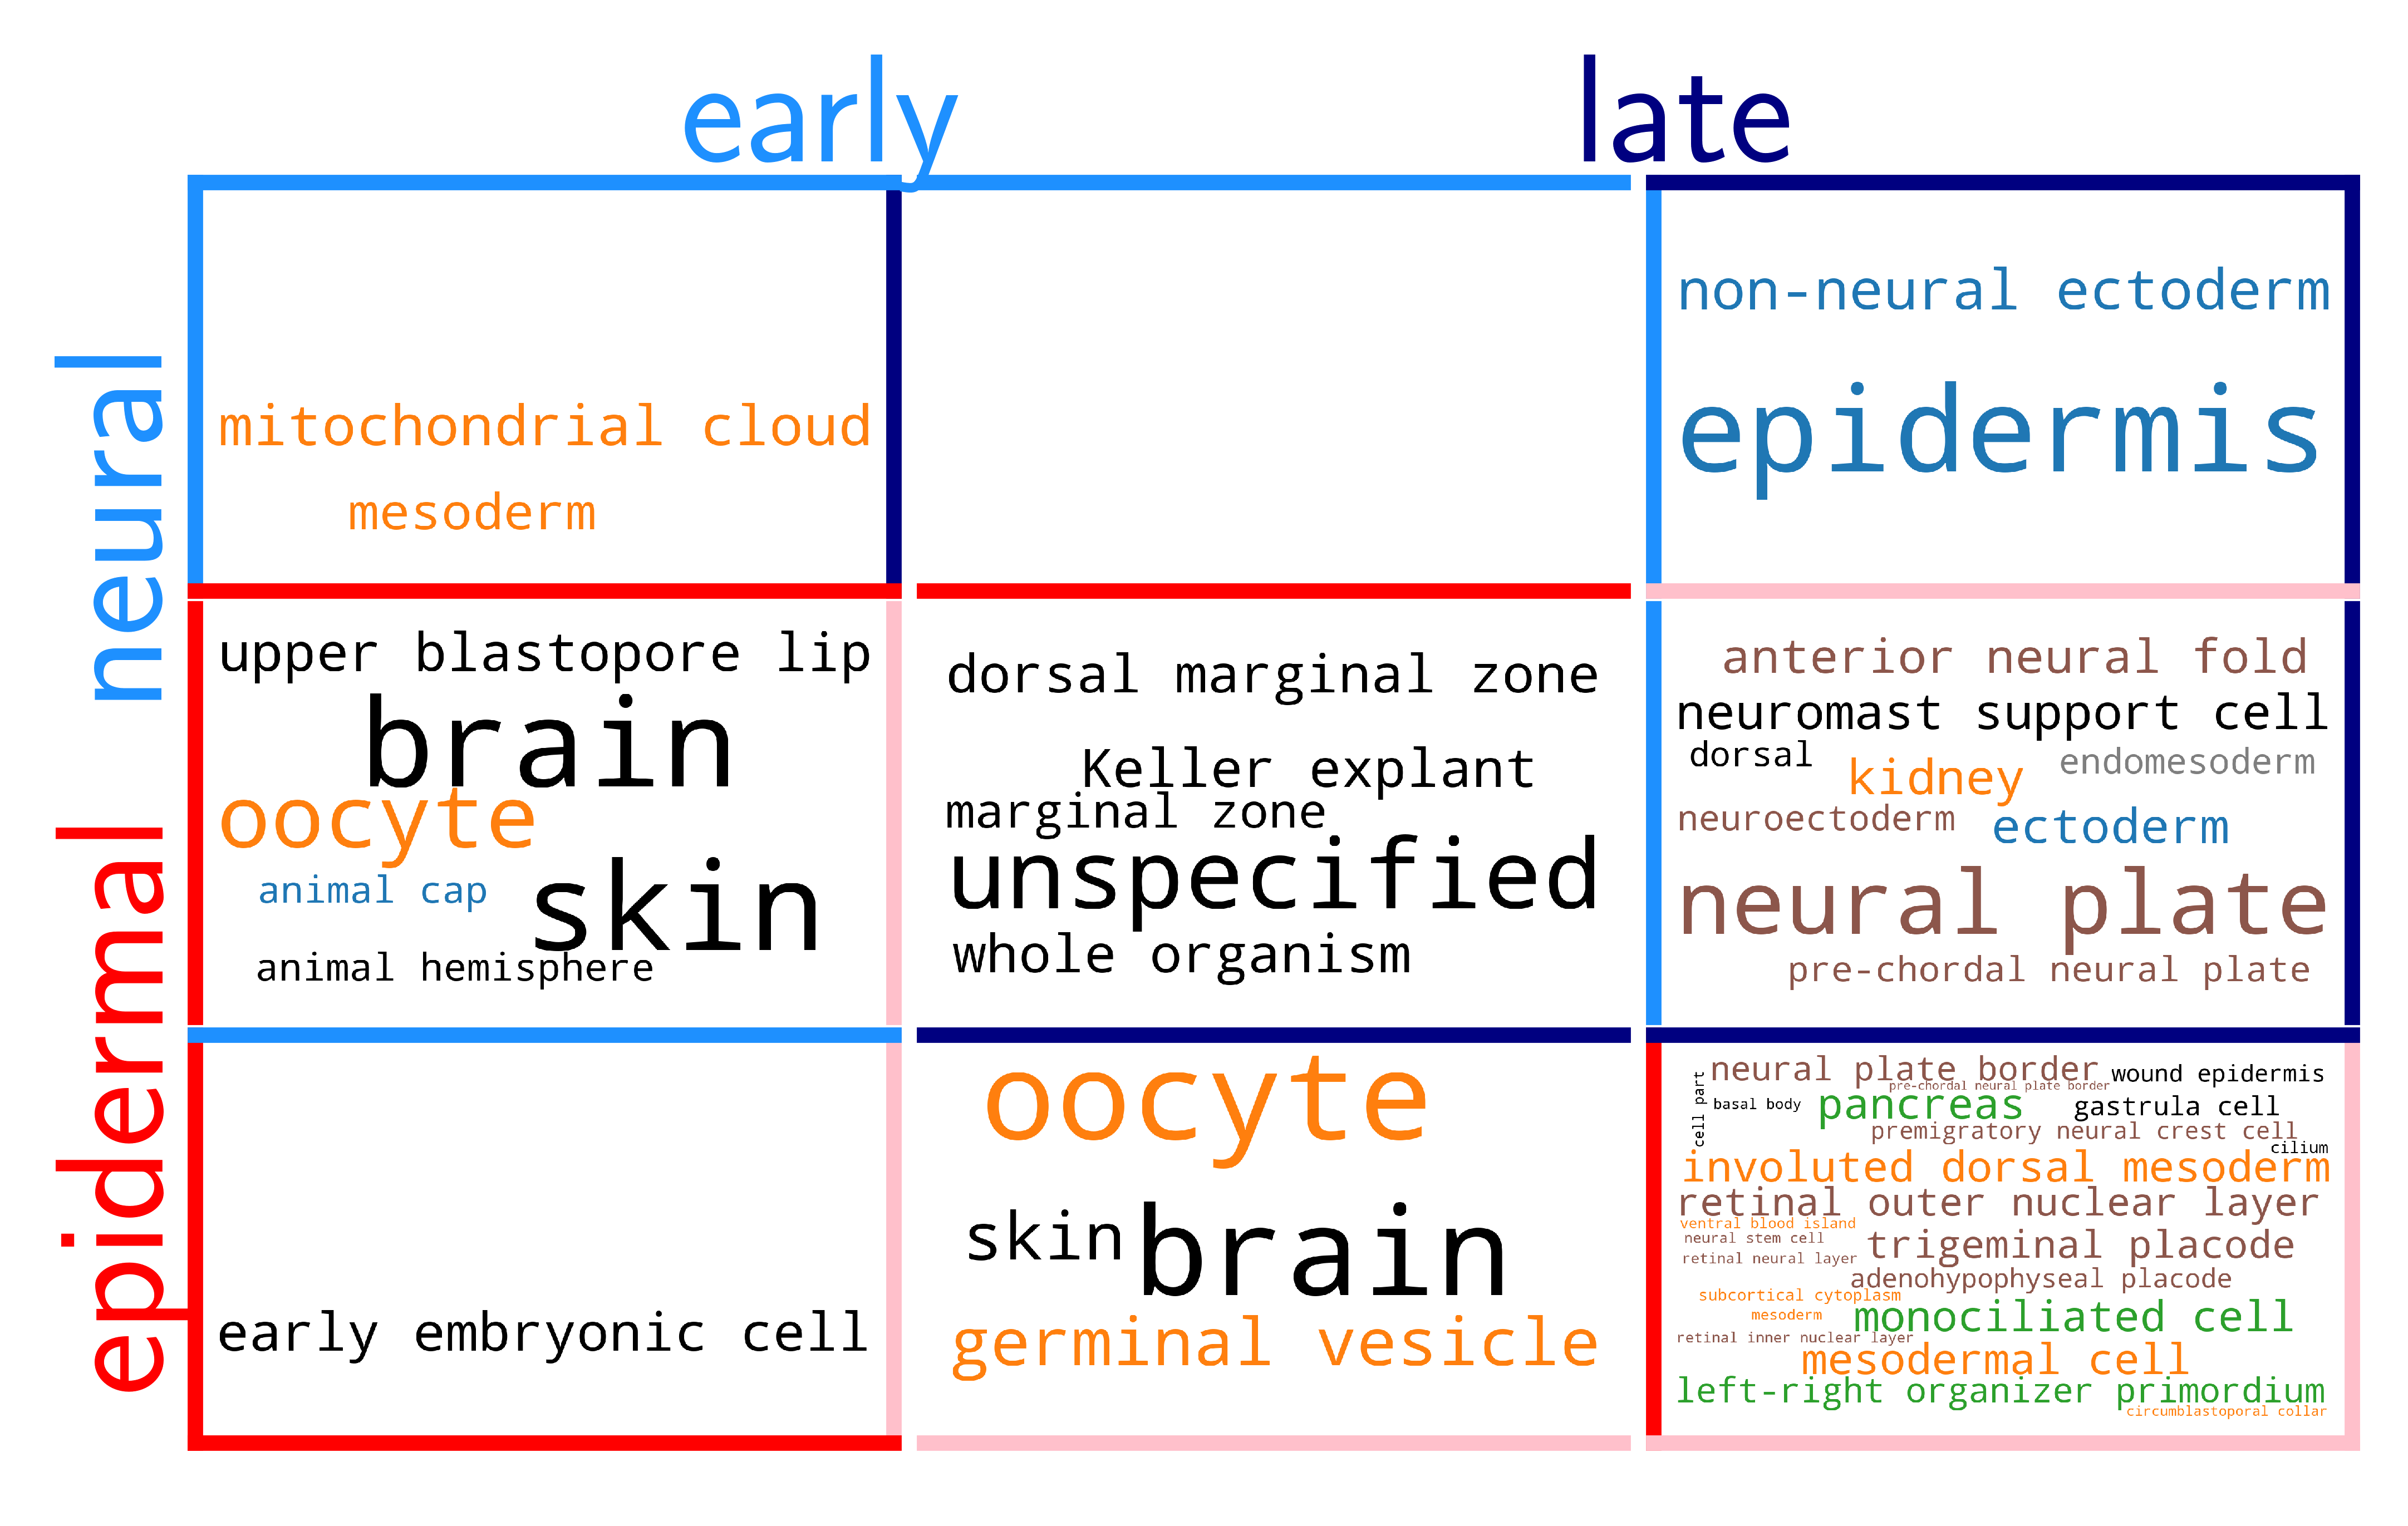

In [185]:
# data to use
freqs    = statePVs9 #pway_ct_pvs #tfs_by_grp #state_ct_pvs 

# word cloud venn diagram dimensions
fwd  = 5
fht  = 3
fdp  = 1000
mfs  = 300

fig = plt.figure(figsize=(fwd, fht), dpi=fdp) 

h1 = 4
h2 = 4
h3 = 4

w1 = 4
w2 = 4
w3 = 4

nr = h1+h2+h3
nc = w1+ w2 + w3
gs = gridspec.GridSpec(nr,nc)

hbnd = [0,h1,h1+h2,h1+h2+h3]
wbnd = [0,w1,w1+w2,w1+w2+w3]
axs = [plt.subplot(gs[hbnd[i]:hbnd[i+1],wbnd[j]:wbnd[j+1]]) for i in range(3) for j in range(3)]

cols = ['dodgerblue','navy', 'red','pink']
plt.setp(axs, xticks=[], yticks=[])

hfac = fht * fdp / nr
wfac = fwd * fdp / nc

axorder  = range(9) #[2,8,5,0,6,3,1,7,4]
wids     = [w1,w2,w3]*3
hts      = [h1]*3+[h2]*3+[h3]*3
margfrac = 0.1

mfss = [mfs]*9 #maxPVs/np.max(maxPVs)
#maxPVs = np.clip(np.array([max(freqs[i].values()) for i in range(0,ngrp)]),0,4)
#mfss = mfs*maxPVs/np.max(maxPVs)


axs[0].text(s='early',x=0.7,y=1.05,fontsize=20,transform=axs[0].transAxes,color=cols[0])  
axs[3].text(s='neural',x=-0.2,y=0.85,fontsize=20,transform=axs[3].transAxes,rotation=90,color=cols[0])     
axs[2].text(s='late',x=-0.1,y=1.05,fontsize=20,transform=axs[2].transAxes,color=cols[1])  
axs[6].text(s='epidermal',x=-0.2,y=0.2,fontsize=20,transform=axs[6].transAxes,rotation=90,color=cols[2])     



for i in range(9):
    if ( freqs[axorder[i]] ):
        
        wid = int(wids[i]*wfac)
        ht  = int(hts[i]*hfac)
        margw = 50#int(margfrac*wid)
        margh = 50#int(margfrac*ht)

        mask=np.zeros((ht, wid,4), dtype=int)
        mask[0:margh,:,:]=255
        mask[-margh:,:,:]=255
        mask[:,0:margw,:]=255
        mask[:,-margw:,:]=255
        
        axs[i].imshow(
            WordCloud(background_color="white", width=int(wids[i]*wfac), height=int(hts[i]*hfac), color_func=dermcf, 
                      max_font_size=mfss[axorder[i]], mask = mask).generate_from_frequencies(freqs[axorder[i]]), aspect='auto'
        )

# spineCols = [[0,0,1,2],[1,0,0,2],[0,1,1,3],
#              [0,2,3,0],[3,2,0,1],[0,3,1,1],
#              [2,0,3,2],[3,1,2,2],[2,1,3,3]]

spineCols = [[0,0,1,2],[-1,0,-1,2],[0,1,1,3],
             [2,-1,3,-1],[-1,-1,-1,-1],[0,-1,1,-1],
             [2,0,3,2],[-1,1,-1,3],[2,1,3,3]]


sides = ['left','top','right','bottom'] #ax0 cols: [left,top,right,bottom]
for i in range(len(axs)):
    for j in range(len(sides)):
        if spineCols[i][j] >= 0:
            axs[i].spines[sides[j]].set_color(cols[spineCols[i][j]])
            axs[i].spines[sides[j]].set_linewidth(2)
        else:
            axs[i].spines[sides[j]].set_visible(False)
plt.savefig('{0}/state_hg_pv{1}_deseq_pv{2}_ven_diag_2.jpg'.format(plotdir,thresh2,thresh),bbox_inches="tight")
#plt.savefig('{0}/tf_deseq_pv{1}_ven_diag.jpg'.format(plotdir,thresh),bbox_inches="tight")
#plt.savefig('{0}/pway_hg_pv{1}_deseq_pv{2}_ven_diag_2.jpg'.format(plotdir,thresh2,thresh),bbox_inches="tight")



In [186]:
#geneGrps  = [lowPVneur[1], lowPVneur[2], lowPVepid[1], lowPVepid[2]]
geneGrpsT  = lowPVepid + lowPVneur
geneGrps   = geneGrpsT
#geneGrps  = lowPVne
sigCtsBnd = [siglists(grp)[1] for grp in geneGrps]

thresh2 = len(nullPwayCts)
threshB = thresh2 / len(nullPwayCts)

ngrp = len(geneGrps)
sigPvsBnd = [{} for i in range(ngrp)]

for i in range(ngrp):
    for k,v in sigCtsBnd[i].items():
        pv = 1-hg.cdf(v,ngenes,nullPwayCts[k],geneGrps[i].shape[0])
        if pv <= threshB:
            sigPvsBnd[i][trimPway(k)] = -np.log10(max(pv,10**-12))

In [187]:
sigIdxsT = [siglists(grp)[0] for grp in geneGrpsT]

In [188]:
np.where(gnmsS=='myc.L')

(array([36269]),)

In [189]:
# geneGrps used here are from below (epid-neur-overlap x early-late-updown)

keggIdxs = [kegglists(grp)[0] for grp in geneGrps]
sig = 'MAPK signaling pathway'
keyIdxs = [keggIdxs[i].get(sig,[]) for i in range(ngrp)]


In [190]:
nt = len(stages)-1
nc         = nt*2
t0         = 4

#sig        = 'TGF-beta signaling pathway'
degenesT   = [sigIdxsT[i].get(sig,[]) for i in range(nc)]#[t0,t0+nt]]

sig        = 'Transcription Factors'
degenesT    = [np.intersect1d(tfidxsA,grp) for grp in geneGrps]

#degenes    = np.array(list(set(mf.flatten2d(degenesT)))) # deseq genes
#degenes    = np.array(list(epidUpdownTFs))
#degenes    = np.setdiff1d(tfidxsA,np.array(mf.flatten2d(geneGrps))) # non deseq genes
#degenes    = np.intersect1d(tfidxsA,epidUpdowns) # updown deseq genes

In [191]:
tfsEpid10 = np.intersect1d(geneGrpsT[1],tfidxsA)
tfsNeur10 = np.intersect1d(geneGrpsT[6],tfidxsA)

tfsOverlap10 = np.intersect1d(tfsEpid10,tfsNeur10)
tfsUnion10 = np.union1d(tfsEpid10,tfsNeur10)

cosTsUnion = cosThs(tfsUnion10)
idxs = tfsUnion10[np.where(cosTsUnion<0.5)[0]]

In [192]:
degenes    = tfsUnion10[np.where((cosTsUnion>=0.9)&(cosTsUnion<1.2))[0]] #np.array(keyIdxs[2])

dat        = gtpmMu[:,degenes]

#sort,glens = mf.argmaxsort(dat[0:6])

sort = np.argsort(gnmsS[degenes])
glens = []

In [193]:
#np.intersect1d(degenes,geneGrpsT[6]).shape

In [194]:
#degenes

In [195]:
#degenes.shape[0]

In [196]:
ii = 3
nidx = 55
idxs   = sort[ii*nidx:(ii+1)*nidx]
gnames = gnmsS[degenes[idxs]]

In [197]:
isDeIdxs = []
for c in range(nc):
    ci = c if c < 5 else c+1
    for i in range(idxs.shape[0]):
        gidx = degenes[idxs[i]]
        #if gidx in sigIdxsT[c].get(sig,[]):
        if gidx in geneGrpsT[c]:
            isDeIdxs.append((ci,i)) 
           # print('hello')

In [198]:
sig

'Transcription Factors'

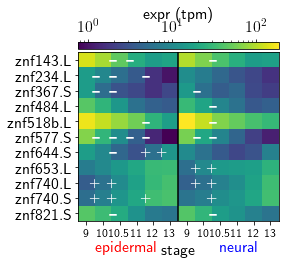

In [105]:
sigT = trimPway(sig)
grptitle = 'st10de_lt10_parallel'
fac = 0.3
fig,axs=plt.subplots(1,1,figsize=(12*fac,len(idxs)*fac))
datS   = dat[:,idxs].T+0.5
im = axs.imshow(datS,aspect='auto',norm=matplotlib.colors.LogNorm())
axs.vlines(x=5.5,ymin=-0.5,ymax=len(idxs)-0.5)

# breaks = np.cumsum(glens)
# for br in breaks[:-1]:
#     axs.hlines(y=br-0.5,xmin=-0.5,xmax=11.5,linestyle='dashed')

for idx in isDeIdxs:
    cidx,ridx = idx
    if datS[ridx,cidx] < datS[ridx,cidx+1]:
        axs.text(s=r'$\boldsymbol{+}$',x=cidx+0.18,y=ridx+0.25,color='white',size=13)#for jpg export
        #axs.text(s=r'$\boldsymbol{+}$',x=cidx+0.25,y=ridx+0.2,color='white',size=13) #for pdf export
    else:
        axs.text(s='-',x=cidx+0.35,y=ridx+0.1,color='white',size='30') #for jpg export
        #axs.text(s='-',x=cidx+0.35,y=ridx+0.45,color='white',size='30') #for pdf export

    #axs.text(s='.',x=idx[1]+0.4,y=idx[0]+0.1,color='white',size='40')
    
axs.set_yticks(range(len(idxs)))
axs.set_yticklabels(gnames)

axs.set_xticks(range(len(stages)*2))
axs.set_xlabel('stage')

divider = make_axes_locatable(axs)
cax2     = divider.append_axes("top", size=0.1, pad=0.05)

cbar = fig.colorbar(im, cax=cax2,orientation='horizontal')
cbar.set_label('expr (tpm)',rotation=0, labelpad=2)
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_ticks_position('top')

axs.text(s='epidermal',y=len(idxs)+1.5,x=0.5,color='red',size=16)
axs.text(s='neural',y=len(idxs)+1.5,x=8,color='blue',size=16)


mf.set_axs_fontsize(axs,16)
mf.set_axs_fontsize(cax2,16)
axs.set_xticklabels(stagestrs*2,fontsize=12)

#ticks = np.power(10.,np.arange(0,3,1))
#cax2.yaxis.set_ticks(-np.log10(ticks))
#cax2.yaxis.set_ticklabels(ticks)
plt.savefig('{0}/{1}_{2}_genes_expr_p{3}.jpg'.format(plotdir,sigT,grptitle,ii),bbox_inches="tight")


In [356]:
sig        = 'MAPK signaling pathway'
keyIdxs    = [keggIdxs[i].get(sig,[]) for i in range(ngrp)]
degenes    = np.array(keyIdxs[2])
dat        = gtpmMu[:,degenes]

epidDat = gtpmMu[:6, degenes]
epidDatN = epidDat / linalg.norm(epidDat,axis=1)

neurDat = gtpmMu[6:, degenes]
neurDatN = neurDat / linalg.norm
costhsM  = np.sum(dat[:,0:6]*dat[:,6:],axis=1)/linalg.norm(datS[:,0:6],axis=1)/linalg.norm(datS[:,6:],axis=1)

In [368]:
np.max(epidDatN)

0.9526990920517755

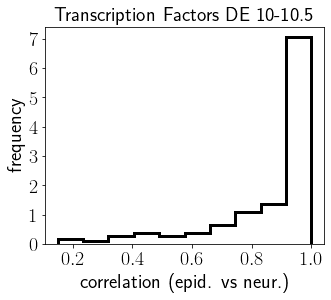

In [112]:
fig,axs=plt.subplots(figsize=(5,4))
#axs.hist(keggCosThs('MAPK signaling pathway',2),color='blue',density=True,histtype='step',linewidth=3,label='MAPK')
#axs.hist(keggCosThs('TGF-beta signaling pathway',2), color='red',density=True,histtype='step',linewidth=3,label='TGF-beta')
#axs.hist(keggCosThs('transcription factors',2), color='black',density=True,histtype='step',linewidth=3,label='TFs')
axs.hist(cosTsUnion, color='black',density=True,histtype='step',linewidth=3,label='TFs')

#axs.legend()
axs.set_xlabel('correlation (epid. vs neur.)')
axs.set_ylabel('frequency')

#axs.set_title('Early DE Genes (epid/neur overlap)')
axs.set_title('Transcription Factors DE 10-10.5')

mf.set_axs_fontsize(axs,20)#,True)

#plt.savefig('{0}/epid_neur_corr_early_overlap_de.jpg'.format(plotdir,sigT,grptitle,ii),bbox_inches="tight")
plt.savefig('{0}/epid_neur_corr_tfs_de10-105.jpg'.format(plotdir,sigT,grptitle,ii),bbox_inches="tight")




In [404]:
len(tfsOverlap10),len(tfsEpid10),len(tfsNeur10),len(tfsUnion10)

(109, 194, 202, 287)

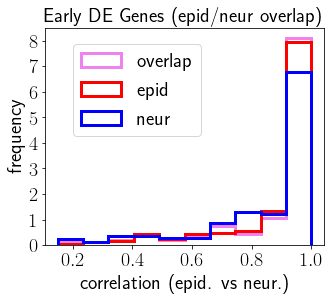

In [402]:
fig,axs=plt.subplots(figsize=(5,4))
axs.hist(cosThs(tfsOverlap10),color='violet',density=True,histtype='step',linewidth=3,label='overlap')
axs.hist(cosThs(tfsEpid10), color='red',density=True,histtype='step',linewidth=3,label='epid')
axs.hist(cosThs(tfsNeur10), color='blue',density=True,histtype='step',linewidth=3,label='neur')
axs.legend(loc=(0.1,0.5),fontsize=20)
axs.set_xlabel('correlation (epid. vs neur.)')
axs.set_ylabel('frequency')

axs.set_title('Early DE Genes (epid/neur overlap)')
mf.set_axs_fontsize(axs,20,False)

In [ ]:
costh(v1,v2)

In [ ]:
## sig = 'Wnt signaling pathway'
sigT = trimPway(sig)
ngenesPerSigT = [sigCtsBnd[i].get(sig,0) for i in range(len(sigCtsBnd))]
pvsPerSigT = [sigPvsBnd[i].get(sigT,0) for i in range(len(sigPvsBnd))]
nt = 5 #6
ts = np.arange(nt)+0.5
fig,axs=plt.subplots(1,2,figsize=(10,4))

axs[0].plot(ts,ngenesPerSigT[0:nt],color='red',marker='o')
axs[1].plot(ts,pvsPerSigT[0:nt],color='red',marker='o')

axs[0].plot(ts,ngenesPerSigT[nt:],color='blue',marker='s')
axs[1].plot(ts,pvsPerSigT[nt:],color='blue',marker='s')

axs[0].set_ylabel('\# of DE {0} genes'.format(sigT))
axs[1].set_ylabel(sigT+' overrepresentation \n$-\log_{10}(P_{HG})$')

axs[0].text(s='\#({0}) = {1}'.format(sigT,nullPwayCts[sig]),x=0.25,y=0.9,transform=axs[0].transAxes, fontsize=20)
for i in range(2):
    axs[i].set_xlabel('stage')
    axs[i].set_xticks(range(nt+1))
    axs[i].set_xticklabels(stagestrs)

mf.set_axs_fontsize(axs[0],20)
mf.set_axs_fontsize(axs[1],20)

plt.subplots_adjust(wspace=0.5)
plt.savefig('{0}/{1}_n_pv_vsT_deseq{2}.jpg'.format(plotdir,sigT,thresh),bbox_inches="tight")


In [966]:
pvDicts = sigPvsBnd #

pways    = np.array(list(reduce(lambda x,y: x|y,[d.keys() for d in pvDicts])))
npways   = len(pways)
pwaypvsA = np.zeros((npways,len(pvDicts)))

for i in range(npways):
    for j in range(len(pvDicts)):
        pwaypvsA[i,j] = pvDicts[j].get(pways[i],0)

In [1213]:
len(sigPvsBnd)

10

In [967]:
sort=np.argsort(-1*pwaypvsA[:,-1])

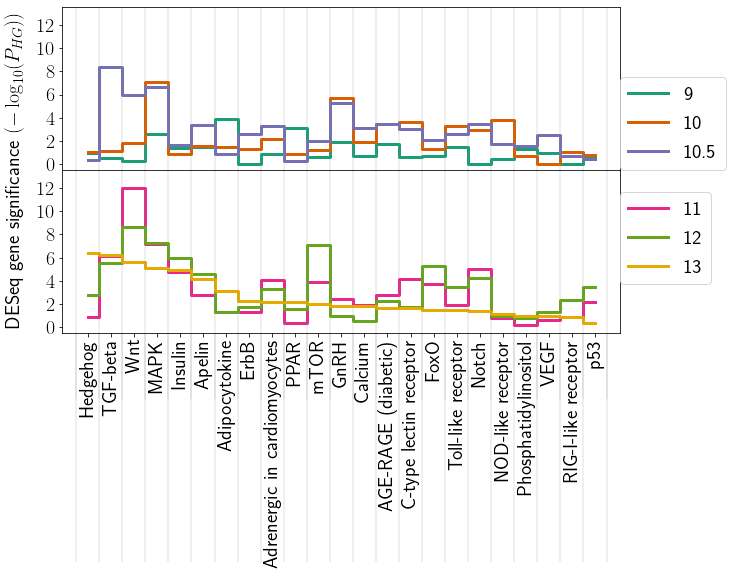

In [983]:
# cols = plt.cm.Paired.colors
cols1 = plt.cm.viridis(np.linspace(0,1,len(pvDicts)))[0:3]
cols2 = plt.cm.viridis(np.linspace(0,1,len(pvDicts)))[3:]
cols = plt.cm.Dark2.colors #np.vstack([cols1,cols2])

fl = lambda x: int(np.floor(x))
fig,axs=plt.subplots(2,1,figsize=(10,6))
labs = ['neural early', 'neural late', 'epidermal early', 'epidermal late']
labs = ['neural 10-10.5', 'neural 10.5-11', 'epidermal 10-10.5', 'epidermal 10.5-11']
labs = ['9-10', '10-10.5', '10.5-11', '11-12','12-13']
labs = stagestrs

nper=3
nr=2
for i in range(nper*nr):
    axs[fl(i/nper)].step(np.arange(npways),pwaypvsA[sort,i],color=cols[i],
                         linewidth=3,label=labs[i],#%nper],
                         where='mid')

axs[1].set_ylabel('DESeq gene significance $(-\log_{10}(P_{HG}))$',labelpad=10,position=(0,1))
#axs[0].set_ylabel('$(-\log_{10}(P_{HG}))$',labelpad=10)
axs[1].set_xticks(np.arange(npways))
axs[1].set_xticklabels(pways[sort],rotation='vertical')
for i in range(nr):
    #axs[i].grid(axis='x',which='both')
    for j in np.arange(-0.5,npways+0.5):
        axs[i].axvline(j,color='gray',linewidth=0.25,ymin=-1.4,clip_on=False)
    mf.set_axs_fontsize(axs[i],20,False)
    #axs[i].set_yscale('log')

axs[1].set_ylim(-0.5,13.5)
axs[0].set_ylim(-0.5,13.5)

axs[0].legend(loc=(1,0),fontsize=20)
axs[1].legend(loc=(1,0.3),fontsize=20)

#axs[0].text(s='neural',x=0.2,y=0.8, transform=axs[0].transAxes,fontsize=20)
#axs[1].text(s='epidermal',x=0.15,y=0.8,transform=axs[1].transAxes,fontsize=20)


plt.subplots_adjust(hspace=0)

plt.savefig('{0}/pway_phg_temporal_epid_vs_neur.jpg'.format(plotdir), bbox_inches="tight")

In [504]:
sigCtsEpidBnd = []

thresh2 = 0.01
threshB = thresh2 / len(nullPwayCts)

ngrp = len(sigCtsEpidBnd)
sigPvsEpidBnd = [{} for i in range(ngrp)]

for i in range(ngrp):
    for k,v in sigCtsEpidBnd[i].items():
        pv = 1-hg.cdf(v,ngenes,nullPwayCts[k],len(lowPVepid[i+1]))
        if pv < threshB:
            sigPvsEpidBnd[i][trimPway(k)] = -np.log10(pv)

In [311]:
neurLateExc = np.setdiff1d(deGenesNeurLate,deGenesNeurEarly)

In [328]:
neurLatePwayCts = {}
for idx in neurLateExc:
    if idx in sigidxs:
        for pwy in gene2sig.get(gnmsS[idx].lower()):
            neurLatePwayCts[pwy] = neurLatePwayCts.get(pwy,0)+1

In [329]:
neurLatePwayPVs = {}
for k,v in neurLatePwayCts.items():
    pv = 1-hg.cdf(v,ngenes,nullPwayCts[k],len(neurLateExc))
    neurLatePwayPVs[k] = pv

In [333]:
bpthresh = 0.025/len(nullPwayCts)

In [326]:
for k in set(neurLatePwayCts)|set(neurLateCts2):
    v1 = neurLatePwayCts.get(k,0)
    v2 = neurLateCts2.get(k,0)
    if  v1!=v2 :
        print('{0}:{1}, {2}'.format(k,v1,v2))

In [1210]:
# # bunch of tests for comparison between 2-sample deseq and 3-sample
# [(lowPVepid[i].shape[0],[lowPVepid2r[j,i].shape[0] for j in range(3)]) for i in range(len(lowPVepid))]
# [(lowPVneur[i].shape[0],[lowPVneur2r[j,i].shape[0] for j in range(3)]) for i in range(len(lowPVneur))]'
# [[np.intersect1d(lowPVepid[i],lowPVepid2r[j,i]).shape[0]/lowPVepid2r[j,i].shape[0] for j in range(3)] 
#  for i in range(5)]
# [[np.intersect1d(lowPVepid[i],lowPVepid2r[j,i]).shape[0]/lowPVepid[i].shape[0] for j in range(3)] 
#  for i in range(5)]
# [[np.intersect1d(lowPVneur[i],lowPVneur2r[j,i]).shape[0]/lowPVneur2r[j,i].shape[0] for j in range(3)] 
#  for i in range(5)]
# [[np.intersect1d(lowPVneur[i],lowPVneur2r[j,i]).shape[0]/lowPVneur[i].shape[0] for j in range(3)] 
#  for i in range(5)]

In [1209]:
srt = np.flip(np.argsort(list(tfdictcts.values())))
ks = np.array(list(tfdictcts.keys()))
#[(k,tfdictcts[k]) for k in ks[srt]]

In [479]:
gtpm.shape

(2, 3, 6, 49112)

In [494]:
np.unique(np.sort(gtpm))[0:5]

array([0.        , 0.03433085, 0.03527676, 0.03547829, 0.0357563 ])

In [520]:
np.array(np.split(gtpmMu,2)).shape

(2, 6, 49112)

In [526]:
ngenes,len(idxs)

(49112, 26311)

In [52]:
gtpmMu.shape

(12, 45660)

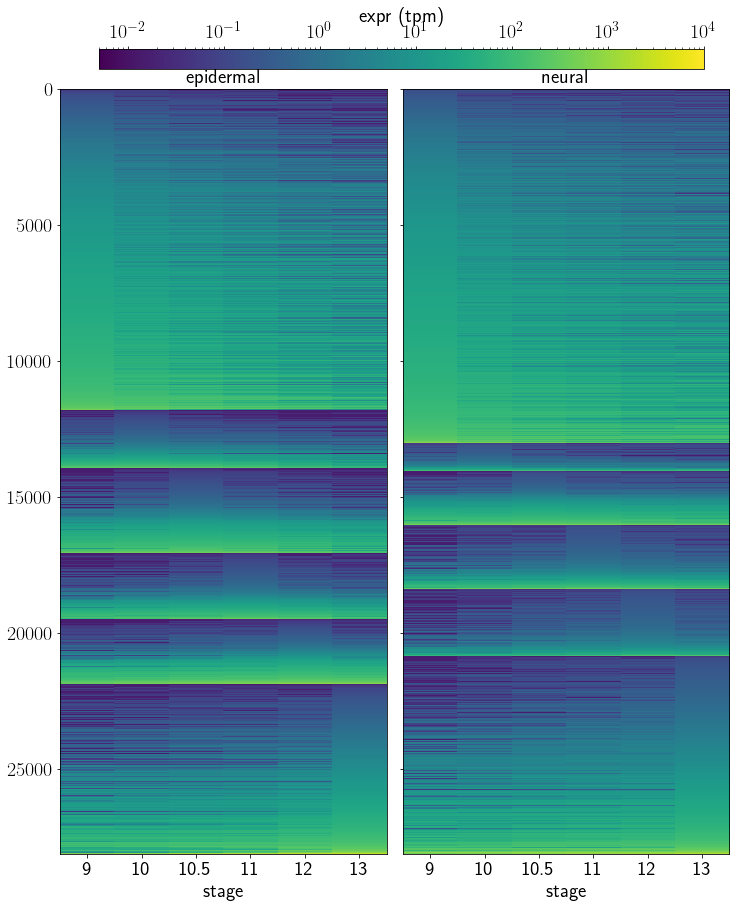

In [149]:
#dat        = gtpm[1,1]
tpmThresh     = 0.5
idxs       = np.where((np.sum(gtpmMu[:6],axis=0)>tpmThresh) | (np.sum(gtpmMu[6:12],axis=0)>tpmThresh))[0]
minc = 0.005
maxc = 10000

edat  = gtpmMu[:6,idxs]
ndat  = gtpmMu[6:12,idxs]
dats  = [edat, ndat]
sorts = [mf.argmaxsort(dat)[0] for dat in dats]
datsS = [dats[i][:,sorts[i]].T+0.015 for i in range(len(dats))]

fig,axs=plt.subplots(1,2,figsize=(12,len(idxs)/2000))

#datS   = dat[:,sort].T+0.015
im1 = axs[0].imshow(datsS[0],aspect='auto',norm=matplotlib.colors.LogNorm(),vmin=minc,vmax=maxc)
im2 = axs[1].imshow(datsS[1],aspect='auto',norm=matplotlib.colors.LogNorm(),vmin=minc,vmax=maxc)

#axs.vlines(x=5.5,ymin=-0.5,ymax=len(degenes)-0.5)

# breaks = np.cumsum(glens)
# for br in breaks[:-1]:
#     axs.hlines(y=br-0.5,xmin=-0.5,xmax=11.5,linestyle='dashed')

    
#axs.set_yticks(range(len(degenes)))
#axs.set_yticklabels(gnames)
cb_ax = fig.add_axes([0.17, 0.9, 0.7, 0.02])
cbar = fig.colorbar(im1, cax=cb_ax,orientation='horizontal')
cbar.set_label('expr (tpm)',rotation=0, labelpad=2)

#set the colorbar ticks and tick labels
#cbar.set_ticks(np.arange(0, 1.1, 0.5))
#cbar.set_ticklabels(['low', 'medium', 'high'])
cb_ax.xaxis.set_label_position('top')
cb_ax.xaxis.set_ticks_position('top')

axs[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05)

axs[0].set_title('epidermal')
axs[1].set_title('neural')
for ax in axs:
    ax.set_xticks(range(len(stages)))
    ax.set_xlabel('stage')
    ax.set_xticklabels(stagestrs,fontsize=12)


#     divider = make_axes_locatable(ax)
#     cax2     = divider.append_axes("top", size=0.1, pad=0.05)

#     cbar = fig.colorbar(im1, cax=cax2,orientation='horizontal')
#     cbar.set_label('expr (tpm)',rotation=0, labelpad=2)
#     cax2.xaxis.set_label_position('top')
#     cax2.xaxis.set_ticks_position('top')

    mf.set_axs_fontsize(ax,20)
mf.set_axs_fontsize(cb_ax,20)


    #mf.set_axs_fontsize(cax2,16)
#plt.savefig('{0}/expr_heatmap_epid_vs_neur_rmu_th{1}.jpg'.format(plotdir,tpmThresh,thresh),bbox_inches="tight")


In [152]:
gtpmMu.shape,np.max(gtpmMu,axis=0).shape
len(idxs),[i.shape for i in datsS]

(14887, [(45660, 6), (45660, 6), (45660, 6)])

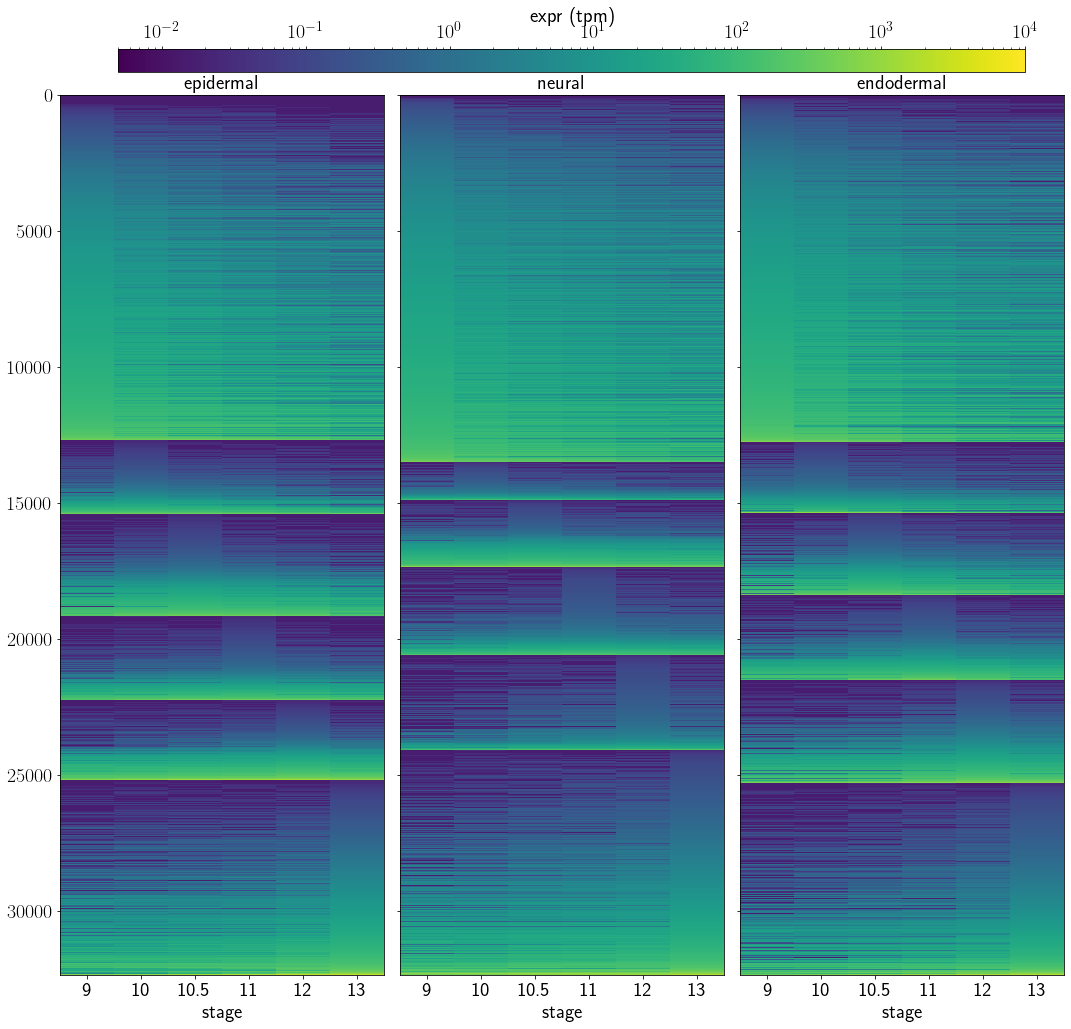

In [157]:
tpmThresh     = 0.1
#idxs       = np.where((np.sum(gtpmMu[:6],axis=0)>tpmThresh) | (np.sum(gtpmMu[6:12],axis=0)>tpmThresh) | (np.sum(gtpmMu[12:],axis=0)>tpmThresh))[0]
idxs = np.where(np.max(gtpmMu,axis=0)>tpmThresh)[0]
minc = 0.005
maxc = 10000

dats  = np.split(gtpmMu[:,idxs],3)
sorts = [mf.argmaxsort(dat)[0] for dat in dats]
datsS = [dats[i][:,sorts[i]].T+0.015 for i in range(len(dats))]

fig,axs=plt.subplots(1,3,figsize=(18,len(idxs)/2000))

#datS   = dat[:,sort].T+0.015
im1 = axs[0].imshow(datsS[0],aspect='auto',norm=matplotlib.colors.LogNorm(),vmin=minc,vmax=maxc)
im2 = axs[1].imshow(datsS[1],aspect='auto',norm=matplotlib.colors.LogNorm(),vmin=minc,vmax=maxc)
im3 = axs[2].imshow(datsS[2],aspect='auto',norm=matplotlib.colors.LogNorm(),vmin=minc,vmax=maxc)


cb_ax = fig.add_axes([0.17, 0.9, 0.7, 0.02])
cbar = fig.colorbar(im1, cax=cb_ax,orientation='horizontal')
cbar.set_label('expr (tpm)',rotation=0, labelpad=2)

#set the colorbar ticks and tick labels
cb_ax.xaxis.set_label_position('top')
cb_ax.xaxis.set_ticks_position('top')

axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

plt.subplots_adjust(wspace=0.05)

axs[0].set_title('epidermal')
axs[1].set_title('neural')
axs[2].set_title('endodermal')
for ax in axs:
    ax.set_xticks(range(len(stages)))
    ax.set_xlabel('stage')
    ax.set_xticklabels(stagestrs,fontsize=12)

    mf.set_axs_fontsize(ax,20)
mf.set_axs_fontsize(cb_ax,20)


    #mf.set_axs_fontsize(cax2,16)
plt.savefig('{0}/expr_heatmap_3_th{1}.jpg'.format(plotdir,tpmThresh,thresh),bbox_inches="tight")


### gtpmMu.shape,np.array(np.split(gtpmMu,3)).shape

In [1153]:
thresh=0.05
lowPVne   = [lowpvalidxs(nepvs[i],thresh) for i in range(len(stagestrs))]

/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [1162]:
min(nepvs[0])

9.54023724872571e-26

In [1192]:
validgnm = lambda s: not(s.lower().startswith('xelaev') or 
                         s.lower().startswith('loc') or 
                         s.lower().startswith('mgc') or 
                         s.lower().startswith('xetrov'))

In [1193]:
gns = [idx for idx in lowPVne[0] if validgnm(gnmsS[idx])]

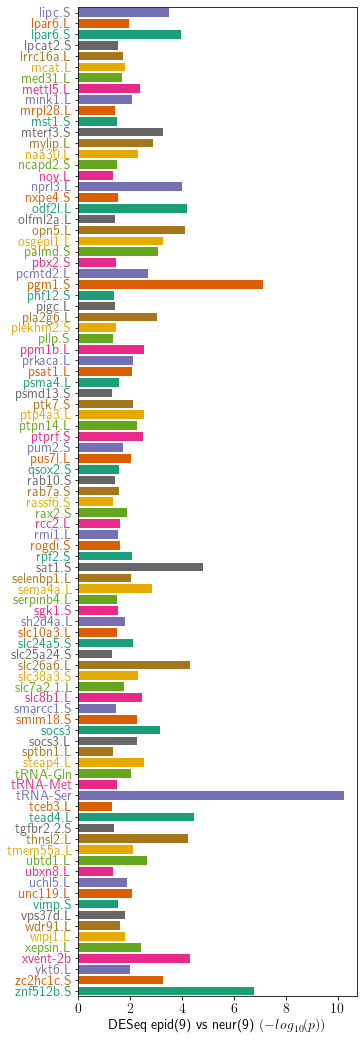

In [1202]:
cols=plt.cm.Dark2.colors
gns = np.array([idx for idx in lowPVne[0] if validgnm(gnmsS[idx])])[90:]
ngns = gns.shape[0]
dat = -np.log10(nepvs[0][gns])
sort = np.flip(np.argsort(gnmsS[gns]))
fig,axs=plt.subplots(1,1,figsize=(5,ngns/5))
axs.barh(np.arange(ngns),dat[sort],color =cols )
axs.set_yticks(np.arange(ngns))
axs.set_yticklabels(gnmsS[gns[sort]])
#axs.tick_params(axis='y', colors=cols)
for i in range(ngns):
    axs.get_yticklabels()[i].set_color(cols[i%len(cols)])

axs.set_ylim(-0.5,ngns-0.5)
axs.set_xlabel('DESeq epid(9) vs neur(9) $(-log_{10}(p))$')
mf.set_axs_fontsize(axs,14)
plt.savefig('{0}/deseq_stg9_genes_p2.pdf'.format(plotdir,thresh2,thresh),bbox_inches="tight")


In [107]:
nt   = 5
delT = 0

epidGenes = np.array(list(set(mf.flatten2d(lowPVepid))))
epidPM    = np.zeros((len(epidGenes),nt))

# this is inefficient but who cares
for i in range(epidPM.shape[0]):
    gidx = epidGenes[i]
    for t in range(epidPM.shape[1]):
        if gidx in lowPVepid[t]:
            if gctsMu[t+delT+1,gidx] > gctsMu[t+delT,gidx]:
                epidPM[i,t] = 1
            else:
                epidPM[i,t] = -1
                
                

neurGenes = np.array(list(set(mf.flatten2d(lowPVneur))))
neurPM    = np.zeros((len(neurGenes),nt))
delT = 5
# this is inefficient but who cares
for i in range(neurPM.shape[0]):
    gidx = neurGenes[i]
    for t in range(neurPM.shape[1]):
        if gidx in lowPVneur[t]:
            if gctsMu[t+delT+1,gidx] > gctsMu[t+delT,gidx]:
                neurPM[i,t] = 1
            else:
                neurPM[i,t] = -1

In [108]:
epidPMabsSums = np.sum(np.abs(epidPM),axis=1)
epidPMsums    = np.sum(epidPM,axis=1)
epidUpdowns   = epidGenes[np.where((epidPMabsSums > 0) & (epidPMabsSums!=np.abs(epidPMsums)))[0]]

epidUps       = epidGenes[np.where(epidPMabsSums == epidPMsums)[0]]
epidDowns     = epidGenes[np.where(epidPMabsSums == -1*epidPMsums)[0]]

neurPMabsSums = np.sum(np.abs(neurPM),axis=1)
neurPMsums    = np.sum(neurPM,axis=1)
neurUpdowns   = neurGenes[np.where((neurPMabsSums > 0) & (neurPMabsSums!=np.abs(neurPMsums)))[0]]

neurUps       = neurGenes[np.where(neurPMabsSums == neurPMsums)[0]]
neurDowns     = neurGenes[np.where(neurPMabsSums == -1*neurPMsums)[0]]

In [109]:
# what do those late neural genes mark for anyway
earlyNeur    = np.unique(np.hstack([lowPVneur[0],lowPVneur[1]]))
earlyEpid    = np.unique(np.hstack([lowPVepid[0],lowPVepid[1]]))
earlyOverlap = np.intersect1d(earlyEpid,earlyNeur)

lateNeur    = np.unique(np.hstack([lowPVneur[2],lowPVneur[3],lowPVneur[4]]))
lateEpid    = np.unique(np.hstack([lowPVepid[2],lowPVepid[3],lowPVepid[4]]))
lateOverlap = np.intersect1d(lateEpid,lateNeur)

earlyLateNeur    = np.intersect1d(earlyNeur, lateNeur)
earlyLateEpid    = np.intersect1d(earlyEpid, lateEpid)
earlyLateOverlap = np.intersect1d(earlyLateNeur, earlyLateEpid) 

earlyEpidExc = np.setdiff1d(earlyEpid,earlyNeur)
earlyNeurExc = np.setdiff1d(earlyNeur,earlyEpid)

lateEpidExc = np.setdiff1d(lateEpid,lateNeur)
lateNeurExc = np.setdiff1d(lateNeur,lateEpid)

updownsEpidExc = np.setdiff1d(epidUpdowns,neurUpdowns)
updownsNeurExc = np.setdiff1d(neurUpdowns,epidUpdowns)
updownsOverlap = np.intersect1d(epidUpdowns,neurUpdowns)

upsEpidExc = np.setdiff1d(epidUps,neurUps)
upsNeurExc = np.setdiff1d(neurUps,epidUps)
upsOverlap = np.intersect1d(epidUps,neurUps)

downsEpidExc = np.setdiff1d(epidDowns,neurDowns)
downsNeurExc = np.setdiff1d(neurDowns,epidDowns)
downsOverlap = np.intersect1d(epidDowns,neurDowns)

In [110]:
catGroups = np.array(list(kdg.num2group.values()))
pway2num = {pway:kdg.cat2num[cat][0] for pway,cat in kdg.pway2cat.items()}
pway2grp = {pway:catGroups[num-1] for pway,num in pway2num.items()}
grp2num  = dict(zip(catGroups,range(len(catGroups))))

In [111]:
# geneGrps   = [earlyNeur, lateNeur]
# geneGrps   = [np.hstack([epidUps, epidDowns]), epidUpdowns]
# geneGrps   = [earlyEpidAndNeur, lateEpid, epidUpdowns]

# #geneGrps   = [np.setdiff1d(geneGrps[i], reduce(np.union1d,[geneGrps[j] for j in range(len(geneGrps)) if j !=i ]))
# #             for i in range(len(geneGrps))] #make the sets exclusive to one another

# geneGrps   = [np.setdiff1d(earlyEpidAndNeur, np.union1d(lateEpid,epidUpdowns)),
#               np.setdiff1d(lateEpid,epidUpdowns),
#               epidUpdowns]
# geneGrps   = [earlyEpidAndNeur, earlyEpidNotNeur, earlyNeurNotEpid]
# geneGrps   = [lateOverlap, lateEpidExc, lateNeurExc]

# geneGrps   = [earlyEpidExc, earlyNeurExc, earlyOverlap, 
#               lateEpidExc, lateNeurExc,lateOverlap,
#               updownsEpidExc,updownsNeurExc, updownsOverlap]

# geneGrps   = [upsEpidExc, upsNeurExc, upsOverlap, 
#               updownsEpidExc,updownsNeurExc, updownsOverlap,
#              downsEpidExc, downsNeurExc,downsOverlap,]

geneGrps   = [epidUps, neurUps, upsOverlap, 
              epidUpdowns,neurUpdowns, updownsOverlap,
             epidDowns, neurDowns,downsOverlap,]

geneGrps  = [lateEpid, lateNeur, lateOverlap,
             earlyLateEpid, earlyLateNeur, earlyLateOverlap,
             earlyEpid, earlyNeur, earlyOverlap
            ]


keggCtsBnd = [kegglists(grp)[1] for grp in geneGrps]
ngrp       = len(geneGrps)

thresh2 = len(keggidxsnull)
threshB = thresh2 / len(keggidxsnull)

keggPvsBnd = [{} for i in range(ngrp)]

for i in range(ngrp):
    for k,v in keggCtsBnd[i].items():
        pv = 1-hg.cdf(v,gnmsS.shape[0],nullKeggCts[k],geneGrps[i].shape[0])
        if pv <= threshB:
            keggPvsBnd[i][k] = -np.log10(max(pv,10**-12))

In [112]:
# gather kegg keys and pvals into usable arrays
labs  = np.array(list(keggPvsBnd[0].keys()|keggPvsBnd[1].keys()))
nkegg = len(labs)
vals  = np.zeros((nkegg,ngrp))

for i in range(nkegg):
    for j in range(ngrp):
        vals[i,j] = keggPvsBnd[j].get(labs[i],0)

In [113]:
# grpOrd = np.flip(np.array(['Cellular Processes','Genetic Information Processing', 'Environmental Information Processing',
#          'Metabolism','Organismal Systems','Human Diseases','Drug Development']));
# pwayGrpOrd = [grp2num.get(g,7) for g in grpOrd] + [7]
#pwayGrpOrd = np.flip([7]+[np.where(catGroups==grp)[0][0] for grp in grpOrd])


In [114]:
customKeggs = ['transcription factors','MAPK signaling pathway','TGF-beta signaling pathway',
               'FoxO signaling pathway','Wnt signaling pathway','Hedgehog signaling pathway',
               'Notch signaling pathway']

customKeggs = ['MAPK signaling pathway','TGF-beta signaling pathway',
               'FoxO signaling pathway','Hedgehog signaling pathway','Notch signaling pathway','transcription factors']

customKeggs = ['transcription factors',
               'Notch signaling pathway', 'Notch signaling pathway'+nontfstr,'Notch signaling pathway'+tfstr, 
               'Hedgehog signaling pathway','Hedgehog signaling pathway'+nontfstr,'Hedgehog signaling pathway'+tfstr]

customKeggs = ['transcription factors',
               'BMP signaling pathway', 'BMP signaling pathway'+nontfstr, 'BMP signaling pathway'+tfstr,
               'TGF-beta signaling pathway', 'TGF-beta signaling pathway'+nontfstr, 'TGF-beta signaling pathway'+tfstr,
               'MAPK signaling pathway','MAPK signaling pathway'+nontfstr, 'MAPK signaling pathway'+tfstr]



vidxs = [np.where(labs==ck)[0][0] for ck in customKeggs]
for i in customKeggs:
    pway2num[i]=9


In [115]:
# # group kegg keys by their isA attribute
# nPwGrp       = len(catGroups) + 2 #1 # add a custom option and an 'other' option
# pwayGroups   = [[] for i in range(nPwGrp)]
# thresh       = -1

# # bin labels by group
# for i in range(nkegg):
#     if np.max(vals[i]) > thresh:
#         pwayGroups[pway2num.get(labs[i],nPwGrp)-1].append(i)

# pwayGroups = [np.array(grp) for grp in pwayGroups]

# # in group sorting... by max?
# pwayGroupsSrtd = []
# for i in range(nPwGrp):
#     if pwayGroups[i].shape[0] > 0:
#         valsort = np.argsort(vals[pwayGroups[i],0])
#         pwayGroupsSrtd.append(pwayGroups[i][valsort])
#     else:
#         pwayGroupsSrtd.append([])

# # flatten
# sort = mf.flatten2d(pwayGroupsSrtd)

In [116]:
#breaks = np.cumsum([len(x) for x in pwayGroupsSrtd])

In [117]:
#sortz = mf.flatten2d([pwayGroupsSrtd[i] for i in [7]]) #sort

In [118]:
import matplotlib.patches as patches


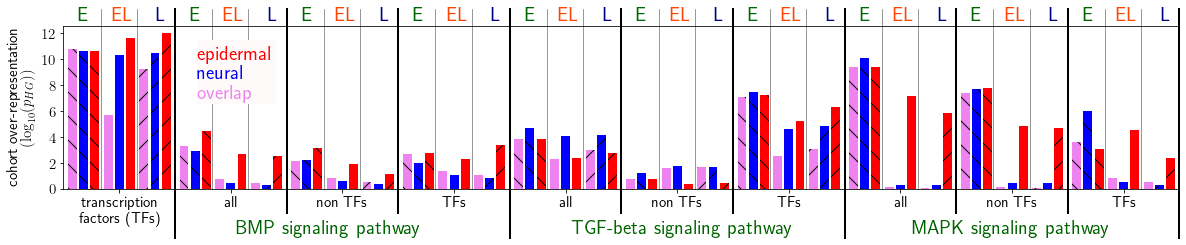

In [119]:
sortx = vidxs #np.flip(sortz)

grpname = 'bmp_tgf_mapk_EL' #'signalling'#
nrow = len(sortx)
fig,axs=plt.subplots(1,1,figsize=(nrow*2,3))

cols = ['red','blue','violet']
hatches = ['/','','\\']
barlabs = ['epid ups', 'neur ups', 'overlap ups',
           'epid updowns','neur updowns','overlap updowns',
           'epid downs','neur downs','overlap downs']

ht = 0.1
offset = ht*(ngrp-1)/2.
offsets = [0.42,0.32,0.22,0.1,0,-0.1,-0.22,-0.32,-0.42] #offset-ht*np.arange(ngrp)
for i in range(ngrp):
    axs.bar(np.arange(nrow)+offsets[i],vals[sortx,i],width=0.08,
             color=cols[i%3], hatch=hatches[int(i/3)],#edgecolor='white',
             label=barlabs[i] if labs[i] else None)

axs.set_xlim(-0.5,nrow-0.5)
axs.set_xticks(np.arange(nrow))


#axs.set_xticklabels(list(map(trimPway,labs[sortx]))) #labs[sortz])
xtixlabs = ['transcription\nfactors (TFs)'] + ['all','non TFs', 'TFs']*3
axs.set_xticklabels(xtixlabs) #labs[sortz])


for i in range(1,nrow+1):
    ymn = -0.3 if (i-1)%3==0 else -0.15
    axs.axvline(x=i-0.5,ymin=ymn,ymax=1.1,color='black',clip_on=False,linewidth=2)

for i in np.arange(1/3,nrow+1/3,1):
    axs.axvline(x=i-0.5,ymin=0,ymax=1.1,color='gray',clip_on=False,linewidth=0.8)
    axs.axvline(x=i-0.5+1/3-0.01,ymin=0,ymax=1.1,color='gray',clip_on=False,linewidth=0.8)
    
#     axs.text(x=i-0.8,y=13.5,s='$-$',fontsize=30,color='darkgreen')
#     axs.text(x=i-0.45,y=13,s='$\pm$',fontsize=30,color='orangered')
#     axs.text(x=i-0.1,y=13,s='$+$',fontsize=30,color='navy')
    
    axs.text(x=i-0.7,y=13,s='E',fontsize=20,color='darkgreen')
    axs.text(x=i-0.4,y=13,s='EL',fontsize=20,color='orangered')
    axs.text(x=i,y=13,s='L',fontsize=20,color='navy')

props = dict(boxstyle='round', facecolor='snow', alpha=1)

# axes coordinates are 0,0 is bottom left and 1,1 is upper right
p = patches.Rectangle((0.7, 6.5), 0.7, 5,fill=True, facecolor='snow',alpha=1,zorder=3)

axs.add_patch(p)

axs.text(x=0.7,y=10,s='epidermal',color=cols[0],fontsize=20)
axs.text(x=0.7,y=8.5,s='neural',color=cols[1],fontsize=20)
axs.text(x=0.7,y=7,s='overlap',color=cols[2],fontsize=20)

axs.text(x = 1.05, y = -3.5, s='BMP signaling pathway', fontsize = 20, color = 'darkgreen')
axs.text(x = 4.05, y = -3.5, s='TGF-beta signaling pathway', fontsize = 20, color = 'darkgreen')
axs.text(x = 7.1, y = -3.5, s='MAPK signaling pathway', fontsize = 20, color = 'darkgreen')

axs.set_ylabel('cohort over-representation\n$(\log_{10}(p_{HG}))$')
#axs.legend(loc=(1,0.32),fontsize=16)
mf.set_axs_fontsize(axs,15,False)
#plt.savefig('{0}/kegg_{1}_hg_pvals_epidNeurEarly_v_epidLate_v_epidUpdowns.jpg'.format(plotdir,grpname),bbox_inches="tight")
#plt.savefig('{0}/kegg_{1}_hg_pvals_nexc_pways_wtf.jpg'.format(plotdir,grpname),bbox_inches="tight")



In [120]:
#geneGrps   = lowPVepid

def keggPvDict(grp):
    # takes in a list of gene indices
    keggCts = kegglists(grp)[1]
    pvdict  = {}

    for k,v in keggCts.items():
        pv = 1 - hg.cdf(v, gnmsS.shape[0], nullKeggCts[k], grp.shape[0])
        pvdict[k] = -np.log10(max(pv,10**-12))
    
    return pvdict

keggPvsEpid = [keggPvDict(grp) for grp in lowPVepid]
keggPvsNeur = [keggPvDict(grp) for grp in lowPVneur]


In [122]:
keggPvsNE = [keggPvDict(grp) for grp in lowPVne]

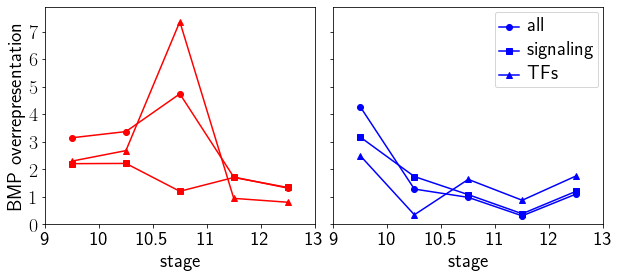

In [121]:
pway = 'BMP signaling pathway'
pwaynm = trimPway(pway)
sigs = [pway, pway + nontfstr, pway + tfstr]
pvTrajE = np.array([[keggPvsEpid[i][sig] for i in range(nt)] for sig in sigs])
pvTrajN = np.array([[keggPvsNeur[i][sig] for i in range(nt)] for sig in sigs])
trajs = [pvTrajE, pvTrajN]


ts = np.arange(5)+0.5

fig,axs=plt.subplots(1,2,figsize=(10,4))
cols = ['red', 'blue']

for i in range(2):
    axs[i].plot(ts, trajs[i][0], 'o-', c = cols[i], label = 'all')
    axs[i].plot(ts, trajs[i][1], 's-', c = cols[i], label = 'signaling')
    axs[i].plot(ts, trajs[i][2], '^-', c = cols[i], label = 'TFs')
    axs[i].set_xlabel('stage')
    axs[i].set_xticks(range(6))
    axs[i].set_xticklabels(stagestrs)
    
    axs[i].set_ylim(0,7.9)

axs[1].legend()

axs[0].set_ylabel('{0} overrepresentation'.format(pwaynm))

axs[1].set_yticklabels([])

mf.set_axs_fontsize(axs[0], 20, False)
mf.set_axs_fontsize(axs[1], 20, True)

plt.subplots_adjust(wspace=0.07)

#plt.savefig('{0}/{1}_vtime_wtf_rng3.jpg'.format(plotdir,pwaynm),bbox_inches="tight")


ModuleNotFoundError: No module named 'Image'

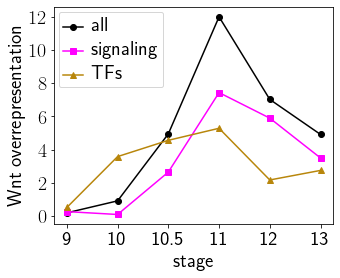

In [146]:
pway = 'Wnt signaling pathway'
pwaynm = trimPway(pway)
sigs = [pway, pway + nontfstr, pway + tfstr]
trajs = np.array([[keggPvsNE[i][sig] for i in range(nt+1)] for sig in sigs])


ts = np.arange(nt+1)

fig,axs=plt.subplots(1,1,figsize=(5,4))
cols = ['black','magenta', 'darkgoldenrod']
ms = ['o-','s-','^-']
labs = ['all','signaling','TFs']
for i in range(len(sigs)):
    axs.plot(ts, trajs[i], ms[i], c = cols[i], label = labs[i])

axs.set_xlabel('stage')
axs.set_xticks(range(6))
axs.set_xticklabels(stagestrs)

#axs[i].set_ylim(0,7.9)

axs.legend()

axs.set_ylabel('{0} overrepresentation'.format(pwaynm))

mf.set_axs_fontsize(axs, 20, True)

plt.savefig('{0}/{1}_vtime_ne.png'.format(plotdir,pwaynm),bbox_inches="tight")


In [490]:
pwaynms = ['MAPK', 'TGF-beta', 'Notch', 'Wnt', 'Hedgehog']
pwaystr = ' signaling pathway'
pways   = [pway + pwaystr for pway in pwaynms]
pways   = [pway + pwaystr + tfstr for pway in pwaynms]
#pways   = [pway + pwaystr + nontfstr for pway in pwaynms]



pidxs   = [keggidxsnull[pway] for pway in pways]

In [491]:
[len(pid) for pid in pidxs]
#np.union1d(pidxs[0],pidxs[1]).shape[0]

[43, 33, 10, 35, 2]

In [492]:
overlap_matrix = np.array([[len(np.intersect1d(pidxs[i],pidxs[j]))/len(pidxs[i]) 
                            for i in range(len(pways))] 
                           for j in range(len(pways))])

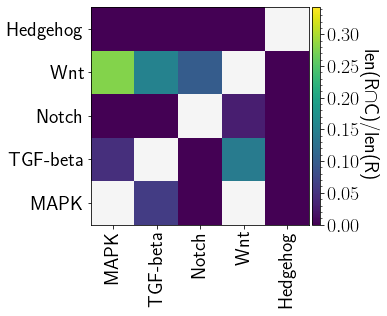

In [494]:
fig,axs=plt.subplots()

cmap = plt.get_cmap('viridis')
cmap.set_over('whitesmoke')  # Color for values less than vmin

im1 = axs.imshow(overlap_matrix,vmax=np.sort(np.unique(np.reshape(overlap_matrix,-1)))[-2], cmap=cmap)

divider = make_axes_locatable(axs)
cax2     = divider.append_axes("right", size="3.5%", pad=0.05)

cbar = fig.colorbar(im1, cax=cax2)
cbar.set_label('len(R$\cap$C)/len(R)',rotation=270, labelpad=20)
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_ticks_position('top')
cax2.minorticks_on()

axs.set_xlim(-0.5,4.5)
axs.set_ylim(-0.5,4.5)
axs.set_yticks(range(len(pwaynms)))
axs.set_yticklabels(pwaynms)

axs.set_xticks(range(len(pwaynms)))
axs.set_xticklabels(pwaynms,rotation=90)

mf.set_axs_fontsize(axs,20)
mf.set_axs_fontsize(cax2,20)


In [495]:
tdepvs = np.reshape(np.vstack([neurpvs, epidpvs]),-1)
pwaypvsN = [np.reshape(np.vstack(neurpvs[:,pidx]),-1) for pidx in pidxs]
pwaypvsE = [np.reshape(np.vstack(epidpvs[:,pidx]),-1) for pidx in pidxs]

In [449]:
isnormd = False
bins = np.hstack([[0],np.logspace(-12,0,11)])
fhist = np.histogram(tdepvs,bins, density = isnormd)[0]

pwayhistsN = [np.histogram(ppv,bins, density = isnormd)[0] for ppv in pwaypvsN]
pwayhistsE = [np.histogram(ppv,bins, density = isnormd)[0] for ppv in pwaypvsE]

In [464]:
def cdf(a): 
    x = a[np.where(np.isfinite(a))]
    return np.array([np.sort(x),np.arange(len(x))/len(x)])

In [496]:
fcdf = cdf(tdepvs)

pwaycdfsN = [cdf(ppv) for ppv in pwaypvsN]
pwaycdfsE = [cdf(ppv) for ppv in pwaypvsE]

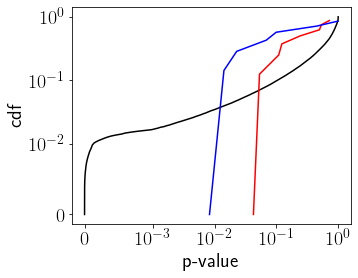

In [502]:
fig,axs=plt.subplots(figsize=(5,4))

skip = 100
pidx = 4

axs.plot(fcdf[0,::skip], fcdf[1,::skip],'k-')
axs.plot(pwaycdfsE[pidx][0], pwaycdfsE[pidx][1], 'r-')
axs.plot(pwaycdfsN[pidx][0], pwaycdfsN[pidx][1], 'b-')

#axs.set_xscale('log')
#axs.set_yscale('symlog',linthreshy=1e-4)

axs.set_xlabel('p-value')
axs.set_ylabel('cdf')

axs.set_xscale('symlog', linthreshx=1e-3)
axs.set_yscale('symlog', linthreshy=1e-2)
#axs.set_xscale('log')
#axs.set_xlim(xmin=1e-5,xmax=1.01)

mf.set_axs_fontsize(axs,20,False)

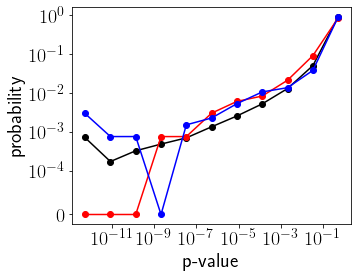

In [451]:
fig,axs=plt.subplots(figsize=(5,4))
binsx = 0.5*(bins[1:]+bins[:-1])
axs.plot(binsx,fhist/np.sum(fhist),'ko-')
axs.plot(binsx, pwayhistsE[0]/np.sum(pwayhistsE[0]), 'ro-')
axs.plot(binsx, pwayhistsN[0]/np.sum(pwayhistsN[0]), 'bo-')
axs.set_xscale('log')
axs.set_yscale('symlog',linthreshy=1e-4)

axs.set_xlabel('p-value')
axs.set_ylabel('probability')

mf.set_axs_fontsize(axs,20,False)

In [394]:
np.nanmax(tdepvs)

0.9999796276000112

In [396]:
np.nanmin(tdepvs)

6.699837902484565e-174

In [387]:
deEpid[1].shape

(6, 45660)

In [388]:
fig,axs=plt.subplots()

axs.hist(epidpvs)

/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6735: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6736: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1a18778200> (for post_execute):


KeyboardInterrupt: 

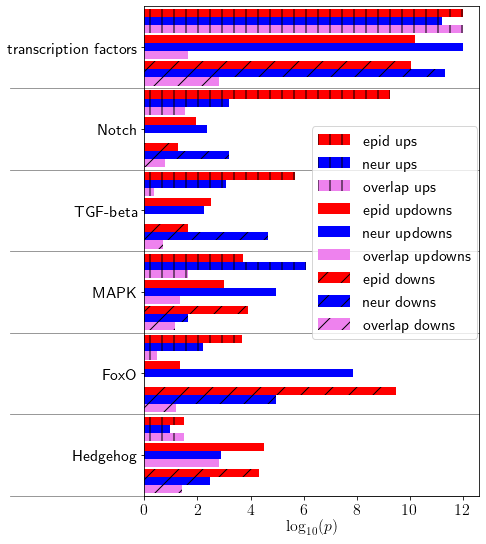

In [217]:
grpname = 'up_down_updown' #'signalling'#
nrow = len(sortz)
fig,axs=plt.subplots(1,1,figsize=(6,nrow*1.5))

cols = ['red','blue','violet']
hatches = ['|','','/']
barlabs = ['epid ups', 'neur ups', 'overlap ups',
           'epid updowns','neur updowns','overlap updowns',
           'epid downs','neur downs','overlap downs']

ht = 0.1
offset = ht*(ngrp-1)/2.
offsets = [0.42,0.32,0.22,0.1,0,-0.1,-0.22,-0.32,-0.42] #offset-ht*np.arange(ngrp)
for i in range(ngrp):
    axs.barh(np.arange(nrow)+offsets[i],vals[sortz,i],height=0.1,
             color=cols[i%3], hatch=hatches[int(i/3)],#edgecolor='white',
             label=barlabs[i] if labs[i] else None)

axs.set_ylim(-0.5,nrow-0.5)
axs.set_yticks(np.arange(nrow))
axs.set_yticklabels(list(map(trimPway,labs[sortz]))) #labs[sortz])
for i in range(nrow):
    axs.axhline(y=i-0.5,xmin=-0.4,xmax=1,color='gray',clip_on=False,linewidth=0.8)

axs.set_xlabel('$\log_{10}(p)$')
axs.legend(loc=(0.5,0.32),fontsize=16)
mf.set_axs_fontsize(axs,16,False)
#plt.savefig('{0}/kegg_{1}_hg_pvals_epidNeurEarly_v_epidLate_v_epidUpdowns.jpg'.format(plotdir,grpname),bbox_inches="tight")
#plt.savefig('{0}/kegg_{1}_hg_pvals_nexc.jpg'.format(plotdir,grpname),bbox_inches="tight")



In [ ]:
#### geneGrps  = [lowPVneur[1], lowPVneur[2], lowPVepid[1], lowPVepid[2]]
geneGrps  = [lowPVneur[0],lowPVneur[1]]

deGenes   = np.array(list(set(mf.flatten2d(geneGrps))))

In [1507]:
diffE = np.diff(gtpmMu[0:6,deGenes],axis=0)
diffN = np.diff(gtpmMu[6:,deGenes],axis=0)
epidcorr = np.corrcoef(diffE)
neurcorr = np.corrcoef(diffN)

In [1508]:
neurcorr

array([[ 1.        , -0.2384072 ,  0.98872252,  0.94370358, -0.99042822],
       [-0.2384072 ,  1.        , -0.19245973,  0.06346979,  0.31907965],
       [ 0.98872252, -0.19245973,  1.        ,  0.93062817, -0.97381762],
       [ 0.94370358,  0.06346979,  0.93062817,  1.        , -0.90896802],
       [-0.99042822,  0.31907965, -0.97381762, -0.90896802,  1.        ]])

In [1509]:
diffE[0].dot(diffE[2])/(linalg.norm(diffE[0])*linalg.norm(diffE[2]))

0.9213743059063637

In [1510]:
epidcorr[0,2]

0.9214751193724575

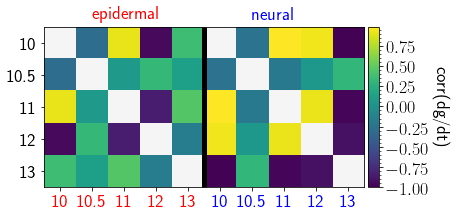

In [1512]:
fig,axs = plt.subplots(1,1,figsize=(6,3))

cmap = plt.get_cmap('viridis')
cmap.set_over('whitesmoke')  # Color for values less than vmin


tixx = stagestrs[1:]*2
tixy = stagestrs[1:]
dat = np.hstack([epidcorr,neurcorr])
im1 = axs.imshow(dat,vmin=-1,vmax=0.99, cmap=cmap)

axs.set_yticks(range(len(tixy)))
axs.set_yticklabels(tixy)

axs.set_xticks(range(len(tixx)))
axs.set_xticklabels(tixx)

axs.vlines(4.5, ymin=-0.5, ymax=len(tixy)-0.5,color = 'black', linewidth=5,clip_on=False)
#axs.hlines(4.5, xmin=-0.5, xmax=len(tix)-0.5,color = 'white', linewidth=5,clip_on=False)

my_colors = ['r']*5+['b']*5

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
# for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), my_colors):
#     ticklabel.set_color(tickcolor)


divider = make_axes_locatable(axs)
cax2     = divider.append_axes("right", size="3.5%", pad=0.05)

cbar = fig.colorbar(im1, cax=cax2)
cbar.set_label('corr(dg/dt)',rotation=270, labelpad=20)
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_ticks_position('top')
cax2.minorticks_on()


axs.text(s='epidermal',x=1,y=-0.75,color='r',fontsize=18)
axs.text(s='neural',x=6,y=-0.75,color='b',fontsize=18)


mf.set_axs_fontsize(axs,18)
mf.set_axs_fontsize(cax2,18)

#plt.savefig()

In [1517]:
# separating out cohorts -- is there a cohort of genes that give a parabola as its first PC?
geneGrps  = lowPVepid #+ lowPVneur

In [1518]:
gctsMu.shape

(12, 49112)

In [202]:
len(neurDowns),len(epidDowns),len(neurUps),len(epidUps)

NameError: name 'neurDowns' is not defined

In [65]:
len(np.intersect1d(neurDowns,epidDowns)), len(np.intersect1d(neurUps,epidUps))

(485, 470)

In [ ]:
len(np.intersect(1d))

In [219]:
pcslist = []
projlist = []
allidxs = list(range(gctsF.shape[1]))

idxLists     = [epidUpdowns, neurUpdowns]
inSampList   = [np.arange(18),np.arange(18,36)]
outSampList  = list(reversed(inSampList))

for i in range(len(idxLists)):
    idxs     = idxLists[i]
    gdatsK   = gctsF[inSampList[i]][:,idxs]+0.5

    lgdats   = np.log10(gdatsK.T)
    ngenes   = lgdats.shape[0]
    mus      = lgdats.mean(axis=1)
    lgdatsfz = (lgdats.T-mus)#/sigs

    gpca    = linalg.svd(lgdatsfz, full_matrices = False)
    eigs    = gpca[1]**2/ngenes
    pcslist.append(lgdatsfz.dot(gpca[2].T))
    
    # projection onto other condition
    gdatsK   = gctsF[outSampList[i]][:,idxs]+0.5

    lgdats   = np.log10(gdatsK.T)
    ngenes   = lgdats.shape[0]
    mus      = lgdats.mean(axis=1)
    lgdatsfz = (lgdats.T-mus)#/sigs
    projlist.append(lgdatsfz.dot(gpca[2].T))


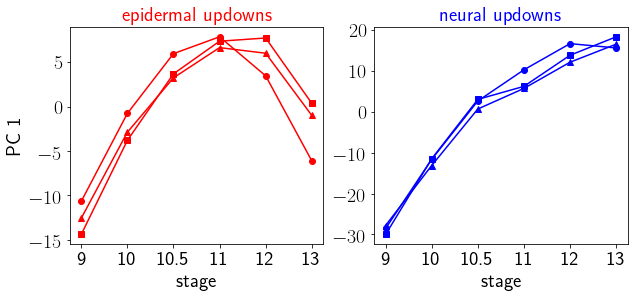

In [220]:
 
#plt.savefig('{0}/temporal_deseq_updowns_pc1_noproj.jpg'.format(plotdir),bbox_inches='tight')

In [1627]:
epidUpdownTFs = set(epidUpdowns).intersection(tfidxs)
neurUpdownTFs = set(neurUpdowns).intersection(tfidxs)

In [1629]:
len(neurUpdownTFs),len(epidUpdownTFs)

(57, 29)

In [1542]:
# PCA on the updowns
gtpm
#############################################CENTERING#########################################
# data needs to be centered across samples for proper SVD-ing [although maybe not in sklearn] #

##### Union of all reps ####
lgdatsf  = lgdats.transpose(1,0,2).reshape(lgdats.shape[1],lgdats.shape[0]*lgdats.shape[2])
mus      = lgdatsf.mean(axis=1)
sigs     = lgdatsf.std(axis=1,ddof=1)
lgdatsfz = (lgdatsf.T-mus)/sigs

##### Union of all reps ####
gdatsf  = gdatsNZ.transpose(1,0,2).reshape(gdatsNZ.shape[1],gdatsNZ.shape[0]*gdatsNZ.shape[2])
mus     = gdatsf.mean(axis=1)
sigs    = gdatsf.std(axis=1,ddof=1)
lgdatsfz = (gdatsf.T-mus)/sigs

1406

In [1533]:
updowns.shape[0]

580

In [1718]:
gene2go = {} 

def make_gene2go(): 
    infile = open('{0}/GeneGoTerms.txt'.format(datdir),'r')
    for line in infile:
        terms = line.rstrip().split('\t')
        gene2go[terms[2]] = gene2go.get(terms[2],[]) + terms[3].split(',')

In [1723]:
import obonet

In [1727]:
import networkx as nx

In [1728]:
graph=obonet.read_obo('{0}/go-basic.obo'.format(datdir))
graphdat = graph.nodes(data=True)

In [1745]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

In [1746]:
nx.MultiDiGraph

networkx.classes.multidigraph.MultiDiGraph

In [1731]:
gene2go['myc']

['GO:0000122',
 'GO:0000978',
 'GO:0001228',
 'GO:0003677',
 'GO:0003700',
 'GO:0005634',
 'GO:0008284',
 'GO:0045944',
 'GO:0046983']

In [1741]:
['transcription factor' in graphdat[go]['name'] for go in gene2go['myc']]

[False, False, False, False, True, False, False, False, False]

In [1719]:
infile = open('{0}/GeneGoTerms.txt'.format(datdir),'r')

lines=infile.readlines()

In [1716]:
terms=lines[0].rstrip().split('\t')

In [1720]:
make_gene2go()

In [1771]:
sum([1,0,1])

2

In [1779]:
'GO:0004702' in xdg.go_graph

False

In [1782]:
xdg.go_graph.isdisjoint

{'name': 'mitochondrial genome maintenance',
 'namespace': 'biological_process',
 'def': '"The maintenance of the structure and integrity of the mitochondrial genome; includes replication and segregation of the mitochondrial chromosome." [GOC:ai, GOC:vw]',
 'is_a': ['GO:0007005']}

In [1795]:
gene2goName = {}
tfstr = 'ranscription factor'
tfs2 = [idx for idx in range(gnmsS.shape[0]) 
        if sum([int(tfstr in goname) 
                for goname in [xdg.go_graph[go]['name'] 
                               if go in xdg.go_graph else []
                               for go in xdg.gene2go.get(gnmsS[idx],[])
                              ]
               ])>0]

In [1811]:
gotfs = set(['GO:0003700'])
gotfs = set(['GO:0003700','GO:0000130', 'GO:0001071', 'GO:0001130', 'GO:0001131', 'GO:0001151','GO:0001199', 'GO:0001204','GO:0140110'])


In [1819]:
goIsaGraph = nx.DiGraph()

In [1825]:


#self.xao_graph_dat = self.xao_graph.nodes(data=True)


In [1954]:
tfgos

{'GO:0000981',
 'GO:0001216',
 'GO:0001217',
 'GO:0001227',
 'GO:0001228',
 'GO:0003700',
 'GO:0004879',
 'GO:0034246',
 'GO:0098531'}

In [1895]:
nx.shortest_path(isago_graph,gotf,gotf)

['GO:0003677']

In [1920]:
missing=list(tfidxs-set(tfs3))

In [1921]:
len(missing)

115

In [1923]:
gnmsS[missing[3]]

'sra1.L'

In [1924]:
xdg.gene2go[rmsl(gnmsS[missing[3]])]

['GO:0060047', 'GO:0005634', 'GO:2000273', 'GO:0006357', 'GO:0030374']

In [1944]:
idx=missing[9]
gnmsS[idx],xdg.gene2func[rmsl(gnmsS[idx])]

# reasons for ommission:
# synonyms in the gene2func file
# zinc-ion binding go term (GO:0008270)
# no go terms, but still functionally labeled in xenbase as TF
# weird synonyms that don't have the go terms (e.g., xvent-2b for ventx2.1)

('pias3.S', ['zinc finger transcription factor'])

In [1942]:
missingReasons = [(gnmsS[idx],xdg.gene2func[rmsl(gnmsS[idx])]) for idx in missing]

In [1946]:
xdg.gene2go['xvent-2b']

KeyError: 'xvent-2b'

In [1943]:
missingReasons

[('t.L', ['nuclear transcription factor']),
 ('t.S', ['nuclear transcription factor']),
 ('t2.S', ['T-box transcription factor']),
 ('sra1.L', ['HMG-box transcription factor', 'p53 inducible protein PIR121']),
 ('sra1.S', ['HMG-box transcription factor', 'p53 inducible protein PIR121']),
 ('pias1.L', ['zinc finger transcription factor']),
 ('pias1.S', ['zinc finger transcription factor']),
 ('pias2.L', ['zinc finger transcription factor']),
 ('pias3.L', ['zinc finger transcription factor']),
 ('pias3.S', ['zinc finger transcription factor']),
 ('pias4.L', ['zinc finger transcription factor']),
 ('srebf1.S', ['transcription factor']),
 ('pias4.S', ['zinc finger transcription factor']),
 ('nsep1', ['transcription factor']),
 ('ski.L', ['transcription factor']),
 ('ski.S', ['transcription factor']),
 ('deltaef1', ['homeodomain transcription factor']),
 ('msc.S', ['transcription factor']),
 ('scx.L', ['transcription factor']),
 ('scx.S', ['transcription factor']),
 ('gabpb1.L', ['transcrip

In [1941]:
[(idx,gnmsS[idx]) for idx in missing]

[(46087, 't.L'),
 (46088, 't.S'),
 (46089, 't2.S'),
 (45581, 'sra1.L'),
 (45582, 'sra1.S'),
 (41491, 'pias1.L'),
 (41492, 'pias1.S'),
 (41493, 'pias2.L'),
 (41494, 'pias3.L'),
 (41495, 'pias3.S'),
 (41496, 'pias4.L'),
 (45593, 'srebf1.S'),
 (41497, 'pias4.S'),
 (40489, 'nsep1'),
 (44585, 'ski.L'),
 (44586, 'ski.S'),
 (33324, 'deltaef1'),
 (39471, 'msc.S'),
 (44084, 'scx.L'),
 (44085, 'scx.S'),
 (35386, 'gabpb1.L'),
 (35387, 'gabpb1.S'),
 (38464, 'lsf'),
 (46146, 'taf11.S'),
 (30791, 'btf3.L'),
 (30792, 'btf3l4.L'),
 (30793, 'btf3l4.S'),
 (33867, 'ecd.S'),
 (46166, 'taf8.S'),
 (36440, 'hes3.3.L'),
 (32870, 'ctbp2.S'),
 (32878, 'ctdp1.L'),
 (32879, 'ctdp1.S'),
 (29296, 'aff2.L'),
 (41076, 'pax4.L'),
 (31864, 'cebpz.L'),
 (31865, 'cebpz.S'),
 (34946, 'ferd3l.L'),
 (40068, 'neurog1.L'),
 (40069, 'neurog2.L'),
 (40070, 'neurog2.S'),
 (40071, 'neurog3.L'),
 (40072, 'neurog3.S'),
 (32417, 'cnot4.L'),
 (39609, 'mxi1.L'),
 (39610, 'mxi1.S'),
 (36548, 'hltf.L'),
 (46278, 'tbx21.L'),
 (42194, 'pr

In [1886]:
len(tfidxs),len(tfs3)

(919, 1197)

In [1897]:
gene2go['meis1']

['GO:0000082',
 'GO:0001525',
 'GO:0001885',
 'GO:0001947',
 'GO:0003677',
 'GO:0005634',
 'GO:0005829',
 'GO:0006355',
 'GO:0009880',
 'GO:0030223',
 'GO:0030225',
 'GO:0035476',
 'GO:0035907',
 'GO:0045766',
 'GO:0048703',
 'GO:0048844',
 'GO:0050821',
 'GO:0060059',
 'GO:0060216',
 'GO:0060319',
 'GO:0060841',
 'GO:0072554']

In [1877]:
x='GO:0006355';
gotf = 'GO:0010468';

In [1878]:
for x in gene2go['ventx1.1.L']:
    try:
        nx.shortest_path(isago_graph,x,gotf)
        print(x)
    except nx.NetworkXException:
        print('nope')

GO:0000122
nope
nope
GO:0030509
nope
nope
nope
GO:0045892
nope
nope


In [72]:
pway2gene = mf.reverseDictList(kdg.gene2pway)

In [73]:
gnmsL = set([x.lower() for x in gnmsS])

In [ ]:
pway2gene['Fo']

In [75]:
# printing pathway genes
pway = 'FoxO signaling pathway'
x = set(pway2gene[pway]).intersection(gnmsL)
xd = {}
for i in x:
    ip = rmsl(i)
    xd[ip] = xd.get(ip,[])+[i]
for k in sorted(xd.keys()):
    if len(xd[k]) == 2:
        print(k+'.*')
    else:
        for v in xd[k]:
            print(v)

akt1.s
akt2.l
araf.*
atg12.s
atm.l
bcl2l11.*
bcl6.*
bnip3.s
braf.*
cat.1.l
cat.2.l
ccnb1.*
ccnb1.2.s
ccnb2.*
ccnb3.*
ccnd1.*
ccnd2.*
ccndx.s
ccng2.*
cdk2.*
cdkn1a.l
cdkn1b.s
cdkn2b.l
cdkn2d.*
chuk.s
crebbp.*
csnk1e.l
egfr.*
faslg.l
fbxo25.l
foxg1.*
foxo1.l
foxo3.l
foxo4.l
foxo6.*
g6pc.*
g6pc2.s
gabarap.l
gabarapl1.s
gabarapl1-b
gabarapl2.l
gadd45a.l
gadd45b.s
gadd45g.*
grb2.*
homer1.l
homer2.*
homer3.*
hras.l
igf1.s
igf1r.s
ikbkb.l
ins.*
insr.l
irs1.s
irs4.*
klf2.*
kras.s
loc100125664
loc100145045.l
map2k1.*
mapk1.*
mapk10.l
mapk11.s
mapk12.s
mapk14.s
mapk8.l
mdm2.l
nlk.l
nlk.2.s
nras.l
pck1.s
pck2.s
pdpk1.*
pik3ca.l
pik3cb.*
pik3r1.*
pik3r3.l
plk1.s
plk2.*
plk3.*
plk4.*
prkaa1.l
prkab1.s
prkab2.*
prkag1.s
prkag2.l
prkag3.s
prmt1.*
pten.*
raf1.s
rag1.l
rag2.s
ralb
s1pr1.*
s1pr4.l
sgk1.*
sgk3.*
sirt1.*
skp2.l
slc2a4.l
smad2.s
smad3.l
smad4.1.l
smad4.2.*
sod2.s
sos1.*
sos2.*
stat3.1.l
stat3.2.l
stk11.*
stk4.s
tgfb1.*
tgfb2.*
tgfbr1.s
tgfbr2.*
tgfbr2.2.l
tnfsf10.s
usp7.*


In [86]:
tpmNZmin = np.sort(np.unique(gtpm))[0:5][1]

In [87]:
tsum = np.sum(gtpm,axis=2)
tsumMax = np.max(tsum.reshape(6,-1),axis=0)
tpmThIdxs = np.where(tsumMax>3)[0]

In [88]:
tMax = np.max(gtpmf,axis=0)
tpmThIdxs = np.where(tMax>0.5)[0]

In [89]:
len(tpmThIdxs)

27755

In [81]:
#gdatsK   = gctsF[inSampList[i]][:,idxs]+0.5

lgdats   = np.log10(gctsF.T + 0.5)
lgdats   = np.log10(gtpmf.T + tpmNZmin/2)#[tpmThIdxs]
ngenes   = lgdats.shape[0]
mus      = lgdats.mean(axis=1)
lgdatsfz = (lgdats.T-mus)#/sigs

gpca    = linalg.svd(lgdatsfz, full_matrices = False)
eigs    = gpca[1]**2/ngenes
pcs     = lgdatsfz.dot(gpca[2].T)
#pcslist.append()

In [94]:
def logCenPca(dat,minval):
    lgdats   = np.log10(dat.T + minval)#[tpmThIdxs]
    ngenes   = lgdats.shape[0]
    mus      = lgdats.mean(axis=1)
    lgdatsfz = (lgdats.T-mus)#/sigs

    gpca    = linalg.svd(lgdatsfz, full_matrices = False)
    eigs    = gpca[1]**2/ngenes
    pcs     = lgdatsfz.dot(gpca[2].T)
    return pcs, gpca[2]

In [99]:
pcs.shape

(3, 18, 18)

In [357]:
# epidermal
gtpmfE   = gtpmf[0:18]

lgdats   = np.log10(gtpmfE.T + tpmNZmin/2)#[tpmThIdxs]
ngenes   = lgdats.shape[0]
mus      = lgdats.mean(axis=1)
lgdatsfz = (lgdats.T-mus)#/sigs

gpcaE     = linalg.svd(lgdatsfz, full_matrices = False)
eigs      = gpcaE[1]**2/ngenes
pcsE      = lgdatsfz.dot(gpcaE[2].T)

# neural
gtpmfN   = gtpmf[18:36]

lgdats   = np.log10(gtpmfN.T + tpmNZmin/2)#[tpmThIdxs]
ngenes   = lgdats.shape[0]
mus      = lgdats.mean(axis=1)
lgdatsfz = (lgdats.T-mus)#/sigs

gpcaN     = linalg.svd(lgdatsfz, full_matrices = False)
eigs      = gpcaN[1]**2/ngenes
pcsN      = lgdatsfz.dot(gpcaN[2].T)

In [ ]:
for i in range(0,54,18):
    

In [379]:
pcsNfE = lgdatsfz.dot(gpcaE[2].T)
pcsNfE2 = np.array(np.split(pcsNfE[:,1],3))

In [360]:
#pc1 = np.split(pcs[:,0],6)
#pc2 = np.split(pcs[:,1],6)
pc1 = np.vstack([np.split(pcsE[:,0],3),np.split(pcsN[:,0],3)])
pc2 = np.vstack([np.split(pcsE[:,1],3),np.split(pcsN[:,1],3)])

In [361]:
pc1.shape

(6, 6)

In [285]:
pcs = np.array([logCenPca(gtpmf[i:i+18],tpmNZmin/2)[0] for i in range(0,54,18)])

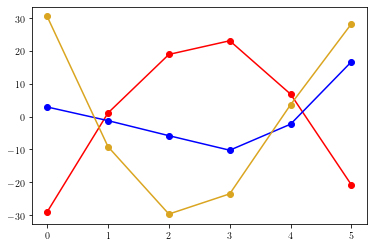

In [305]:
pcmus = np.array([np.mean(np.array(np.split(pcs[i,:,1],3)),axis=0) for i in range(3)])
fig,axs=plt.subplots()
cols = ['red','blue','goldenrod']
for i in range(3):
    axs.plot(range(6),pcmus[i],'o-',color=cols[i])

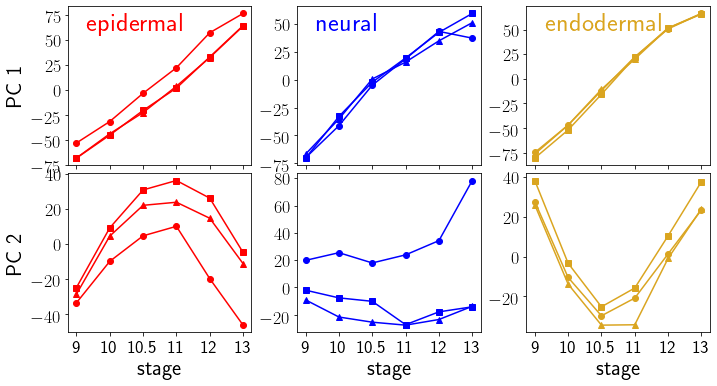

In [289]:
fig,axs=plt.subplots(2,3,figsize=(11.5,6))

stagestrs = [9,10,10.5,11,12,13]
nstages = len(stagestrs)
ts = np.arange(nstages)

marks = ['o','s','^']
cols = ['red','blue','goldenrod']
labs = ['epidermal','neural','endodermal']
for rep in range(3):
    for cond in range(3):
        for p in range(2):
            axs[p,cond].plot(ts,pcs[cond,rep*6:(rep+1)*6,p],marker=marks[rep],color=cols[cond])

# axs[0,0].set_title('epidermal', color = 'r')
# axs[0,1].set_title('neural', color='b')
# axs[0,2].set_title('endodermal', color=cols[2])


for axi in axs:
    for axij in axi:
        mf.set_axs_fontsize(axij, 18)
        
for i in range(3):
    axs[0,i].set_xticks(ts)
    axs[0,i].set_xticklabels([])
    axs[1,i].set_xticks(ts)
    axs[1,i].set_xticklabels(stagestrs,fontsize=18)
    axs[1,i].set_xlabel('stage',fontsize=22)

axs[0,0].set_ylabel('PC 1', fontsize=22)
axs[1,0].set_ylabel('PC 2',fontsize=22)
plt.subplots_adjust(hspace=0.05,wspace=0.25)

for i in range(3):
    axs[0,i].text(s=labs[i],x=0.1,y=0.85,color=cols[i],transform=axs[0,i].transAxes,fontsize=26)

plt.savefig('{0}/temporal_pca_gtpm_th_sep3.pdf'.format(plotdir),bbox_inches='tight')


In [266]:
rngs = np.array([np.arange(18,36),np.arange(18),np.arange(36,54)])
pcs = np.array([logCenPca(gtpmf[i],tpmNZmin/2)[0] for i in rngs])

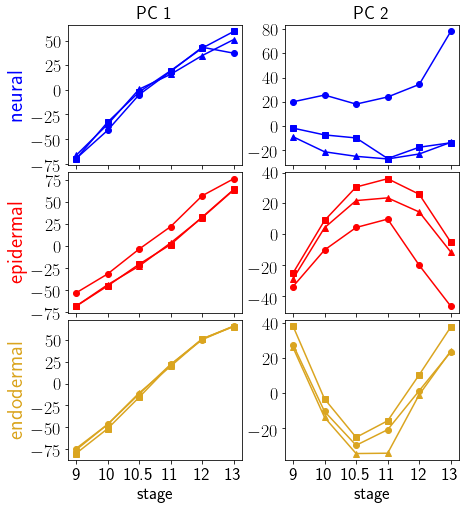

In [278]:
fig,axs=plt.subplots(3,2,figsize=(7,8))

stagestrs = [9,10,10.5,11,12,13]
nstages = len(stagestrs)
ts = np.arange(nstages)

marks = ['o','s','^']
cols = ['blue','red','goldenrod']
labs = ['neural','epidermal','endodermal']
for rep in range(3):
    for cond in range(3):
        for p in range(2):
            axs[cond,p].plot(ts,pcs[cond,rep*6:(rep+1)*6,p],marker=marks[rep],color=cols[cond])



axs[0,0].set_title('PC 1')
axs[0,1].set_title('PC 2')

for i in range(2):
    axs[0,i].set_xticks(ts)
    axs[1,i].set_xticks(ts)
    axs[2,i].set_xticks(ts)
    axs[0,i].set_xticklabels([])
    axs[1,i].set_xticklabels([])
    axs[2,i].set_xticklabels(stagestrs)
    axs[2,i].set_xlabel('stage')

plt.subplots_adjust(hspace=0.05,wspace=0.25)
for axi in axs:
    for axij in axi:
        mf.set_axs_fontsize(axij, 18)
        
for i in range(3):
    #axs[i,0].text(s=labs[i],x=0.1,y=0.8,color=cols[i],transform=axs[i,0].transAxes,fontsize=18)
    axs[i,0].set_ylabel(labs[i],color=cols[i],fontsize=22)


plt.savefig('{0}/temporal_pca_gtpm_th_sep3_vert.jpg'.format(plotdir),bbox_inches='tight')


In [370]:
np.mean(pc2[0:3],axis=0)

array([-29.19028817,   1.09529903,  19.00371319,  23.18716421,
         6.84850354, -20.9443918 ])

In [382]:
np.mean(pcsNfE2,axis=0)

array([-33.46005698, -10.15898606,   7.2479144 ,  12.66874052,
        16.32924589,   7.37314223])

In [402]:
np.nan<0.01

False

In [403]:
threshs = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2]
#lowPVneurGns = [[lowpvalidxs(neurpvs[i],thresh) for i in range(len(stagestrs)-1)] for thresh in threshs]
#lowPVepidGns = [[lowpvalidxs(epidpvs[i],thresh) for i in range(len(stagestrs)-1)] for thresh in threshs]

lowPVidxs = [[[np.where(tDEpvs2[i,j]<thresh)  for thresh in threshs] 
              for j in range(len(stgs)-1)] for i in range(tDEpvs.shape[0])]


/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [419]:
lowPVidxs[0][0][0][0].shape

(1547,)

In [425]:
tDEpvs2[0,0,lowPVidxs[0][0][0][0]]

array([9.66802636e-04, 1.57608185e-10, 1.84393576e-05, ...,
       1.75817651e-04, 9.65896296e-04, 1.99067776e-05])

In [424]:
hgpv(tDEpvs2[0,0,lowPVidxs[0][0][0][0]],'BMP signaling pathway')

1.0

In [491]:
eps      = 10**-12
bmp_hg = -np.log10(np.array([[[hgpv(lowPVidxs[i][j][t][0],'TGF-beta original signaling pathway') for t in range(len(threshs))]
           for j in range(len(stgs)-1)] for i in range(tDEpvs.shape[0])])+eps)

In [492]:
bmp_hg_mu = np.mean(bmp_hg,axis=2)
bmp_hg_err = np.std(bmp_hg,axis=2)/np.sqrt(len(threshs))

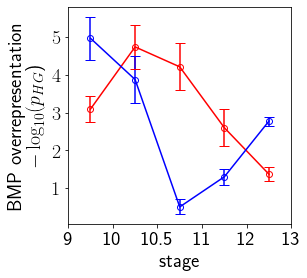

In [511]:
fig,axs=plt.subplots(1,1,figsize=(4,4))
ts = np.arange(5)+0.5
labs = ['epidermal','neural','endodermal']
cols = ['red','blue','goldenrod']
for i in range(2):
    axs.errorbar(ts,bmp_hg_mu[i],yerr=bmp_hg_err[i],
            color=cols[i],marker='o',capsize=5, label=labs[i], fillstyle='none')
axs.set_xlabel('stage')
axs.set_xticks(range(6))
axs.set_xticklabels(stagestrs)

#axs.legend(fontsize=17,frameon=False,loc=(0.46,0.78),labelspacing=0.1)
    
mf.set_axs_fontsize(axs,20,False)
axs.set_ylabel('BMP overrepresentation\n$-\log_{10}(p_{HG}$)')
plt.savefig('{0}/BMP-TGF_overrep_err.jpg'.format(plotdir),bbox_inches="tight")

In [26]:
pway = 'BMP signaling pathway'
pwaynm = trimPway(pway)
sigs = [pway, pway + nontfstr, pway + tfstr]
pvTrajE = np.array([[keggPvsEpid[i][sig] for i in range(nt)] for sig in sigs])
pvTrajN = np.array([[keggPvsNeur[i][sig] for i in range(nt)] for sig in sigs])
trajs = [pvTrajE, pvTrajN]



fig,axs=plt.subplots(1,2,figsize=(10,4))
cols = ['red', 'blue']

for i in range(2):
    axs[i].plot(ts, trajs[i][0], 'o-', c = cols[i], label = 'all')
    axs[i].plot(ts, trajs[i][1], 's-', c = cols[i], label = 'signaling')
    axs[i].plot(ts, trajs[i][2], '^-', c = cols[i], label = 'TFs')
    axs[i].set_xlabel('stage')
    axs[i].set_xticks(range(6))
    axs[i].set_xticklabels(stagestrs)
    
    axs[i].set_ylim(0,7.9)

axs[1].legend()

axs[0].set_ylabel('{0} overrepresentation'.format(pwaynm))

axs[1].set_yticklabels([])

mf.set_axs_fontsize(axs[0], 20, False)
mf.set_axs_fontsize(axs[1], 20, True)

plt.subplots_adjust(wspace=0.07)


(3, 5, 45660)

In [50]:
nlowPV = np.array([[[len(lowPVidxs[i][j][k]) for k in range(len(threshs))] 
                    for j in range(len(stgs)-1)] for i in range(len(samps))])
nlowCtMeans = np.mean(nlowPV, axis=2)
nlowCtErrs = np.std(nlowPV,axis=2)/np.sqrt(len(threshs))

In [48]:
len(lowPVidxs[0][0])

8

In [755]:
gnmsS[unannotatedIdxs[4074]]

'LOC108710896'

In [694]:
gnmsS[unannotatedIdxs]

(18641,)

In [52]:
endIdxs = np.array(list(set(lowPVidxs[2][0][5])-set(lowPVidxs[1][0][5])-set(lowPVidxs[0][0][5])))

endIdxs = np.array(list(set(lowPVidxs[2][0][5]).intersection(set(lowPVidxs[0][0][5]))-set(lowPVidxs[1][0][5])))

endIdxs = np.array(list(set(lowPVidxs[0][3][5]).intersection(set(lowPVidxs[2][1][5]))))

In [53]:
eidxs2 = np.setdiff1d(endIdxs,np.where(gnumlens>4)[0])

In [54]:
gctsMu.shape

(18, 45660)

In [56]:
tDEpvs.shape

(3, 5, 45660)

In [58]:
nms = gnmsS[eidxs2]

# epidermis 11-12
sgns1 = np.sign(gctsMu[4,eidxs2]-gctsMu[3,eidxs2])
pvs1 = tDEpvs[0,3,eidxs2]

# endoderm 10-10.5
sgns2 = np.sign(gctsMu[14,eidxs2]-gctsMu[13,eidxs2])
pvs2 = tDEpvs[2,1,eidxs2]

mydat = np.array([nms,pvs1,pvs2,sgns1,sgns2]).T
np.savetxt('{0}/endoderm10-105_epiderm11-12lowpvGenes.tsv'.format(datdir),mydat,fmt='%s',delimiter='\t')


In [35]:
sgns = np.sign(gctsMu[13,eidxs2]-gctsMu[12,eidxs2])
eidxsUp = eidxs2[np.where(sgns > 0)[0]]
eidxsDn = eidxs2[np.where(sgns < 0)[0]]

In [39]:
idxs = eidxsUp
gnms = gnmsS[idxs]
pvs = tDEpvs[2,0,idxs]
sort = np.argsort(gnms)
#sort = np.argsort(pvs)
mydat = np.array([gnms,pvs]).T[sort]
np.savetxt('{0}/endoderm10-105_epiderm11-12lowpvGenesUpA-z.tsv'.format(datdir),mydat,fmt='%s',delimiter='\t')

In [325]:
np.savetxt('{0}/endoderm9-10lowpvGenes.tsv'.format(datdir),gnmsS[endIdxs],fmt='%s')
np.savetxt('{0}/endoderm9-10lowpvs.tsv'.format(datdir),tDEpvs[2,0,endIdxs])

In [322]:
endIdxsNms = gnmsS[endIdxs]

In [ ]:
[i for i in endIdxs if not(gnmsS[i].startswith('Xaelev') ]

In [ ]:
endIdxPvs = tDEpvs[2,0,endIdxs]

In [333]:
def overlapFrac(i,j):
    g1 = lowPVneurGns[i][j]
    g2 = lowPVepidGns[i][j]
    nOver = np.intersect1d(g1,g2).shape[0]
    return nOver/g1.shape[0],nOver/g2.shape[0],nOver

In [334]:
ovFs = np.array([[overlapFrac(i,j) for j in range(len(stagestrs)-1)] for i in range(len(threshs))])


In [331]:
nNeur = np.array([[len(lowPVneurGns[i][j]) for j in range(len(stagestrs)-1)] 
         for i in range(len(threshs))])
nEpid = np.array([[len(lowPVepidGns[i][j]) for j in range(len(stagestrs)-1)] 
         for i in range(len(threshs))])

neurCtMean = np.mean(nNeur,axis=0)
neurCtErr  = np.std(nNeur, axis = 0)/np.sqrt(len(threshs))

epidCtMean = np.mean(nEpid,axis=0)
epidCtErr  = np.std(nEpid, axis = 0)/np.sqrt(len(threshs))


In [29]:
#lowPVtotCts = lowPVneurCts + lowPVepidCts

In [30]:
#neurCtFracs = lowPVneurCts/lowPVtotCts
#epidCtFracs = lowPVepidCts/lowPVtotCts

In [335]:
neurCtFracMean = np.mean(ovFs[...,0],axis=0)
neurCtFracErr  = np.std(ovFs[...,0], axis = 0)/np.sqrt(len(threshs))

epidCtFracMean = np.mean(ovFs[...,1],axis=0)
epidCtFracErr  = np.std(ovFs[...,1], axis = 0)/np.sqrt(len(threshs))

noverlapMean = np.mean(ovFs[...,2],axis=0)
noverlapErr  = np.std(ovFs[...,2], axis = 0)/np.sqrt(len(threshs))


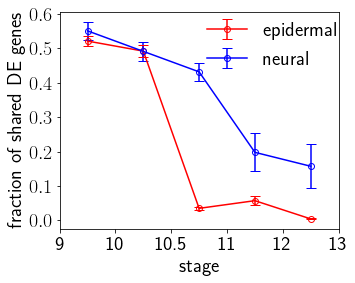

In [56]:
fig,axs=plt.subplots(1,1,figsize=(5,4))

# axs.plot(np.arange(1,6)-0.5,nloEpid[5],'s-',label='epidermal', color='red',fillstyle='none')
# axs.plot(np.arange(1,6)-0.5,nloNeur[5],'s-',label='neural',color='blue',fillstyle='none')

axs.errorbar(np.arange(5)+0.5,epidCtFracMean,yerr=epidCtFracErr,
            color='r',marker='o',capsize=5, label='epidermal', fillstyle='none')
axs.errorbar(np.arange(5)+0.5,neurCtFracMean,yerr=neurCtFracErr,
            color='b',marker='o',capsize=5, label='neural', fillstyle='none')

axs.set_xlabel('stage')
axs.set_xticks(range(6))
axs.set_xticklabels(stagestrs)
#axs.set_ylabel('avg num DESeq genes') # ($p<0.05$)')
axs.set_ylabel('fraction of shared DE genes')

#axs.set_yscale('log')

mf.set_axs_fontsize(axs,20,True)
axs.legend(loc=(0.5,0.7),fontsize=20,frameon=False)

plt.savefig('{0}/de_overlap_frac_err.jpg'.format(plotdir),bbox_inches='tight')


In [122]:
from matplotlib_venn import venn2,venn3

In [123]:
threshs[5]

0.05

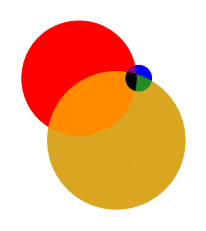

In [283]:
fig,axs=plt.subplots()
t=4 # stage idx
th = 5 # threshhold index
# # First way to call the 2 group Venn diagram:
# venn2(subsets = (10, 5, 2), set_labels = ('Group A', 'Group B'))
# plt.show()
 
# Second way
#venn2([set(['A', 'B', 'C', 'D']), set(['D', 'E', 'F'])])
v=venn3([set(lowPVidxs[0][t][th]),set(lowPVidxs[1][t][th]),set(lowPVidxs[2][t][th])], 
        set_labels=None, normalize_to=1)

cols = ['red','blue','goldenrod','purple','darkorange','forestgreen','black']

fss = [24]*7#,24,24,24,24,24,24]
#fss = [24,12,24,12,24,12,12]
#fss = [24,10,24,10,24,10,10]
fss = [0]*7

for i,p in zip(range(7),['100','010','001','110','101','011','111']):
    v.get_patch_by_id(p).set_alpha(1)
    v.get_patch_by_id(p).set_color(cols[i])
    v.get_label_by_id(p).set_fontsize(fss[i])
    v.get_label_by_id(p).set_color('white')
    #v.get_label_by_id(p).set_rotation(90)


plt.savefig('{0}/de_overlap_venn3_t{1}_nonums.eps'.format(plotdir,t),bbox_inches='tight')


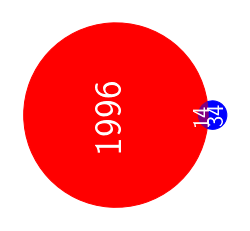

In [386]:
fig,axs=plt.subplots()
t=4
# # First way to call the 2 group Venn diagram:
# venn2(subsets = (10, 5, 2), set_labels = ('Group A', 'Group B'))
# plt.show()
 
# Second way
#venn2([set(['A', 'B', 'C', 'D']), set(['D', 'E', 'F'])])
v=venn2([set(lowPVepidGns[5][t]),set(lowPVneurGns[5][t])], set_labels=None, normalize_to=1)

cols = ['red','blue','purple']

fss = [40,24,24]

for i,p in zip(range(3),['10','01','11']):
    v.get_patch_by_id(p).set_alpha(1)
    v.get_patch_by_id(p).set_color(cols[i])
    v.get_label_by_id(p).set_fontsize(fss[i])
    v.get_label_by_id(p).set_color('white')
    v.get_label_by_id(p).set_rotation(90)


plt.savefig('{0}/de_overlap_venn_t{1}.jpg'.format(plotdir,t),bbox_inches='tight')


    
#plt.show()


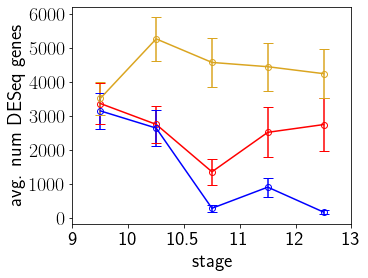

In [233]:
fig,axs=plt.subplots(1,1,figsize=(5,4))

cols = ['red','blue','goldenrod']
nms = ['epidermal','neural','endodermal']
for i in range(3):
    axs.errorbar(np.arange(5)+0.5,nlowCtMeans[i],yerr=nlowCtErrs[i],
            color=cols[i],marker='o',capsize=5, label=nms[i], fillstyle='none')
# axs.errorbar(np.arange(5)+0.5,epidCtMean,yerr=epidCtErr,
#             color='r',marker='o',capsize=5, label='epidermal', fillstyle='none')
# axs.errorbar(np.arange(5)+0.5,neurCtMean,yerr=neurCtErr,
#             color='b',marker='o',capsize=5, label='neural', fillstyle='none')

# axs.errorbar(np.arange(5)+0.5,noverlapMean,yerr=noverlapErr,
#             color='k',marker='s',capsize=5, label='neural', fillstyle='none',linestyle='--')


axs.set_xlabel('stage')
axs.set_xticks(range(6))
axs.set_xticklabels(stagestrs)
#axs.set_ylabel('avg num DESeq genes') # ($p<0.05$)')
axs.set_ylabel('avg. num DESeq genes')

#axs.set_yscale('log')
#axs.legend(loc=(1.01,0.5),fontsize=20)
mf.set_axs_fontsize(axs,20,False)
#loc=(0.5,0.7),fontsize=20,frameon=False)
plt.savefig('{0}/de_avg_cts3.eps'.format(plotdir),bbox_inches='tight')



In [148]:
nne = np.array(list(map(len,lowPVne)))

In [173]:
gtpms = np.sum(gtpm,axis=1)

In [174]:
gtpms.shape

(2, 6, 45660)

In [176]:
rep = 2
neu = [np.sum(gtpms[0,t,lowPVne[t]]>gtpms[1,t,lowPVne[t]]) for t in range(nt+1)]

In [178]:
nnu = nne - neu

In [181]:
nnu,neu

(array([ 265,  245,  639, 1578, 3324, 2532]),
 [196, 161, 542, 1243, 3079, 2044])

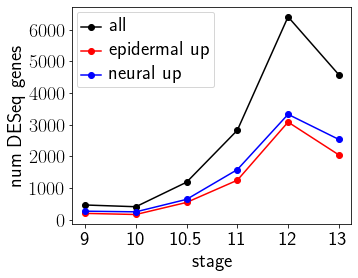

In [184]:
fig,axs=plt.subplots(1,1,figsize=(5,4))

axs.plot(np.arange(nt+1),nne,color='k',marker='o',label='all')
axs.plot(np.arange(nt+1),neu, color='r', marker = 'o',label='epidermal up')
axs.plot(np.arange(nt+1), nnu, color='b', marker='o', label='neural up')

axs.set_xlabel('stage')
axs.set_xticks(range(6))
axs.set_xticklabels(stagestrs)
#axs.set_ylabel('avg num DESeq genes') # ($p<0.05$)')
axs.set_ylabel('num DESeq genes')

#axs.set_yscale('log')

mf.set_axs_fontsize(axs,20,True)
plt.savefig('{0}/num_deseq_ne.png'.format(plotdir),bbox_inches='tight')

#axs.legend(loc=(0.5,0.7),fontsize=20,frameon=False)

In [30]:
revmap = {i:revdict[gnums[i]] for i in range(len(gnums)) if gnums[i] in revdict }

In [140]:
leftAlone = [k for k in revmap.keys() if revmap[k]==gnmsS[k]]
newlyAnnotated = [k for k in revmap.keys() if revmap[k]!=gnmsS[k]]

In [143]:
len(newlyAnnotated)

10489

In [141]:
revdict_r = {}
for k,v in revdict.items():
    revdict_r[v] = revdict_r.get(v,[])+[k]

In [ ]:
revdict['']

In [142]:
revdict_r['ifit5']

['108695772',
 '108705597',
 '108697460',
 '108697198',
 '495383',
 '108696188',
 '108695773',
 '108697458',
 '108696976',
 '108697203',
 '108705596',
 '108697199',
 '108696977',
 '108697201',
 '108697200',
 '108695768',
 '108695771',
 '108695769',
 '108697202',
 '108697459',
 '108695770']

In [135]:
'ifit5' in [k for k,v in revdict_r.items() if len(v)>1]

False

In [131]:
[(i,gnmsS[i],revmap[i]) for i in newlyAnnotated]

[(11, 'LOC100036800', 'cd63l.L'),
 (12, 'LOC100036800.S', 'cd63l.L'),
 (13, 'LOC100036803', 'mknk2.S'),
 (16, 'LOC100036824', 'ocm4.6.S'),
 (18, 'LOC100036831', 'arpc3'),
 (20, 'LOC100036845.L', 'LOC100036845'),
 (21, 'LOC100036869', 'vps37a.S'),
 (22, 'LOC100036872', 'was.S'),
 (23, 'LOC100036880', 'loc100170490.L'),
 (24, 'LOC100036883', 'krt20.L'),
 (26, 'LOC100036897', 'sult6b1l.L'),
 (27, 'LOC100036907.L', 'loc100036907.S'),
 (28, 'LOC100036910', 'casp3.2.L'),
 (30, 'LOC100036915', 'slc35b1.S'),
 (32, 'LOC100036932', 'mgc147475.S'),
 (33, 'LOC100036952', 'ppt1.S'),
 (36, 'LOC100036997', 'cyp4v2.2.L'),
 (37, 'LOC100037001', 'khdc4'),
 (38, 'LOC100037016', 'ifngr2'),
 (39, 'LOC100037047', 'loc100144919.L'),
 (40, 'LOC100037090', 'pef1.S'),
 (41, 'LOC100037108', 'snca'),
 (43, 'LOC100037145', 'rnf14.5.S'),
 (46, 'LOC100037191.L', 'cyp2a6.1.L'),
 (49, 'LOC100037213', 'loc734071.L'),
 (50, 'LOC100037217', 'loc100145107.L'),
 (51, 'LOC100037226', 'srp14'),
 (55, 'LOC100049113', 'dleu7.L

In [134]:
gnmsS[2176:2181], revdict['108697198']

(array(['LOC108697198', 'LOC108697199', 'LOC108697200', 'LOC108697201',
        'LOC108697202'], dtype='<U23'), 'ifit5[provLOC108697198]')

In [84]:
revmap = {}
for i in range(len(gnums)):
    for j in gnums[i]:
        if j in revdict:
            revmap[i] = revmap.get(i,[]) + [revdict[j].split('[')[0]]
    

In [87]:
np.where(np.array(list(map(len,revmap.values())))>1)

(array([], dtype=int64),)

In [68]:
gctsMuN = (gctsMu.T/np.linalg.norm(gctsMu,axis=1)).T

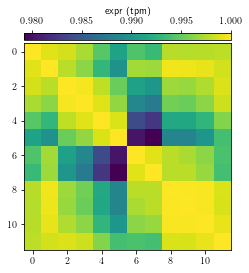

In [72]:
dps = gctsMuN.dot(gctsMuN.T)
fig,axs=plt.subplots()
im=axs.imshow(dps)
divider = make_axes_locatable(axs)
cax2     = divider.append_axes("top", size=0.1, pad=0.05)

cbar = fig.colorbar(im, cax=cax2,orientation='horizontal')
cbar.set_label('expr (tpm)',rotation=0, labelpad=2)
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_ticks_position('top')

In [191]:
# top 100 deseq genes between neural and epidermal at stages 10, 10.5, 11
minpvsMid = np.min(nepvs[2:5],axis=0)

top100idxs = np.argsort(minpvsMid)[0:100]

In [220]:
top100gnms = gnmsS[top100idxs]
gnmSort    = np.argsort(top100gnms)

# move unannotated to bottom
firstlowercaseIdx = np.where([gnm[0].islower() for gnm in top100gnms[gnmSort]])[0][0]
gnmSort           = np.hstack([gnmSort[firstlowercaseIdx:],gnmSort[:firstlowercaseIdx]])

gnSort  = top100idxs[gnmSort]

In [322]:
minpvpos = np.argmin(nepvs[2:5,gnSort],axis=0)

In [241]:
dat = gtpmMu[[1,2,3,7,8,9]][:,gnSort]

In [330]:
dat.shape

(6, 100)

In [354]:
sgns = [np.sign(dat[minpvpos[i]+3,i]-dat[minpvpos[i],i]) for i in range(dat.shape[1])]
fun = lambda i: minpvpos[i] if sgns[i] == -1 else minpvpos[i]+3
isDeIdxs = np.array(list(map(fun, range(len(minpvpos)))))

In [355]:
nonzeroMin = lambda a:np.min(a[np.where(a>0)])

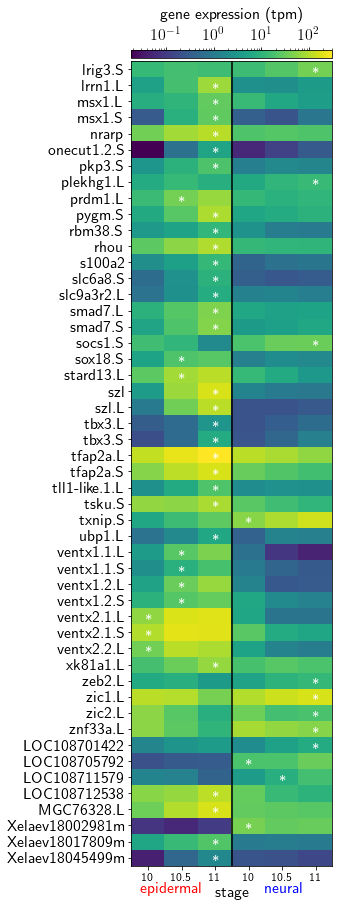

In [356]:
grptitle = 'top100ne'
ii=2
fac = 0.3
nper = 50
idxs = np.arange(0,nper)+nper*(i-1)

fig,axs=plt.subplots(1,1,figsize=(12*fac,len(idxs)*fac))
datS   = dat[:,idxs].T + nonzeroMin(dat)/2
im = axs.imshow(datS,aspect='auto',norm=matplotlib.colors.LogNorm())
axs.vlines(x=2.5,ymin=-0.5,ymax=len(idxs)-0.5)

for ridx,cidx in zip(range(nper),isDeIdxs[idxs]):
    axs.text(s=r'$\boldsymbol{*}$',x=cidx-0.1,y=ridx+0.25,color='white',size=13)#for jpg export

axs.set_yticks(range(len(idxs)))
axs.set_yticklabels(gnmsS[gnSort[idxs]])

axs.set_xticks(range(3*2))
axs.set_xlabel('stage',labelpad=2.3)

divider = make_axes_locatable(axs)
cax2     = divider.append_axes("top", size=0.1, pad=0.05)

cbar = fig.colorbar(im, cax=cax2,orientation='horizontal')
cbar.set_label('gene expression (tpm)',rotation=0, labelpad=10)
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_ticks_position('top')

axs.text(s='epidermal',y=len(idxs)+1.2,x=-0.25,color='red',size=16)
axs.text(s='neural',y=len(idxs)+1.2,x=3.5,color='blue',size=16)

axs.set_ylim(len(idxs)-0.5,-0.5)


mf.set_axs_fontsize(axs,16)
mf.set_axs_fontsize(cax2,16)
axs.set_xticklabels(stagestrs[1:4]*2,fontsize=12)

#ticks = np.power(10.,np.arange(0,3,1))
#cax2.yaxis.set_ticks(-np.log10(ticks))
#cax2.yaxis.set_ticklabels(ticks)
plt.savefig('{0}/{1}_genes_expr_p{2}_s.png'.format(plotdir,grptitle,ii),bbox_inches="tight")

In [316]:
idxs

array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

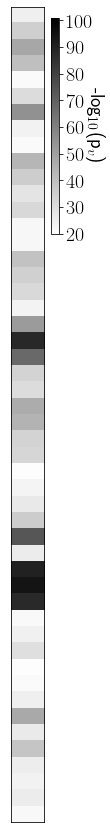

In [317]:
fig,axs=plt.subplots(1,1,figsize=(2*fac,len(idxs)*fac))
datS   = -np.log10(minpvsMid[gnSort[idxs]])
im = axs.imshow(np.array([datS]).T,aspect='auto',cmap='binary',vmin=20,vmax=101)
axs.set_xticks([])
axs.set_yticks([])

divider = make_axes_locatable(axs)

cax2 = fig.add_axes([1.05, 0.67, 0.2, 0.2])

#cax2     = divider.append_axes("right", size=0.1, pad=0.05)

cbar = fig.colorbar(im, cax=cax2, shrink=0.3)
cbar.set_label('-log$_{10}$(p$_v$)',rotation=270, labelpad=10)
cax2.xaxis.set_label_position('top')
mf.set_axs_fontsize(cax2,20)

plt.savefig('{0}/{1}_genes_expr_p{2}_pvals.png'.format(plotdir,grptitle,ii),bbox_inches="tight")

#cax2.xaxis.set_ticks_position('top')
#axs.imshow(nepvs)

In [ ]:
# some clustering... 

In [60]:
#from sklearn.manifold import TSNE

from MulticoreTSNE import MulticoreTSNE as TSNE

In [37]:
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)

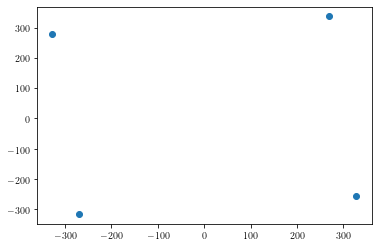

In [38]:
fig,axs=plt.subplots()
axs.plot(X_embedded[:,0], X_embedded[:,1],'o')

In [192]:
gtpmf.shape,gtpmMu.shape

((36, 45660), (12, 45660))

In [61]:
tpmThresh = 0.5
idxsHi    = np.where(np.max(gtpmf,axis=0) > tpmThresh)[0]
gtpmT     = gtpmf[:,idxsHi]
gtpmT.shape

(54, 27755)

In [62]:
gtpm.shape,gtpm.reshape(3,18,-1).shape

((3, 3, 6, 45660), (3, 18, 45660))

In [30]:
tDEpvs.shape,cDEpvs.shape

((3, 5, 45660), (3, 6, 45660))

In [31]:
# threshold by minmium of mean p-value for multiple conditional differences
cDEpvMu    = np.nanmean(cDEpvs2, axis = 1)
cDEpvMinMu = np.min(cDEpvMu,axis=0)
thresh     = 0.05
lowPVidxs  = np.where(cDEpvMinMu < thresh)[0]

#threshold by mean p-value for only one conditional difference
lowPVidxs1  = np.where(cDEpvMu[0] < thresh)[0]

In [32]:
# threshold by minimum of geometric mean of p-value in slices that have at least one non-nan
eps = 1e-200
cDEpvMu    = np.nanmean(-np.log10(cDEpvs2+eps), axis = 1)
cDEpvMinMu = np.max(cDEpvMu,axis=0) #max or min??
thresh     = -np.log10(0.01)
lowPVidxs  = np.where(cDEpvMinMu > thresh)[0]


lowPVidxs2  = np.where(cDEpvMu[0] > thresh)[0]

In [33]:
np.min(np.nanmin(tDEpvs2,axis=1),axis=0).shape

(45660,)

In [241]:
# threshold by minimum of time dependent deseq 
tDEpvMin    = np.nanmin(tDEpvs2, axis=1)
tDEpvMinMin = np.min(tDEpvMin[0:2],axis=0)
nhypo       = 10
thresh      = 0.01/nhypo
lowPVidxs   = np.where(tDEpvMinMin < thresh)[0]


In [363]:
# threshold by low time/condition dependent deseq 
nhypo       = 1
thresh      = 0.001/nhypo
lowPVidxs   = np.where(ctDEpvs2[0] < thresh)[0]
lowPVidxs   = sameDynamicsIdxs

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [364]:
#len(lowPVidxs1),len(lowPVidxs2),len(np.intersect1d(lowPVidxs1,lowPVidxs2))

In [365]:
#lowPVidxs=lowPVidxs2

In [366]:
#gtpmHi = gtpm[:,:,:,idxsHi].transpose((2,0,1,3))
#gtpmHi = gtpm[:,:,:,idxsHi].reshape(3,18,-1).transpose((1,0,2))
gtpmHi = gtpm[:,:,:,lowPVidxs].reshape(3,18,-1).transpose((1,0,2))
sigs   = np.std(gtpmHi,axis=0)
mus = np.mean(gtpmHi,axis=0)
#gtpmZ = (np.divide(gtpmHi-mus, sigs, out=np.zeros_like(gtpmHi), where=sigs!=0)).transpose((1,2,0,3))
gtpmZ = (np.divide(gtpmHi-mus, sigs, out=np.zeros_like(gtpmHi), where=sigs!=0)).transpose((1,0,2))
gtpmZf = gtpmZ.reshape((54,-1))

In [367]:
#gtpmZf.shape,gtpmHi.shape

In [368]:
def cube(x,a,b,c,d):
    return a*x*x*x + b*x*x + c*x + d
def sq(x,a,b,c):
    return a*x*x + b*x + c
def line(x,a,b):
    return a*x+b

In [369]:
namedLowPV = np.setdiff1d(lowPVidxs,unannotatedIdxs)
idxs2 = np.array([np.where(lowPVidxs==n)[0][0] for n in namedLowPV])

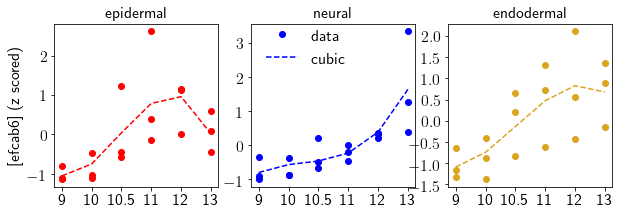

In [370]:
fig,axs=plt.subplots(1,3,figsize=(10,3))
idx = idxs2[3]
cols = ['red','blue','goldenrod']
ts = np.array(list(range(6))*3)

for i in range(0,3):
    fit1 = cf(cube, ts, gtpmZ[i,:,idx])
    fit2 = cf(sq, ts, gtpmZ[i,:,idx])
    fit3 = cf(line, ts, gtpmZ[i,:,idx])
    axs[i].plot(ts,gtpmZ[i,:,idx],'o',c=cols[i],label='data')
    #axs[i].plot(range(6),line(range(6),*fit3[0]),'-',c=cols[i],label='linear')
    #axs[i].plot(range(6),sq(range(6),*fit2[0]),'-.',c=cols[i],label='quadratic')
    axs[i].plot(range(6),cube(range(6),*fit1[0]),'--',c=cols[i],label='cubic')
   
   
    axs[i].set_xticks(range(6))
    axs[i].set_xticklabels(stagestrs)
    #axs[1].plot(ts,gtpmHi[:,i,idx],'o',c=cols[i])


axs[0].set_ylabel('[{0}] (z scored)'.format(gnmsS[lowPVidxs][idx]))
labs=['epidermal','neural','endodermal']
for i in range(3):
    axs[i].set_title(labs[i])
    mf.set_axs_fontsize(axs[i],16)
axs[1].legend(fontsize=16,frameon=False,loc=(0.05,0.7))
#plt.savefig('{0}/func_fitting_data_cube.jpg'.format(plotdir),bbox_inches="tight")

In [371]:
ts = np.array(list(range(6))*3)
fits = np.array([[cf(cube, ts, gtpmZ[i,:,idx])[0] for idx in range(gtpmZ.shape[2])] 
                 for i in range(3)])
fitsCF = fits.transpose((1,0,2)).reshape(-1,12)


In [29]:
cf(cube, ts, gtpmZ[i,:,0])

NameError: name 'cube' is not defined

In [372]:
fitsS = np.array([[cf(sq, ts, gtpmZ[i,:,idx])[0] for idx in range(gtpmZ.shape[2])] 
                  for i in range(3)])
fitsSF = fitsS.transpose((1,0,2)).reshape(-1,9)

In [373]:
# fitsL = np.array([[cf(line, ts, gtpmZ[i,:,idx])[0] for idx in range(gtpmZ.shape[2])] 
#                   for i in range(3)])
# fitsLF = fitsL.transpose((1,0,2)).reshape(-1,6)

In [374]:
# choose which to use:
fitsF  = fitsCF#[:,0:8]
fitfun = cube

In [375]:
#centroid, label = kmeans2(fitsF,6, minit='points')
#labelIdxs = [np.where(label==i)[0] for i in range(6)] 

In [376]:
fitsF.shape

(1543, 12)

In [377]:
ncenters = np.arange(20)+1
sses = []
for nc in ncenters:
    centroid, label = kmeans2(fitsF,nc, minit='points')
    labelIdxs = [np.where(label==c)[0] for c in range(nc)] 
    sses.append(sum([np.sum(linalg.norm(fitsF[labelIdxs[c]]-centroid[c],axis=1)) 
                     for c in range(nc)]))

In [378]:
#gtpmHi.shape,fitsSF.shape

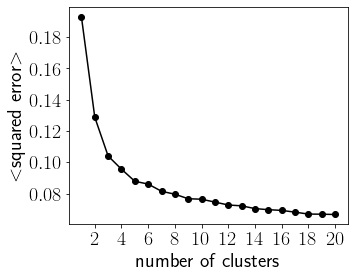

In [379]:
ssesa=np.array(sses)/fitsF.shape[0]/fitsF.shape[1]
fig,axs=plt.subplots(figsize=(5,4))
axs.plot(ncenters,ssesa,'ko-')
axs.set_xlabel('number of clusters')
axs.set_ylabel('$<$squared error$>$')
axs.set_xticks(np.arange(2,22,2))
#axs.set_yscale('log')
mf.set_axs_fontsize(axs,20)

plt.savefig('{0}/num_kmeans_clusts_same_dynamics_all_cube.jpg'.format(plotdir),bbox_inches="tight")

In [384]:
nc = 3
centroid, label = kmeans2(fitsF,nc, minit='points')
labelIdxs = [np.where(label==c)[0] for c in range(nc)]

In [385]:
#gnmsS[lowPVidxs[labelIdxs[3]]]

In [386]:
# d0 = 1
# d1 = 5
# fig,axs=plt.subplots()
# skip = 10
# cols = np.array(['blue','red','cyan','yellow','black','goldenrod'])
# labs=[0,1,2,3,4,5]
# for i in range(len(labs)):
#     axs.plot(fitsF[labelIdxs[labs[i]][::skip],d0],fitsSF[labelIdxs[labs[i]][::skip],d1],'o', c=cols[i])
#     #axs.scatter(centroid[:,d0],centroid[:,d1],c=cols[0:4],s=200)


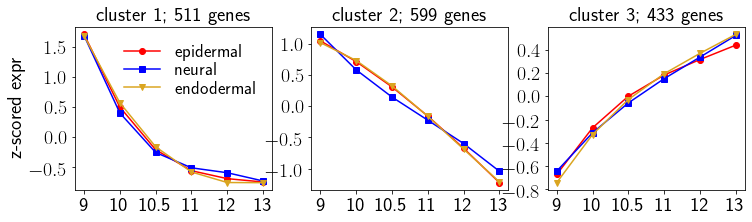

In [387]:
ncond = 3
centroid_coefs = np.array(np.split(centroid,ncond,axis=1)) # [i,j] == > cond i , clust j
fig,axs=plt.subplots(1,nc,figsize=(4*nc,3))
cols = [plt.cm.tab10.colors[i] for i in range(10)]
cols = np.array(['red','blue','goldenrod'])#,'yellow'])
labs = ['epidermal','neural','endodermal']
marks = ['o','s','v']
ts = range(6)
st = 2
for i in range(nc):
    
    for j in range(ncond): #range(st,min(st+3,nc)):#range(0,4):
        #dat = cube(ts,*centroid_coefs[i,j])
        dat = fitfun(ts,*centroid_coefs[j,i])
        axs[i].plot(ts, dat, marks[j%len(marks)]+'-',c=cols[j%len(cols)],label = labs[j])
    
    axs[i].set_xticks(range(6))
    axs[i].set_xticklabels(stagestrs)
    #axs[1].plot(ts,gtpmHi[:,i,idx],'o',c=cols[i])

#axs[0].set_ylabel('[{0}] (z scored)'.format(gnmsS[idxsHi][idx]))
labs=['epidermal','neural','endodermal']
axs[0].set_ylabel('z-scored expr')
for i in range(nc):
    axs[i].set_title('cluster {0}; {1} genes'.format(i+1,len(labelIdxs[i])))
    mf.set_axs_fontsize(axs[i],20)
axs[0].legend(fontsize=18,frameon=False,labelspacing=0.01,loc='upper right')
plt.savefig('{0}/kmean_centroids_nc{1}_cubic_same_dynamics_any_genes.jpg'.format(plotdir,nc),bbox_inches="tight")

In [388]:
#pways = ['BMP','TGF-beta','MAPK','Notch','Wnt','Hedgehog','VEGF','FoxO']
pways = ['TGF-beta original', 'BMP','TGF-beta','MAPK','Notch','Wnt','Hedgehog','VEGF']
addons = ['',' TF',' non TF']
grps = [['{0} signaling pathway{1}'.format(pw,addon) for pw in pways] for addon in addons]
cidx = 2
# pvs = np.array([[hgpv(lowPVidxs[labelIdxs[i]],grp) for grp in grps] 
#                 for i in range(len(labelIdxs))])
pvs = np.array([[[hgpv(lowPVidxs[labelIdxs[i]],grps[j][k]) 
                  for j in range(len(grps))] 
                 for k in range(len(grps[j]))] 
                for i in range(len(labelIdxs))])

tfpvs = np.array([hgpv(lowPVidxs[labelIdxs[i]],'transcription factors') for i in range(len(labelIdxs))])


eps = 10**-12
logpvs = -np.log10(pvs+eps)
logtfpvs = -np.log10(tfpvs+eps)

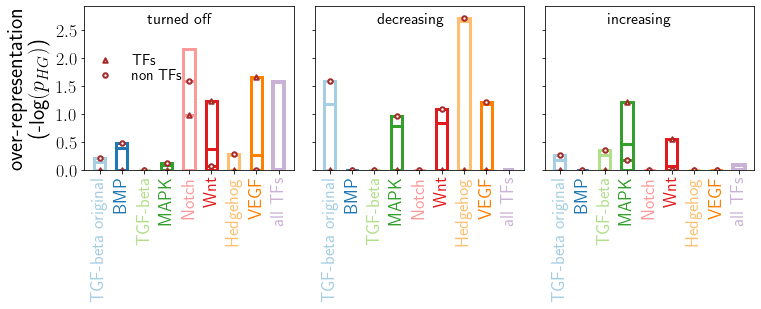

In [389]:
nc = logpvs.shape[0]
cols = matplotlib.colors.to_rgba_array(plt.cm.Paired.colors)
fig,axs=plt.subplots(1,nc,figsize=(4*nc,3))
labs = pways + ['all TFs'] #['BMP','TGFb','MAPK','TFs']

grp_labels = ['turned on','turned off','decreasing','increasing']
grp_labels = ['decreasing','increasing']
grp_labels = ['increasing','turned off','slowly decreasing','non-monotonic','decreasing']
grp_labels = ['turned off','decreasing','increasing']
#grp_labels = ['increasing','decreasing']


lss = ['solid','dotted','dashed']
pms = ['o','^','o']
plabs = ['all','TFs','non TFs']
for i in range(nc):
    for j in range(logpvs.shape[2]):
        axs[i].bar(np.arange(len(pways)),logpvs[i,:,j],width=0.5, edgecolor=cols, 
                   ls = lss[0], lw=3, fc=(1,1,1,0))
        if j > 0:
            axs[i].scatter(np.arange(len(pways)),logpvs[i,:,j],s=20,marker=pms[j],
                           label=plabs[j],edgecolor='brown',c='white',linewidth=2,zorder=2) #c=cols[0:len(pways)],)
    
    axs[i].bar(len(labs)-1,logtfpvs[i],width=0.5, edgecolor=cols[len(labs)-1], lw=4,fc=(1,1,1,0))
    
    axs[i].set_xticks(range(len(labs)))
    axs[i].set_xticklabels(labs,rotation=90)
    axs[i].set_ylim(0,np.max([np.max(logpvs),np.max(logtfpvs)])+0.2) #12.5)
    #[i.set_color(cols[]) for i in plt.gca().get_xticklabels()]
    [t.set_color(c) for (c,t) in zip(cols[0:len(labs)],axs[i].xaxis.get_ticklabels())]
    if i > 0:
        axs[i].set_yticklabels([])
#axs[0].set_yticklabels(range(0,14,2))
    
    axs[i].text(x=0.3,y=0.9,s=grp_labels[i],transform=axs[i].transAxes,fontsize=16)
    mf.set_axs_fontsize(axs[i],18)
    
axs[0].set_ylabel('over-representation\n(-log$(p_{HG})$)',fontsize=22)
axs[0].legend(fontsize=15,labelspacing=0,frameon=False,loc=(0,0.5))
plt.subplots_adjust(wspace=0.1)
plt.savefig('{0}/phg_sam_dynamics_genes_cubic_nclust{1}.jpg'.format(plotdir,nc),bbox_inches="tight")
#plt.savefig('{0}/phg_dyn_genes_all_conds.jpg'.format(plotdir,'_'.join(condVs[cidx]),addon.replace(' ','_')),bbox_inches="tight")

#              color=cols[i%3], hatch=hatches[int(i/3)],#edgecolor='white',
#              label=barlabs[i] if labs[i] else None)

In [325]:
# for i in range(ngrp):
#     for k,v in pway_cts[i].items():
#         pv = 1-hg.cdf(v,ngenes,nullPwayCts[k],ngenesPerGrp[i])
#         if pv < threshB:
#             pway_ct_pvs[i][trimPway(k)] = -np.log10(max(pv,10**-12))

In [326]:
#[i for i in list(keggidxsnull.keys()) if 'pathway' in i]

In [788]:
1-hg.cdf(0,ngenes,len(keggidxsnull['TGF-beta signaling pathway']),2)

0.0035885792639285263

In [ ]:
rv = hypergeom(M, n, N)
>>> x = np.arange(0, n+1)
>>> pmf_dogs = rv.pmf(x)

In [794]:
rv = hg(ngenes, len(keggidxsnull['TGF-beta signaling pathway']), 2)
rv.pmf(np.arange(3))

array([9.96411421e-01, 3.58539336e-03, 3.18593249e-06])

In [181]:
# pways = ['BMP','TGF-beta','MAPK']
# grps = [ pw +' signaling pathway TF' for pw in pways ] + ['transcription factors']
# pvs = np.array([[hgpv(lowPVidxs[labelIdxs[i]],grp) for grp in grps] 
#                 for i in range(len(labelIdxs))])
# eps = 10**-12
# logpvs = -np.log10(pvs+eps)

In [189]:
# fig,axs=plt.subplots(1,nc,figsize=(4*nc,3))
# labs = ['BMP','TGFb','MAPK','TFs']
# for i in range(nc):
#     axs[i].bar(np.arange(len(grps)),logpvs[i],width=0.5)
#     axs[i].set_xticks(range(4))
#     axs[i].set_xticklabels(labs)
#     axs[i].set_ylim(0,2)
#     #axs[i].set_yticklabels([])
# #axs[0].set_yticklabels(range(0,14,2))


# for i in range(nc):
#     mf.set_axs_fontsize(axs[i],18)
    
# axs[0].set_ylabel('over-representation\n(-log$(p_{HG})$)',fontsize=22)
# #plt.savefig('{0}/kmeans_overrep_nc{1}_cubic.jpg'.format(plotdir,nc),bbox_inches="tight")

# #              color=cols[i%3], hatch=hatches[int(i/3)],#edgecolor='white',
# #              label=barlabs[i] if labs[i] else None)

In [320]:
nc

3

In [390]:
tfOffIdxs = np.intersect1d(lowPVidxs[labelIdxs[0]],keggidxsnull['transcription factors'])
tfOnIdxs = np.intersect1d(lowPVidxs[labelIdxs[2]],keggidxsnull['transcription factors'])

In [391]:
tfOnIdxs,tfOffIdxs

(array([ 3079,  3616,  4222,  9347,  9662, 29418, 30870, 33348, 33874,
        34568, 35175, 37066, 41110]),
 array([ 1783,  2468,  4563,  5238,  7997,  9556, 28080, 28574, 29423,
        30203, 30356, 31725, 31868, 32593, 34412, 35810, 36730, 36733,
        37048, 38600, 39715, 39789, 39851, 42836, 42934, 43852, 45426,
        45579]))

In [392]:
tfOffIdxOrder = np.argsort(np.nanmin(tDEpvs2[:,:,tfOffIdxs],axis=(0,1)))

In [393]:
gnmsS[tfOffIdxs[tfOffIdxOrder]],np.sort(gnmsS[tfOffIdxs[tfOffIdxOrder]])

(array(['dpf2.L', 'nfe2l2.S', 'rel.S', 'trerf1.L', 'pbx3', 'znf143.L',
        'foxi2.L', 'cebpg.S', 'dmtf1.L', 'zbed6', 'figla.L', 'nr1h2.S',
        'cux1.S', 'creb3l2.S', 'gpbp1.L', 'rfx3.L', 'tead1.L', 'nfatc2.S',
        'tbpl2.L', 'nfia.S', 'rbpj.S', 'klf7.S', 'mitf.S', 'alx1.S',
        'ppard.S', 'znf711.L', 'nkx6-1', 'cc2d1b.L'], dtype='<U23'),
 array(['alx1.S', 'cc2d1b.L', 'cebpg.S', 'creb3l2.S', 'cux1.S', 'dmtf1.L',
        'dpf2.L', 'figla.L', 'foxi2.L', 'gpbp1.L', 'klf7.S', 'mitf.S',
        'nfatc2.S', 'nfe2l2.S', 'nfia.S', 'nkx6-1', 'nr1h2.S', 'pbx3',
        'ppard.S', 'rbpj.S', 'rel.S', 'rfx3.L', 'tbpl2.L', 'tead1.L',
        'trerf1.L', 'zbed6', 'znf143.L', 'znf711.L'], dtype='<U23'))

In [394]:
tfOnIdxOrder = np.argsort(np.nanmin(tDEpvs2[:,:,tfOnIdxs],axis=(0,1)))
gnmsS[tfOnIdxs[tfOnIdxOrder]]

array(['wiz.S', 'creb1.L', 'usf1', 'l3mbtl1.S', 'nr2f5.S', 'jund',
       'lyl1.S', 'irf3.L', 'sia2.S', 'hoxb7.L', 'fev', 'jun', 'en2.L'],
      dtype='<U23')

In [200]:
#gnmsS[np.setdiff1d(lowPVidxs[labelIdxs[1]],unannotatedIdxs)]

In [163]:
ncoefs = fitsF.shape[1]
hulls = [[[ConvexHull(fitsF[labelIdxs[i],[[d0],[d1]]].T) 
           for d1 in range(d0+1,ncoefs)] 
          for d0 in range(ncoefs)]
         for i in range(nc)]

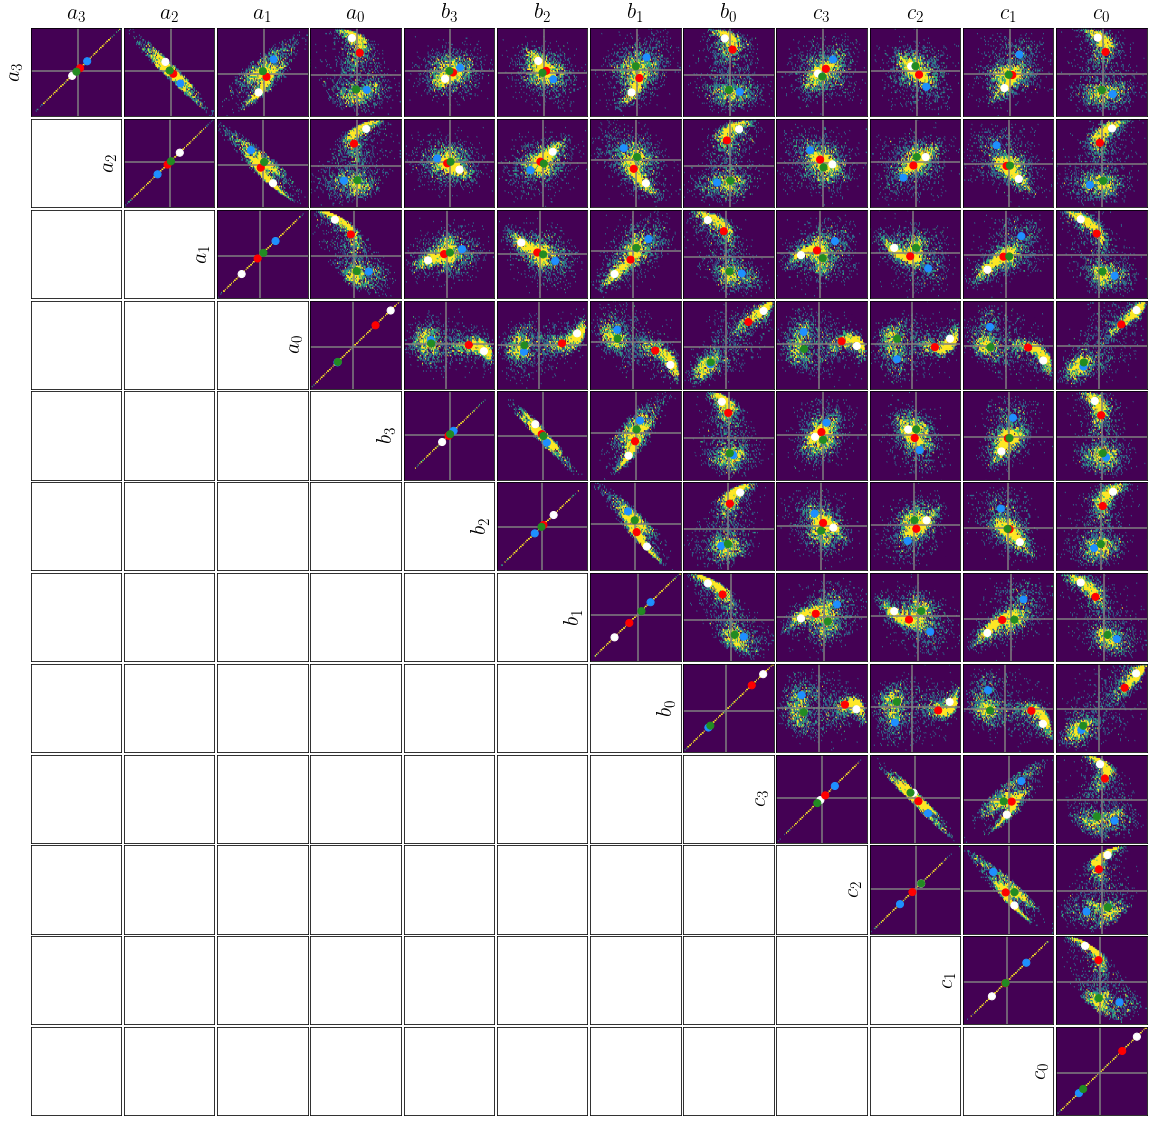

In [167]:
d0 = 0
d1 = 1
ncoefs = fitsF.shape[1]
fig,axs=plt.subplots(ncoefs,ncoefs,figsize=(20,20))
skip = 1
cols = np.array(['white','red','dodgerblue','forestgreen'])
labs=[0,1,2,3,4,5]
nbins=100
for d0 in range(ncoefs):
    for d1 in range(d0,ncoefs):
        #axs[d0,d1].plot(fitsSF[::skip,d0],fitsSF[::skip,d1],'o', c='lightsteelblue',zorder=0)
        #axs[d0,d1].scatter(centroid[:,d0],centroid[:,d1],c=cols[0:nc],s=50,zorder=2)
        
        axs[d0,d1].hexbin(fitsF[:,d0],fitsF[:,d1], gridsize=nbins, zorder=0,vmin=0,vmax=3)
        axs[d0,d1].scatter(centroid[:,d0],centroid[:,d1],c=cols[0:nc],s=50,zorder=2)
        
        axs[d0,d1].axhline(c='grey',zorder=1)
        axs[d0,d1].axvline(c='grey',zorder=1)
        
#         if d1 > d0:
#             for i in range(nc):
#                 vs = labelIdxs[i][hulls[i][d0][d1-(d0+1)].vertices]
#                 vs = np.append(vs, vs[0])
#                 axs[d0,d1].plot(fitsF[vs,d0],fitsF[vs,d1],'-',c=cols[i],lw=2)
    
        
for d0 in range(ncoefs):
    for d1 in range(ncoefs):
        axs[d0,d1].set_xticks([])
        axs[d0,d1].set_yticks([])

coefs=[3,2,1,0]
labs = ['a','b','c']
for d0 in range(ncoefs):
    axs[0,d0].set_title('${0}_{1}$'.format(labs[int(d0/len(coefs))],coefs[d0%len(coefs)]),fontsize=22)
    axs[d0,d0].set_ylabel('${0}_{1}$'.format(labs[int(d0/len(coefs))],coefs[d0%len(coefs)]),fontsize=22)
plt.subplots_adjust(wspace=0.03,hspace=0.03)

plt.savefig('{0}/clusts_same_dynamics.jpg'.format(plotdir),bbox_inches="tight")

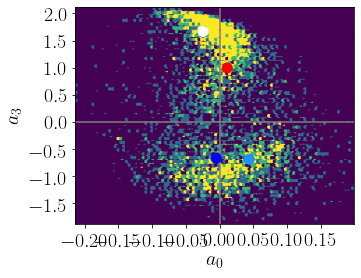

In [170]:
d0 = 0
d1 = 3
ncoefs = fitsF.shape[1]
fig,axs=plt.subplots(1,1,figsize=(5,4))
skip = 1
cols = np.array(['white','red','dodgerblue','blue','cyan'])
labs=[0,1,2,3,4,5]
nbins=100

#axs.plot(fitsF[::skip,d0],fitsF[::skip,d1],'o', c='lightsteelblue',zorder=0)
#axs.scatter(centroid[:,d0],centroid[:,d1],c=cols[0:nc],s=50,zorder=2)
        
axs.hexbin(fitsF[:,d0],fitsF[:,d1], gridsize=nbins, zorder=0,vmin=0,vmax=3)
axs.scatter(centroid[:,d0],centroid[:,d1],c=cols[0:nc],s=100,zorder=2)

axs.axhline(c='grey',zorder=1)
axs.axvline(c='grey',zorder=1)
        

# for i in range(nc):
#     vs = labelIdxs[i][hulls[i][d0][d1-(d0+1)].vertices]
#     vs = np.append(vs, vs[0])
#     axs.plot(fitsF[vs,d0],fitsF[vs,d1],'-',c=cols[i],lw=2)
    
        

#         axs[d0,d1].set_xticks([])
#         axs[d0,d1].set_yticks([])

coefs=[3,2,1,0]
labs = ['a','b','c']
axs.set_xlabel('${0}_{1}$'.format(labs[int(d1/len(coefs))],coefs[d1%len(coefs)]),fontsize=22)
axs.set_ylabel('${0}_{1}$'.format(labs[int(d0/len(coefs))],coefs[d0%len(coefs)]),fontsize=22)

# axs.set_xlim(-0.2,0.2)
# axs.set_ylim(-3.2,3.7)
# axs.set_xticks(np.arange(-0.2,0.3,0.1))
mf.set_axs_fontsize(axs,20)

#plt.savefig('{0}/clust_a3_a1_density_clusts.jpg'.format(plotdir),bbox_inches="tight")

In [171]:
# list of differentiating clusters for nc=20 with cubic fits:
# 0 -- pn v d
# 3 -- p v n v d
# 13 -- p v n v d
# 16 -- pd v n


In [ ]:
# list of differentiating clusters for nc=20 with square fits:
# 0 -- pd v n
# 2 -- p v n v d
# 3 -- p v n v d
# 8 -- p v dn
# 11 -- pn v d
# 17 -- p v nd
# 18 -- pn v d

In [264]:
len(labelIdxs[16])

2245

In [227]:
dat

array([ 1.609336  ,  0.49956386, -0.19594758, -0.56350818, -0.6894278 ,
       -0.66001631])

In [77]:
cube

<function __main__.cube(x, a, b, c, d)>

In [161]:
perps = [1,5,30,100,200]
gtsne_all = [TSNE(n_components=2,perplexity=i).fit_transform(gtpmT.T) 
             for i in perps]

NameError: name 'TSNE' is not defined

In [250]:
tsne = TSNE(n_jobs=4,perplexity=100)
gtsne_all_2 = tsne.fit_transform(gtpmT.T)

KeyboardInterrupt: 

In [248]:
tsne = TSNE(n_jobs=4,perplexity=100)
gtsne_all_3 = tsne.fit_transform(gtpmZf.T)

In [260]:
perps = [1,5,30,100,200]
gtsneZ2_all = [TSNE(n_components=2,perplexity=i).fit_transform(gtpmZf.T) 
             for i in perps]


In [224]:
gtsne_all_long = TSNE(n_jobs=8,perplexity=100,n_iter=2000).fit_transform(gtpmT.T)

In [226]:
gtsne_all_longer = TSNE(n_jobs=8,perplexity=100,n_iter=5000).fit_transform(gtpmT.T)

In [167]:
tDEpvs.shape

(3, 5, 45660)

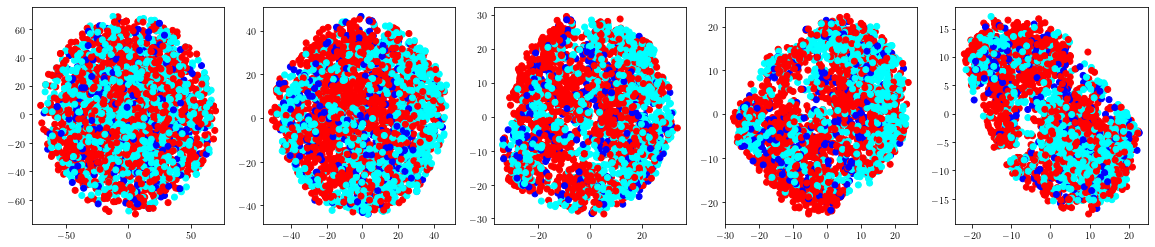

In [261]:
fig,axs=plt.subplots(1,5,figsize=(20,4))
skip=10
for i in range(len(perps)):
    axs[i].scatter(gtsneZ2_all[i][::skip,0],gtsneZ2_all[i][::skip,1],c=cols[loCond[::skip]])
    

In [188]:
cols = np.array(['red','blue','goldenrod'])
cols[[0,1,1,2]]

array(['red', 'blue', 'blue', 'goldenrod'], dtype='<U9')

In [212]:
cols2 = plt.cm.viridis(np.linspace(0,1,5))

In [215]:
cols2[loTime[1:5]]

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ],
       [0.229739, 0.322361, 0.545706, 1.      ]])

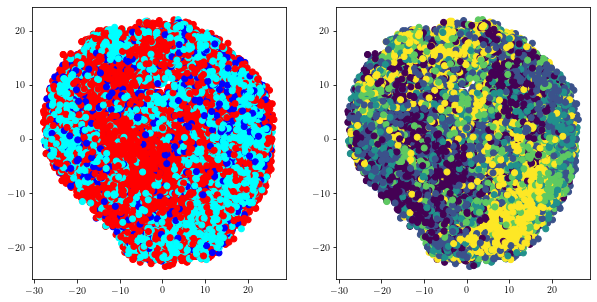

In [249]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
skip=1
cols = np.array(['red','blue','cyan'])
cols2 = plt.cm.viridis(np.linspace(0,1,5))
axs[0].scatter(gtsne_all_3[::skip,0],gtsne_all_3[::skip,1],c=cols[loCond[::skip]])
axs[1].scatter(gtsne_all_3[::skip,0],gtsne_all_3[::skip,1],c=cols2[loTime[::skip]])

#axs[1].scatter(gtsne_all_long[::skip,0],gtsne_all_long[::skip,1])
#axs[2].scatter(gtsne_all_longer[::skip,0],gtsne_all_longer[::skip,1])
#plt.savefig('{0}/tsne_time_cond.jpg'.format(plotdir),bbox_inches="tight")

In [ ]:
gtsne_ = TSNE(n_components=2,perplexity=200).fit_transform(gctsMu[:,lowPVallBoth].T)

In [144]:
g_embedded = TSNE(n_components=2,perplexity=200).fit_transform(gctsMu[:,lowPVallBoth].T)

In [145]:
g_embedded_all = TSNE(n_components=2,perplexity=200).fit_transform(gctsMu.T)

In [64]:
g_embedded.shape

(9650, 2)

In [76]:
pvsAll.shape

(10, 45660)

In [94]:
def mynanargmin(R, default_val = -1):
    minClasses          = np.zeros(R.shape[1]) + default_val
    d0                  = np.nanmin(R, axis=0) # this nicely returns nan when all-nan-slice
    finidxs             = np.where(np.isfinite(d0))[0]
    minClasses[finidxs] = np.nanargmin(R[:,finidxs],axis=0)
    return minClasses

In [158]:
# define classes to be 1:10
# pvalue matrix = pvalues for epid are at idxs 0:5 and pvalues for neur are at 5:10
# class = argmin of pvalue matrix
pvsAll = np.vstack([epidpvs,neurpvs])
pvClass  = np.array(mynanargmin(pvsAll)+1,dtype='int')
pvClassB = np.array(mynanargmin(pvsAll[:,lowPVallBoth]),dtype='int')

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until


In [88]:
np.nanargmin(pvsAll[:,np.where(np.isfinite(d0))],axis=0)

array([[2, 0, 4, ..., 6, 5, 5]])

In [ ]:
# define classes to be 
#(a) early joint
#(b) early epidermal exclusive
#(c) early neural exclusive
#(d) late joint
#(e) late epidermal exclusive
#(f) late neural exclusive
#(g) early late overlap joint exclusive
#(h) early late overlap epidermal
#(i) early late overlap neural

In [ ]:
# define classes to be

In [105]:
len(plt.cm.rd.colors)

8

In [174]:
cols1 = plt.cm.OrRd(np.linspace(0,1,5))
cols2 = plt.cm.BuGn(np.linspace(0,1,5))
colsD = [[0,1,0,1]]
cols = np.vstack([colsD,cols1,cols2])

In [147]:
cols[pvClass]

array([[0.9874356 , 0.55048058, 0.34797386, 1.        ],
       [1.        , 0.96862745, 0.9254902 , 1.        ],
       [0.49803922, 0.        , 0.        , 1.        ],
       ...,
       [0.        , 1.        , 0.        , 1.        ],
       [0.96862745, 0.98823529, 0.99215686, 1.        ],
       [0.96862745, 0.98823529, 0.99215686, 1.        ]])

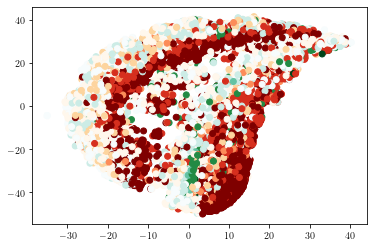

In [162]:
fig,axs=plt.subplots()
axs.scatter(g_embedded[::1,0],g_embedded[::1,1],c=cols[pvClass[lowPVallBoth]])

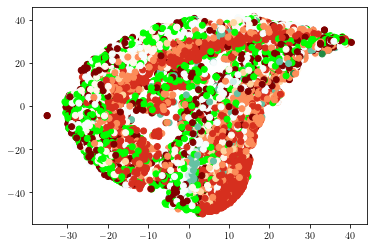

In [163]:
fig,axs=plt.subplots()
axs.scatter(g_embedded[::1,0],g_embedded[::1,1],c=cols[pvClassB])

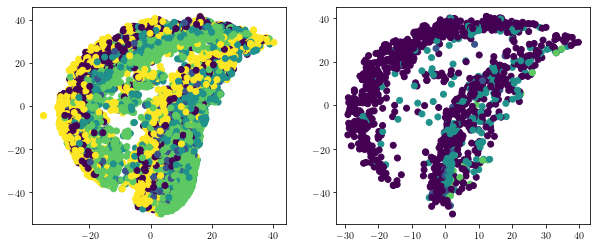

In [180]:
nidxs = np.where(pvClassB>5)
eidxs = np.where((pvClassB > 0) & (pvClassB < 6))

cols = plt.cm.viridis(np.linspace(0,1,5))
fig,axs=plt.subplots(1,2,figsize=(10,4))
axs[0].scatter(g_embedded[eidxs,0],g_embedded[eidxs,1],c=cols[pvClassB[eidxs]-1])
axs[1].scatter(g_embedded[nidxs,0],g_embedded[nidxs,1],c=cols[pvClassB[nidxs]-6])

In [177]:
cols[6:10]

array([[0.96862745, 0.98823529, 0.99215686, 1.        ],
       [0.79843137, 0.92487505, 0.90106882, 1.        ],
       [0.39772395, 0.75955402, 0.64030757, 1.        ],
       [0.13402537, 0.54232987, 0.26828143, 1.        ]])

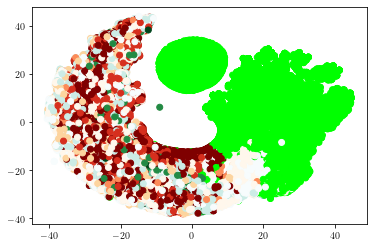

In [151]:
fig,axs=plt.subplots()
axs.scatter(g_embedded_all[::1,0],g_embedded_all[::1,1],c=cols[pvClass])

In [304]:
keggidxsnull['transcription factors'].shape

(1694,)

In [308]:
len(keggidxsnull['FoxO signaling pathway TF'])

23

In [310]:
np.setdiff1d(keggidxsnull['MAPK signaling pathway TF'],keggidxsnull['transcription factors'])

array([], dtype=int64)

In [311]:
keggidxsnull['BMP signaling pathway TF']

[3481, 41656, 41657, 41662, 41664, 41667, 41668, 41669, 41670, 41672]

In [ ]:
# let's try only looking at transcription factors

In [316]:
gtpmf.shape,gtpmT.shape

((54, 45660), (54, 27755))

In [318]:
gtpmTFs = gtpmf[:,keggidxsnull['transcription factors']]
gtpmTFs.shape

(54, 1694)

In [395]:
perps = [30,50,70,100,200]
gtsne_tf = [TSNE(n_components=2,perplexity=i,n_iter=10000).fit_transform(gtpmTFs.T) for i in perps]

In [406]:
# coloring based on pathway
pways   = ['BMP','TGF-beta','MAPK']
pwaylabs   = ['BMP','TGF','BMP+TGF','MAPK']
cols   = ['red','goldenrod','black','blue','lightgray']

pwayTFs = [set(keggidxsnull['{0} signaling pathway TF'.format(p)]) for p in pways]

# some pathways intersect -- deal with intersections
pwayTFsI = [pwayTFs[0]-pwayTFs[1],pwayTFs[1]-pwayTFs[0]
            ,pwayTFs[2],pwayTFs[0].intersection(pwayTFs[1])] 
pwayTFidx = {k:i for i in range(len(pwayTFsI)) for k in pwayTFsI[i] } 
pwayTFcol = {np.where(tfidxsA==k)[0][0]:cols[i] for i in range(len(pwayTFsI)) for k in pwayTFsI[i] } 

tfcols = []

for i in range(len(tfidxsA)):
    tfcols.append(cols[pwayTFidx.get(tfidxsA[i],4)])

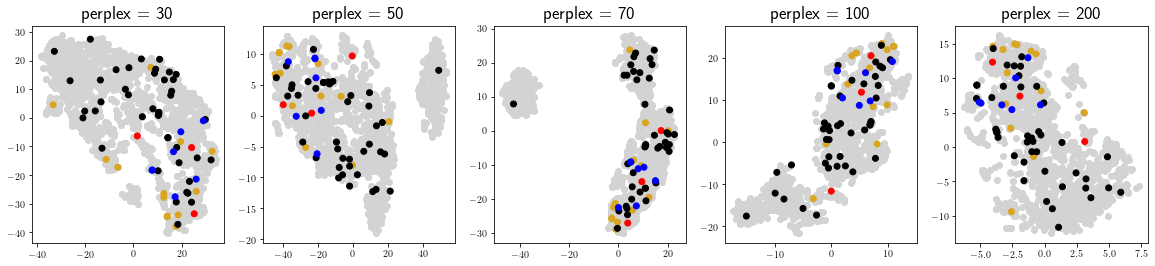

In [444]:
fig,axs=plt.subplots(1,5,figsize=(20,4))
skip=1
for i in range(len(perps)):
    axs[i].scatter(gtsne_tf[i][::skip,0],gtsne_tf[i][::skip,1],c='lightgray')
    pway_scatter = axs[i].scatter(gtsne_tf[i][list(pwayTFcol.keys()),0],
                                  gtsne_tf[i][list(pwayTFcol.keys()),1],
                                  c=list(pwayTFcol.values()))
    axs[i].set_title('perplex = {0}'.format(perps[i]),fontsize=18)

# produce a legend with the unique colors from the scatter
#handles, labels = pway_scatter.legend_elements(alpha=0.6)
#legend1 = axs[2].legend(handles,
#                    loc="lower left", title="pathways", labels =pwaylabs )
#axs[2].add_artist(legend1)
plt.savefig('{0}/tsne_tfs.jpg'.format(plotdir),bbox_inches="tight")

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  if sys.path[0] == '':


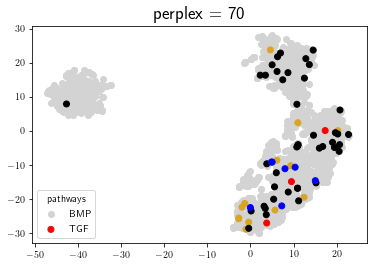

In [448]:
fig,axs=plt.subplots()
skip=1

axs.scatter(gtsne_tf[2][::skip,0],gtsne_tf[2][::skip,1],c='lightgray')
pway_scatter = axs.scatter(gtsne_tf[2][list(pwayTFcol.keys()),0],
                              gtsne_tf[2][list(pwayTFcol.keys()),1],
                              c=list(pwayTFcol.values()))
axs.set_title('perplex = {0}'.format(perps[2]),fontsize=18)

# produce a legend with the unique colors from the scatter
handles, labels = pway_scatter.legend_elements(alpha=0.6)
legend1 = axs.legend(handles, loc="lower left", title="pathways", labels =pwaylabs )
#axs[2].add_artist(legend1)

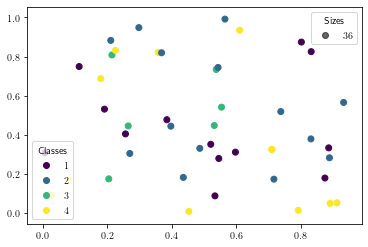

In [419]:
N=45
x, y = np.random.rand(2, N)
c = np.random.randint(1, 5, size=N)
s = np.random.randint(10, 220, size=N)

fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=c)#, s=s)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.show()
#Copy to clipboard


In [456]:
cDEpvs.shape

(3, 6, 45660)

In [476]:
nanpvidxs = np.where(np.isnan(np.mean(cDEpvs,axis=1)))[1]

In [517]:
lowPVidxs.shape

(1504,)

In [69]:
perps = [1,5,30,100,200]
tsne_cubes = [TSNE(n_components=2,perplexity=i).fit_transform(fitsF) 
             for i in perps]

In [77]:
tsne_cubeLong = TSNE(n_components=2,perplexity=100,n_iter=10000).fit_transform(fitsF) 

In [75]:
tsne_cubeHi = TSNE(n_components=2,perplexity=1000).fit_transform(fitsF)

In [70]:
tDEpvsHi = tDEpvs[:,:,idxsHi]
tDEpvsR  = tDEpvsHi.reshape(15,-1)

loCond   = np.int8(np.floor(np.argmin(tDEpvsR,axis=0)/5))
loTime   = np.int8(np.argmin(tDEpvsR,axis=0)%5)

cols = np.array(['red','blue','cyan'])
cols2 = plt.cm.viridis(np.linspace(0,1,5))

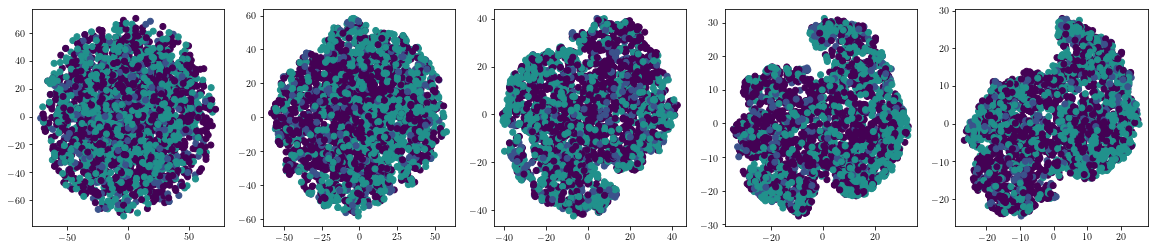

In [73]:
fig,axs=plt.subplots(1,5,figsize=(20,4))
skip=10
for i in range(len(perps)):
    axs[i].scatter(tsne_cubes[i][::skip,0],tsne_cubes[i][::skip,1],c=cols2[loCond[::skip]])

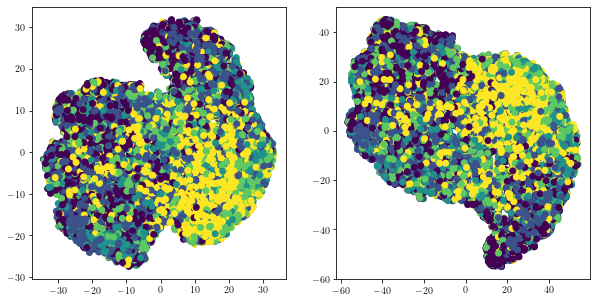

In [79]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
skip=1
cols = np.array(['red','blue','cyan'])
cols2 = plt.cm.viridis(np.linspace(0,1,5))
#axs[0].scatter(tsne_cubeLong[::skip,0],tsne_cubeLong[::skip,1],c=cols[loCond[::skip]])
axs[0].scatter(tsne_cubes[3][::skip,0],tsne_cubes[3][::skip,1],c=cols2[loTime[::skip]])
axs[1].scatter(tsne_cubeLong[::skip,0],tsne_cubeLong[::skip,1],c=cols2[loTime[::skip]])


In [846]:
# hypergeometric example
# Suppose we have a collection of 20 animals, of which 7 are dogs. 
# Then if we want to know the probability of finding a given number of dogs 
# if we choose at random 12 of the 20 animals, we can initialize a frozen distribution and 
# plot the probability mass function:


[M, n, N] = [20, 7, 12]
rv = hg(M, n, N)
x = np.arange(0, n+1)
pmf_dogs = rv.pmf(x)
prb = hg.cdf(x[-1], M, n, N)

In [292]:
np.where(gnmsS=='id3.L'),np.where(gnmsS=='id3.S')

((array([33557]),), (array([33558]),))

In [ ]:
fig,axs=plt.subplots()
axs.plot(gtpm)

In [293]:
cDEpvs2.shape

(3, 6, 45660)

<function __main__.<lambda>(x, p)>

In [637]:
threshHi = 0.5
threshLow = 1e-4
low_cpvidxs = [[lowIdxs(cDEpvs2[i,j],threshLow) for j in range(cDEpvs2.shape[1])] 
              for i in range(cDEpvs2.shape[0])]
hi_cpvidxs = [[hiIdxs(cDEpvs2[i,j],threshHi) for j in range(cDEpvs2.shape[1])] 
             for i in range(cDEpvs2.shape[0])]

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [638]:
cde_mid_exns = []

In [641]:
cidx = 2
conds = [1,2]

cdeidxs_mid   = reduce(np.union1d,low_cpvidxs[cidx][1:-1])
cndeidxs_ends = np.intersect1d(hi_cpvidxs[cidx][0],hi_cpvidxs[cidx][-1])
cde_mid_ex    = np.intersect1d(cdeidxs_mid,cndeidxs_ends)
cde_mid_exn   = np.setdiff1d(cde_mid_ex,unannotatedIdxs)
cde_mid_exns.append(cde_mid_exn)

In [579]:
cde_mid_exn_lopval_sort = np.argsort(np.nanmin(cDEpvs2[cidx,1:-1,cde_mid_exn],axis=1))

In [580]:
# id3 check
id3idxs = np.array([33557,33558])
np.array_equal(np.intersect1d(id3idxs,cde_mid_ex),id3idxs)

False

In [581]:
#i = cde_mid_ex[0]
#cDEpvs2[cidx,:,i]

In [582]:
#cDEpvs2[0,:,cde_mid_exn[26]]

In [583]:
gtpm.shape,gtpmMu.shape,gtpmMuS.shape,gtpmT.shape

((3, 3, 6, 45660), (18, 45660), (3, 6, 45660), (3, 3, 6, 45660))

In [584]:
#gtpmMuS = np.mean(gtpm,axis=1)
#gtpmT = gtpm.transpose((1,0,2,3))
errs = gtpmT-gtpmMuS
uperrs = np.max(errs,axis=0)
loerrs = np.abs(np.min(errs,axis=0))
loUpErrs = np.array([loerrs,uperrs])

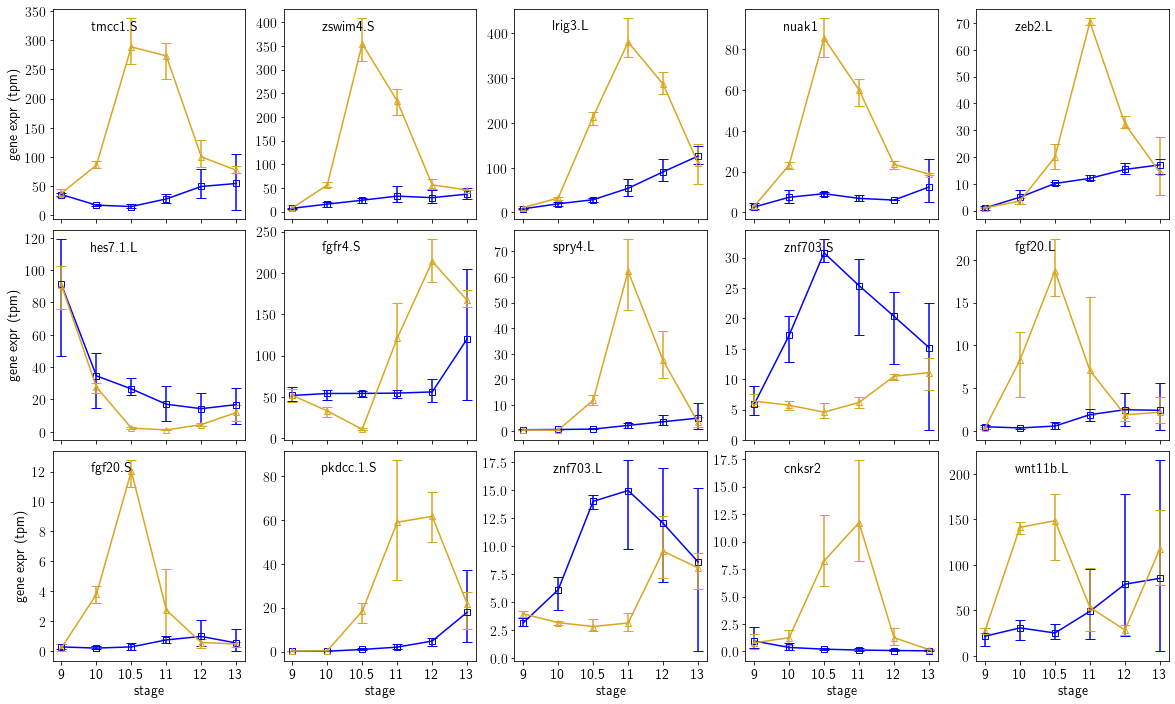

In [585]:
fig,axs=plt.subplots(3,5,figsize=(20,12))
marks = ['o','s','^']
cols = ['red','blue','goldenrod']
labs = ['epidermal','neural','endodermal']
#condranges = np.split(np.arange(18),3)
for i in range(15):
    #idx = cde_mid_exn[i]
    idx = cde_mid_exn[cde_mid_exn_lopval_sort[i]]
    ax  = axs[int(i/5),i%5]
    #ax.set_yscale('symlog')
    
    for cond in conds:
        #ax.plot(range(6),gtpmMu[condranges[cond],idx],marker=marks[cond],color=cols[cond])
        ax.errorbar(range(6),gtpmMuS[cond,:,idx],yerr=loUpErrs[:,cond,:,idx],
            color=cols[cond],marker=marks[cond],capsize=5, label=labs[cond], fillstyle='none')
    
    ax.text(x=0.2,y=0.9,s=gnmsS[idx],fontsize=14,transform=ax.transAxes)
    ax.set_xticks(range(6))
    if i>9:
        ax.set_xticklabels(stagestrs)
        ax.set_xlabel('stage')
    else:
        ax.set_xticklabels([])
        
    if i%5==0:
        ax.set_ylabel('gene expr (tpm)')
        
    mf.set_axs_fontsize(ax,14)
    
plt.subplots_adjust(hspace = 0.05)
plt.savefig('{0}/id3_like_highest15_{1}.jpg'.format(plotdir,'_'.join(condVs[cidx])),bbox_inches="tight")
        #ax.set_title(gnmsS[idx])

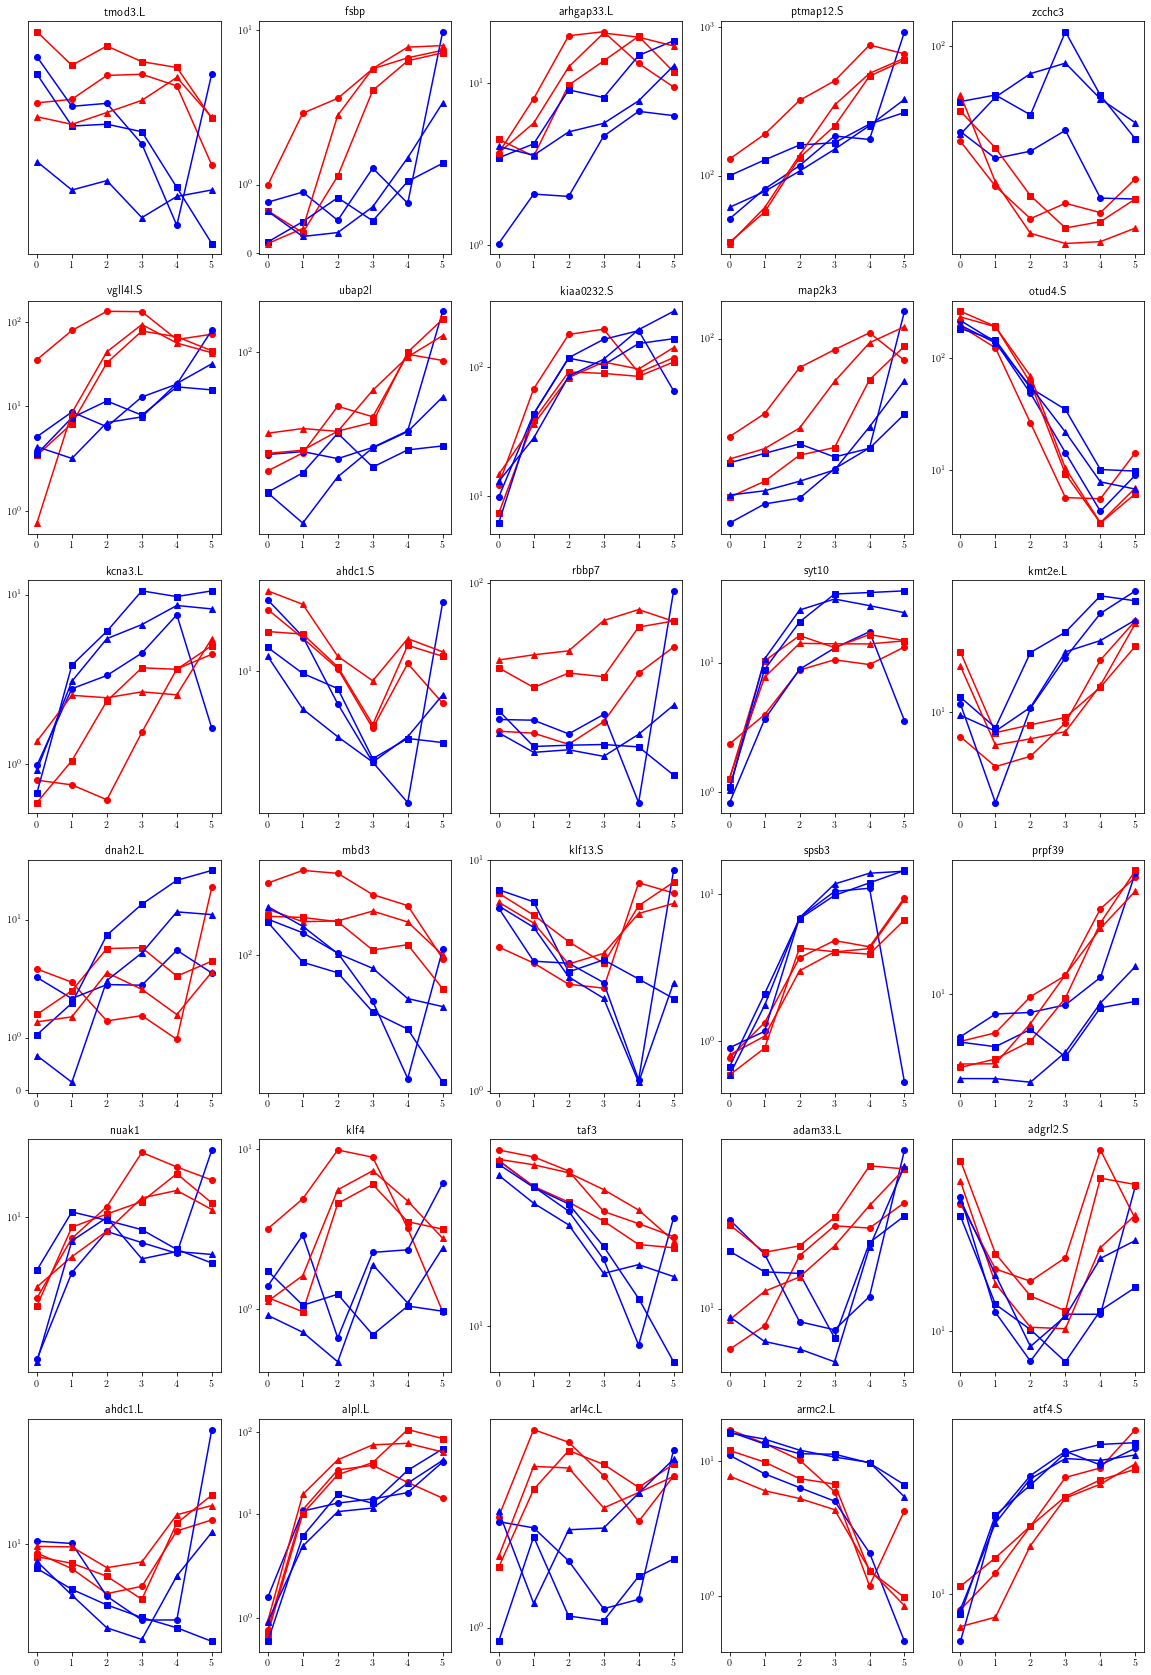

In [526]:
fig,axs=plt.subplots(6,5,figsize=(20,30))
marks = ['o','s','^']
cols = ['red','blue','goldenrod']
labs = ['epidermal','neural','endodermal']
for i in range(30):
    idx = cde_mid_exn[i]
    ax  = axs[int(i/5),i%5]
    ax.set_yscale('symlog')
    for rep in range(3):
        for cond in range(2):
    #         axs[int(i/5),i%5].plot(range(6),gtpmMu[cond*6:(cond+1)*6,idx],
    #                                marker=marks[rep],color=cols[cond])
    
            ax.plot(range(6),gtpm[cond,rep,:,idx],
                                    marker=marks[rep],color=cols[cond])
            ax.set_title(gnmsS[idx])

In [455]:
condVs

[('epid', 'noggin'), ('epid', 'endo'), ('noggin', 'endo')]

In [464]:
id3gnms = gnmsS[cde_mid_exn]
id3pvs  = np.nanmin(cDEpvs2[cidx,1:-1,cde_mid_exn],axis=1)
np.savetxt('{0}/id3_like_genes_neur_endo.csv'.format(datdir),
           np.array([id3gnms,id3pvs]).T,fmt='%s',delimiter='\t')

In [951]:
# analyzing the cde_mid_exns for trends...
thresh = 1e-4
firstDEidx = [np.argmax(cDEpvs[i,1:-1,cde_mid_exns[i]]<thresh,axis=1) 
              for i in range(cDEpvs.shape[0])] # returns the first index that the pvalue < thresh
firstDEidxGrps = [[cde_mid_exns[i][np.where(firstDEidx[i] == j)[0]] for j in range(4)] 
                  for i in range(cDEpvs.shape[0])]


/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [915]:
gnmsS[firstDEidxGrps[0][0]],firstDEidxGrps[0][0]

(array(['LOC100126627', 'cyp46a1.3.L'], dtype='<U23'), array([69, 72]))

In [914]:
gtpm.shape,gtpmMu.shape

((3, 3, 6, 45660), (18, 45660))

In [954]:
gnmsS[firstDEidxGrps[0][0]]

array(['insm1.S', 'jun.L'], dtype='<U23')

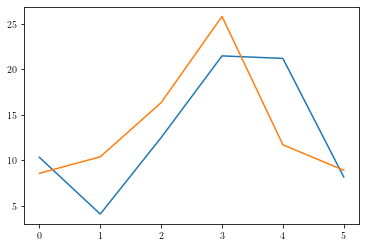

In [953]:
fig,axs=plt.subplots()
axs.plot(range(6),gtpmMu[0:6,33807])
axs.plot(range(6),gtpmMu[6:12,33807])

In [ ]:
keggidxsnull['transcription factors']

In [ ]:
keggidxsnull['FoxO sig']

In [960]:
pways = ['BMP','TGF-beta','MAPK','Notch','Wnt','Hedgehog','VEGF','FoxO']
addons = ['',' TF',' non TF']
grps = [['{0} signaling pathway{1}'.format(pw,addon) for pw in pways] for addon in addons]
cidx = 2
pvs = np.array([[[hgpv(firstDEidxGrps[cidx][i],grps[j][k]) 
                  for j in range(len(grps))] 
                 for k in range(len(grps[j]))] 
                for i in range(4)])

tfpvs = np.array([hgpv(firstDEidxGrps[cidx][i],'transcription factors') for i in range(4)])


# pvs = np.array([[[hgpv(cde_mid_exns[i],grps[j][k]) 
#                   for j in range(len(grps))] 
#                  for k in range(len(grps[j]))] 
#                 for i in range(len(cde_mid_exns))])

# tfpvs = np.array([hgpv(cde_mid_exns[i],'transcription factors') for i in range(len(cde_mid_exns))])

# pvs = np.array([[hgpv(cde_mid_exns[i],grp) for grp in grps] 
#                 for i in range(len(cde_mid_exns))])

eps = 10**-12
logpvs = -np.log10(pvs+eps)
logtfpvs = -np.log10(tfpvs+eps)

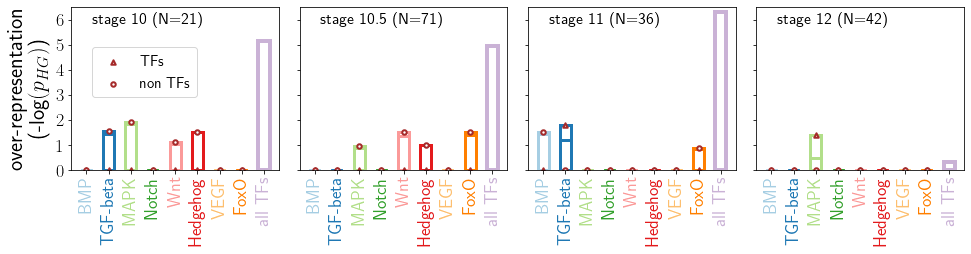

In [962]:
nc = logpvs.shape[0]
cols = matplotlib.colors.to_rgba_array(plt.cm.Paired.colors)
fig,axs=plt.subplots(1,nc,figsize=(4*nc,3))
labs = pways + ['all TFs'] #['BMP','TGFb','MAPK','TFs']
# grp_labels = ['epidermal v neural','epidermal v endodermal','neural v endodermal']
# grp_labels = ['{0}\nN={1}'.format(grp_labels[i],len(cde_mid_exns[i])) 
#              for i in range(len(grp_labels))]
grp_labels = ['stage 10','stage 10.5','stage 11', 'stage 12']
grp_labels = ['{0} (N={1})'.format(grp_labels[i],len(firstDEidxGrps[cidx][i])) 
             for i in range(len(grp_labels))]


lss = ['solid','dotted','dashed']
pms = ['o','^','o']
plabs = ['all','TFs','non TFs']
for i in range(nc):
    for j in range(logpvs.shape[2]):
        axs[i].bar(np.arange(len(pways)),logpvs[i,:,j],width=0.5, edgecolor=cols, 
                   ls = lss[0], lw=3, fc=(1,1,1,0))
        if j > 0:
            axs[i].scatter(np.arange(len(pways)),logpvs[i,:,j],s=20,marker=pms[j],
                           label=plabs[j],edgecolor='brown',c='white',linewidth=2,zorder=2) #c=cols[0:len(pways)],)
    
    axs[i].bar(len(labs)-1,logtfpvs[i],width=0.5, edgecolor=cols[len(labs)-1], lw=4,fc=(1,1,1,0))
    
    axs[i].set_xticks(range(len(labs)))
    axs[i].set_xticklabels(labs,rotation=90)
    axs[i].set_ylim(0,np.max([np.max(logpvs),np.max(logtfpvs)])+0.2) #12.5)
    #[i.set_color(cols[]) for i in plt.gca().get_xticklabels()]
    [t.set_color(c) for (c,t) in zip(cols[0:len(labs)],axs[i].xaxis.get_ticklabels())]
    if i > 0:
        axs[i].set_yticklabels([])
#axs[0].set_yticklabels(range(0,14,2))
    
    axs[i].text(x=0.1,y=0.9,s=grp_labels[i],transform=axs[i].transAxes,fontsize=16)
    mf.set_axs_fontsize(axs[i],18)
    
axs[0].set_ylabel('over-representation\n(-log$(p_{HG})$)',fontsize=22)
axs[0].legend(loc=(0.1,0.45),fontsize=15)
plt.subplots_adjust(wspace=0.1)
plt.savefig('{0}/phg_dyn_genes_{1}.jpg'.format(plotdir,'_'.join(condVs[cidx]),addon.replace(' ','_')),bbox_inches="tight")
#plt.savefig('{0}/phg_dyn_genes_all_conds.jpg'.format(plotdir,'_'.join(condVs[cidx]),addon.replace(' ','_')),bbox_inches="tight")

#              color=cols[i%3], hatch=hatches[int(i/3)],#edgecolor='white',
#              label=barlabs[i] if labs[i] else None)

In [650]:
[list(map(len,grps)) for grps in firstDEidxGrps]

[[2, 18, 45, 77], [9, 17, 19, 18], [21, 71, 36, 42]]

In [446]:
np.array([id3gnms,id3pvs]).T.shape

(142, 2)

In [330]:
cDEpvs2[0,:,33557:33559]

array([[9.61842492e-01, 9.75018848e-01],
       [1.01897099e-02, 3.25762091e-02],
       [1.31633647e-59, 1.19515128e-77],
       [3.44680482e-38, 1.25749707e-78],
       [1.22839734e-23, 6.10012104e-40],
       [6.85254608e-01, 5.27332492e-01]])

In [319]:
cde_mid_ex_stg = [np.intersect1d(cde_mid_ex,clowpvidxs[0][i]) for i in range(1,5)]
np.setdiff1d

In [586]:
threshHi = 0.5
threshLow = 0.05
low_cpvidxs = [[lowIdxs(cDEpvs2[i,j],threshLow) for j in range(cDEpvs2.shape[1])] 
              for i in range(cDEpvs2.shape[0])]
hi_cpvidxs = [[hiIdxs(cDEpvs2[i,j],threshHi) for j in range(cDEpvs2.shape[1])] 
             for i in range(cDEpvs2.shape[0])]

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [587]:
# any that work with all three conditional variations?
cdeidxs_mid   = reduce(np.intersect1d, 
                       [np.array(reduce(np.union1d,low_cpvidxs[cidx][1:-1])) 
                        for cidx in range(len(low_cpvidxs))]
                      )

cndeidxs_ends = reduce(np.intersect1d,
                       [hi_cpvidxs[cidx][i] 
                        for cidx in range(len(hi_cpvidxs)) for i in [0,-1]]
                      )

cde_mid_ex    = np.intersect1d(cdeidxs_mid,cndeidxs_ends)
cde_mid_exn   = np.setdiff1d(cde_mid_ex,unannotatedIdxs)

In [588]:
len(cde_mid_ex)

8

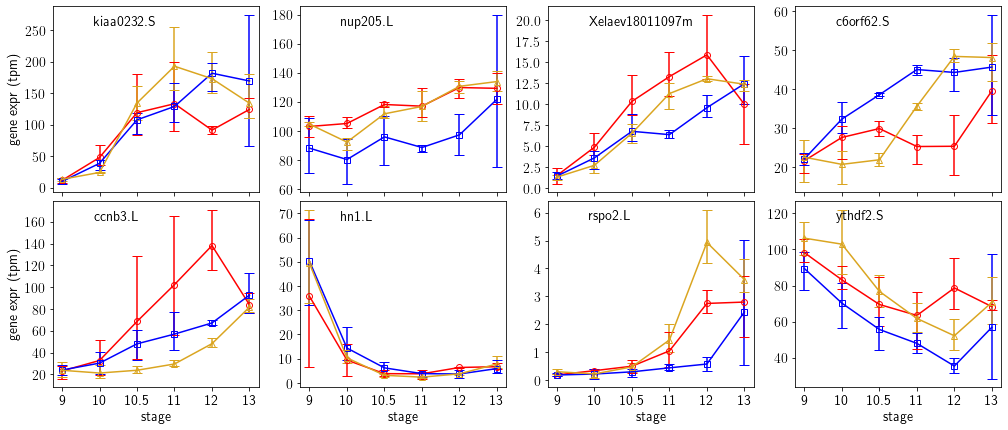

In [594]:
fig,axs=plt.subplots(2,4,figsize=(17,7))
marks = ['o','s','^']
cols = ['red','blue','goldenrod']
labs = ['epidermal','neural','endodermal']
#condranges = np.split(np.arange(18),3)
for i in range(len(cde_mid_ex)):
    idx = cde_mid_ex[i]
    #idx = cde_mid_exn[cde_mid_exn_lopval_sort[i]]
    ax  = axs[int(i/4),i%4]
    #ax.set_yscale('symlog')
    
    for cond in range(3):
        #ax.plot(range(6),gtpmMu[condranges[cond],idx],marker=marks[cond],color=cols[cond])
        ax.errorbar(range(6),gtpmMuS[cond,:,idx],yerr=loUpErrs[:,cond,:,idx],
            color=cols[cond],marker=marks[cond],capsize=5, label=labs[cond], fillstyle='none')
    
    ax.text(x=0.2,y=0.9,s=gnmsS[idx],fontsize=14,transform=ax.transAxes)
    ax.set_xticks(range(6))
    if i>3:
        ax.set_xticklabels(stagestrs)
        ax.set_xlabel('stage')
    else:
        ax.set_xticklabels([])
        #
    if i%4==0:
        ax.set_ylabel('gene expr (tpm)')
        
    mf.set_axs_fontsize(ax,14)
    
plt.subplots_adjust(hspace = 0.05)
plt.savefig('{0}/id3_like_all_conds.jpg'.format(plotdir,'_'.join(condVs[cidx])),bbox_inches="tight")

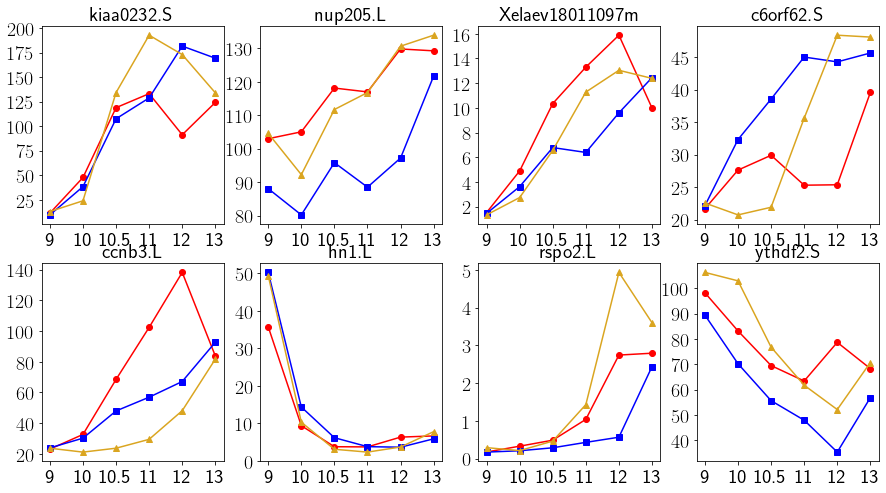

In [499]:
ncol = 4
fig,axs=plt.subplots(2,ncol,figsize=(15,8))
marks = ['o','s','^']
cols = ['red','blue','goldenrod']
labs = ['epidermal','neural','endodermal']
for i in range(8):
    idx = cde_mid_ex[i]
    ax  = axs[int(i/ncol),i%ncol]
    #ax.set_yscale('symlog')
    
    for cond in range(3):
        ax.plot(range(6),gtpmMu[cond*6:(cond+1)*6,idx],marker=marks[cond],color=cols[cond])          
        ax.set_title(gnmsS[idx])
    
    ax.set_xticks(range(6))
    ax.set_xticklabels(stagestrs)
    mf.set_axs_fontsize(ax,20)

In [478]:
f = [reduce(np.union1d,low_cpvidxs[cidx][1:-1]) for cidx in range(len(low_cpvidxs))]

In [479]:
len(f[0])

8560

In [521]:
cde_mid_exns_u = reduce(np.union1d, cde_mid_exns)

id3gnms = gnmsS[cde_mid_exns_u]
id3lopvs  = np.nanmin(cDEpvs2[:,1:-1,cde_mid_exns_u],axis=1)
id3hipvs  = np.min(cDEpvs2[:,[[0],[-1]],cde_mid_exns_u],axis=1)
np.savetxt('{0}/id3_like_genes_all_conds.csv'.format(datdir),
           np.array(np.vstack([id3gnms,id3lopvs,id3hipvs])).T,fmt='%s',delimiter='\t')

In [507]:
cDEpvs2.shape

(3, 6, 45660)

In [508]:
np.nanmin(cDEpvs2[:,1:-1,cde_mid_exn],axis=1).shape

(3, 170)

In [509]:
reduce(np.union1d, cde_mid_exns).shape

(358,)

In [516]:
id3hipvs  = np.max(cDEpvs2[:,[[0],[-1]],cde_mid_exns_u],axis=1)

In [514]:
id3hipvs.shape

(3, 358)

In [515]:
cDEpvs2[:,[[0],[-1]],cde_mid_exns_u].shape

(3, 2, 358)

In [519]:
np.where(gnmsS=='prkcd')

(array([1136]),)

In [520]:
cDEpvs2[:,:,1136]

array([[6.91790157e-01, 5.61859095e-02, 1.50298542e-03, 4.91629416e-05,
        1.23363356e-07, 3.28141619e-03],
       [7.08463114e-01, 8.51557765e-06, 2.15510819e-11, 8.21653873e-12,
        6.11141447e-06, 1.12047654e-04],
       [8.95158782e-01, 6.28969686e-02, 2.27282568e-06, 1.36237872e-05,
        4.57472681e-01, 6.34247207e-01]])

In [596]:
gtpm.shape,gtpmMuS.shape

((3, 3, 6, 45660), (3, 6, 45660))

In [597]:
maxindex = np.argmax(gtpmMuS,axis=1)

In [598]:
maxindex.shape

(3, 45660)

In [610]:
tiny13idxs = np.where(gtpmMuS[1,-1]<0.5)[0]

In [624]:
st13NpkIdxs = np.setdiff1d(np.where(maxindex[1]==5)[0],np.union1d(unannotatedIdxs,tiny13idxs))
st13EpkIdxs = np.union1d(np.where(maxindex[0]==5)[0], np.where(maxindex[2]==5)[0])
st13NOnlyIdxs = np.setdiff1d(st13NpkIdxs,st13EpkIdxs)

In [91]:
# fig,axs=plt.subplots(1,1)
# axs.plot(range(6),gtpmMuS[1,:,st13pksIdxs[0]],'o-')

In [625]:
cDEpvs[0].shape,st13pksIdxs.shape,st13NOnlyIdxs.shape

((6, 45660), (4984,), (1394,))

In [604]:
tDEpvs.shape

(3, 5, 45660)

In [626]:
idxs = st13NOnlyIdxs
nms  = gnmsS[idxs]
tpvs = tDEpvs[1,-1,idxs]
cpvs1 = cDEpvs[0,-1,idxs]
cpvs2 = cDEpvs[2,-1,idxs]

np.savetxt('{0}/stage13_neural_only_peaking_genes.csv'.format(datdir),
           np.array([nms,tpvs,cpvs1,cpvs2]).T,fmt='%s',delimiter='\t')

In [627]:
neurlo10idxs = np.setdiff1d(np.where(tDEpvs2[1,1]<0.05)[0],unannotatedIdxs)

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [628]:
len(neurlo10idxs)

2926

In [630]:
idxs = neurlo10idxs
nms  = gnmsS[idxs]
tpvs = tDEpvs[1,1,idxs]
cpvs1a = cDEpvs[0,1,idxs]
cpvs1b = cDEpvs[0,2,idxs]
cpvs2a = cDEpvs[2,1,idxs]
cpvs2b = cDEpvs[2,2,idxs]

np.savetxt('{0}/stage10-105_neural_deseq_genes.csv'.format(datdir),
           np.array([nms,tpvs,cpvs1a,cpvs1b,cpvs2a,cpvs2b]).T,fmt='%s',delimiter='\t')

In [942]:
tDEpvs2[[0,1]].shape

(2, 5, 45660)

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
threshs = [1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,0.1]

#cidxs    = [0,1,2]
cidxs   = [[0,1],[0,2],[1,2]]

deIdxGrps      = [[],[],[]]
firstDEidxGrps = [[],[],[]]
for cidx in range(3):
    for thresh in threshs:
        lowPVtGenes    = np.unique(np.where(tDEpvs2[cidxs[cidx]]<thresh)[2])
        lowPVcGenes    = np.unique(np.where(cDEpvs2[cidx]<thresh)[1])
        lowPVtcGenes   = np.setdiff1d(np.intersect1d(lowPVtGenes,lowPVcGenes),
                                      unannotatedIdxs)

        isDEidx        = cDEpvs[cidx,:,lowPVtcGenes]<thresh
        deIdxGrp       = [lowPVtcGenes[np.where(isDEidx[:,j])[0]] for j in range(6)]

        firstDEidx     = np.argmax(isDEidx,axis=1) 
        firstDEidxGrp  = [lowPVtcGenes[np.where(firstDEidx == j)[0]] for j in range(6)] 

        deIdxGrps[cidx].append(deIdxGrp)
        firstDEidxGrps[cidx].append(firstDEidxGrp)

#lowPVtcGenes.shape

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [1012]:
#list(map(len,deIdxGrps)),list(map(len,firstDEidxGrps))

([10, 24, 82, 191, 407, 268], [10, 21, 64, 129, 250, 123])

In [1032]:
#list(map(len,firstDEidxGrps))

In [1404]:
pways = ['TGF-beta original', 'BMP','TGF-beta','MAPK','Notch','Wnt','Hedgehog','VEGF']
addons = ['',' TF',' non TF']
pwaygrps = [['{0} signaling pathway{1}'.format(pw,addon) for pw in pways] for addon in addons]
#cidx = 2
idxgrps = [deIdxGrps, firstDEidxGrps]
pvs = np.array([[[[[[hgpv(idxgrps[i][c][th][t],pwaygrps[j][k])
                     for j in range(len(grps))]
                    for k in range(len(grps[j]))]
                   for t in range(len(stages))]
                  for th in range(len(threshs))]
                 for c in range(len(cidxs))]
                for i in range(len(idxgrps))])

tfpvs = np.array([[[[hgpv(idxgrps[i][c][th][t],'transcription factors') 
                     for t in range(len(stages))]
                    for th in range(len(threshs))]
                   for c in range(len(cidxs))]
                  for i in range(len(idxgrps))])
                                    
    

#logpvs   = -np.log10(pvs+eps)
#logtfpvs = -np.log10(tfpvs+eps)

In [1405]:
#logpvs.shape
pvsmu    = np.mean(pvs,axis=2)
pvserr   = np.std(pvs,axis=2)/np.sqrt(len(threshs))

tfpvsmu  = np.mean(tfpvs, axis=2)
tfpvserr = np.std(tfpvs, axis=2)/np.sqrt(len(threshs))

eps  = 10**-12
nlog = lambda x: -np.log10(x+eps)
logpvsmu  = nlog(pvsmu)
logpvserr = pvserr/((pvsmu+eps)*np.log(10)) # d*nlog(x)/dx * dx

In [1406]:
#logpvserr[0,0,:,pway_idx,:]

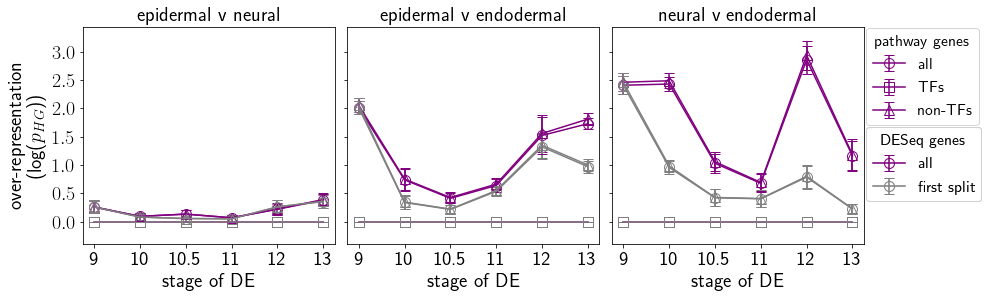

In [1415]:
fig,axs=plt.subplots(1,3,figsize=(14,4))
pms = ['o','s','^']
cols = ['purple','gray']
ilabs = ['all','TFs','non-TFs']
jlabs = ['all','first split']

clabs = ['epidermal v neural', 'epidermal v endodermal', 'neural v endodermal' ]
pway_idx = 7

for c in range(3):
    ax = axs[c]
    plts = []
    for i in range(3):
        for j in range(2):
            errplt = ax.errorbar(range(6),logpvsmu[j,c,:,pway_idx,i], 
                                  yerr=logpvserr[j,c,:,pway_idx,i], marker=pms[i], 
                                  fillstyle = 'none', markersize = 10, capsize = 5, 
                                  color=cols[j])
                    #label=labs[i] if j==0 else None)
            plts.append(errplt)
        
    ax.set_xticks(range(6))
    ax.set_xticklabels(stagestrs)
    ax.set_xlabel('stage of DE')
    ax.set_title(clabs[c])
    ax.set_ylim(-0.4,np.max(logpvsmu[:,:,:,pway_idx])+0.5)
    
    if c>0:
        ax.set_yticklabels([])
    
axs[0].set_ylabel('over-representation\n(log($p_{HG}$))')
#axs.set_title(pways[pway_idx])

for ax in axs:
    mf.set_axs_fontsize(ax,20,False)

#axs.legend(loc = (0.05,0.7))

legend1 = axs[2].legend(plts[0:6:2],ilabs, loc=(1.01,0.55), title="pathway genes", 
                     fontsize=16)
legend1.get_title().set_fontsize('16')
axs[2].add_artist(legend1)

legend2 = axs[2].legend(plts[0:2],jlabs, loc=(1.01,0.2), title="DESeq genes",
                     fontsize=16)
legend2.get_title().set_fontsize('16')
axs[2].add_artist(legend2)
plt.subplots_adjust(wspace=0.05)

plt.savefig('{0}/phg_split_genes_{1}.jpg'.format(plotdir,pways[pway_idx]),bbox_inches="tight")


In [1237]:
pvIdx           = -1
pwayIdx         = 0
pwygenes        = keggidxsnull[pways[pwayIdx]+' signaling pathway']
pwygenesPerTime = [[np.intersect1d(deIdxGrps[c][pvIdx][t],pwygenes) 
                    for t in range(6)] for c in range(len(cidxs))]

In [1238]:
#[gnmsS[pwygenesPerTime[i]] for i in range(6)]

In [1239]:
flatten3d = lambda x: [k for j in x for i in j for k in i]

In [1270]:
gidxs       = np.unique(np.array(flatten3d(pwygenesPerTime)))
# gidxPresent = np.array([np.in1d(gidxs, deIdxGrps[pvIdx][t]) 
#                         for t in range(6)],dtype='int')

gidxPVs     = cDEpvs2[:,:,gidxs] 
gidxPVsF    = gidxPVs.reshape(18,-1).T
nmsort      = np.argsort(gnmsS[gidxs])


sort2=nmsort

In [1298]:
gnmsTF = np.char.array(gnmsS)
gnmsTF[keggidxsnull['transcription factors']] = '*'+gnmsTF[keggidxsnull['transcription factors']]

In [1273]:
gidxs   = [np.unique(np.array(mf.flatten2d(pwygenesPerTime[i]))) for i in range(3)]
gidxPVs = [cDEpvs2[i,:,gidxs[i]] for i in range(3)] 

pvsorts = [np.argsort(np.argmax(gidxPVs[i] < threshs[pvIdx],axis=1)) for i in range(3)]

/Users/simonfreedman/opt/anaconda3/envs/ml3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [1393]:
#np.argmax(gidxPVs[i] < threshs[pvIdx],axis=1)

In [1394]:
#breaks = np.where(np.diff(np.argmax(pvs<thresh,axis=1))>0)[0]

In [1395]:
#np.argsort(gnmsTF[gidxs[firstLoPVgrps[0]]])

In [1441]:
#np.cumsum(breaks)
plt.ioff()

In [1465]:
pvIdx    = -1
pwayIdx  = 7
cidx     = 2

# get genes that are differentially expressed for pathway pwayIdx and conditional compare cidx
pwygenes        = keggidxsnull[pways[pwayIdx]+' signaling pathway']
pwygenesPerTime = [[np.intersect1d(deIdxGrps[c][pvIdx][t],pwygenes) 
                    for t in range(6)] for c in range(len(cidxs))]

gidxs   = np.unique(np.array(mf.flatten2d(pwygenesPerTime[cidx])))
gidxPVs = cDEpvs2[cidx,:,gidxs] 

# first sort -- by time when pvalue is first below threshold
firstLoPVidx  = np.argmax(gidxPVs < threshs[pvIdx],axis=1)
firstLoPVgrps = [np.where(firstLoPVidx==i)[0] for i in range(6)]

# second sort -- backwards alphabetically (puts TFs at the end bc they start with *)
nmsorts       = [np.flip(np.argsort(gnmsTF[gidxs[grp]])) for grp in firstLoPVgrps]
ttfsort       = mf.flatten2d([firstLoPVgrps[i][nmsorts[i]] for i in range(6)])

#tsort = pvsorts[cidx]
idxs  = gidxs[ttfsort]
pvs   = gidxPVs[ttfsort]


breaks = np.cumsum(list(map(len,firstLoPVgrps)))

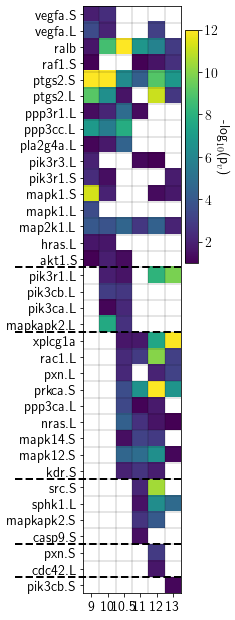

In [1466]:
fac = 1

fac=0.3

fig,axs=plt.subplots(1,1,figsize=(6*fac,len(idxs)*fac))
#axs.imshow(gidxPresent.T, cmap='binary')
cmap = plt.get_cmap('viridis')
cmap.set_under('white')  # Color for values less than vmin


im = axs.imshow(nlog(pvs),vmin=1,vmax = 12, aspect=1)
axs.set_yticks(np.arange(len(idxs)))
axs.set_ylim(len(idxs)-0.5,-0.5)
axs.set_yticklabels(gnmsTF[idxs])

axs.set_xticks(np.arange(6))
axs.set_xticklabels(stagestrs)

#axs.vlines(x=[5.5,11.5],ymin=-1,ymax=len(gidxs),lw=6,color='black')
axs.vlines(x=np.arange(0.5,5.5,1),ymin=-1,ymax=len(idxs),lw=0.2,color='black')
axs.hlines(y=np.arange(0.5,len(idxs)-0.5,1),xmin=-0.5,xmax=5.5,lw=0.2,color='black')
#axs.hlines(y=breaks+0.5,xmin=-2,xmax=5.5,lw=1,color='black',linestyle='dashed',clip_on=False)
for i in breaks[:-1]:
    axs.axhline(y=i-0.5,xmin=-0.7,xmax=1,color='black',clip_on=False,linewidth=2,linestyle='dashed')

#[t.set_color(c) for (c,t) in zip(cols[0:len(labs)],axs[i].xaxis.get_ticklabels())]
#colorbar
divider = make_axes_locatable(axs)
cax2 = fig.add_axes([0.92, 0.55, 0.1, 0.3])

#cax2     = divider.append_axes("right", size=0.1, pad=0.05)

cbar = fig.colorbar(im, cax=cax2)
cbar.set_label('-log$_{10}$(p$_v$)',rotation=270, labelpad=10)
cax2.xaxis.set_label_position('top')
#mf.set_axs_fontsize(cax2,20)

mf.set_axs_fontsize(axs,14)
mf.set_axs_fontsize(cax2,14)


plt.savefig('{0}/gnm_pval_split_genes_{1}_{2}.jpg'.format(plotdir, 
                                                           pways[pwayIdx], '_'.join(condVs[cidx]))
                                                           ,bbox_inches="tight")

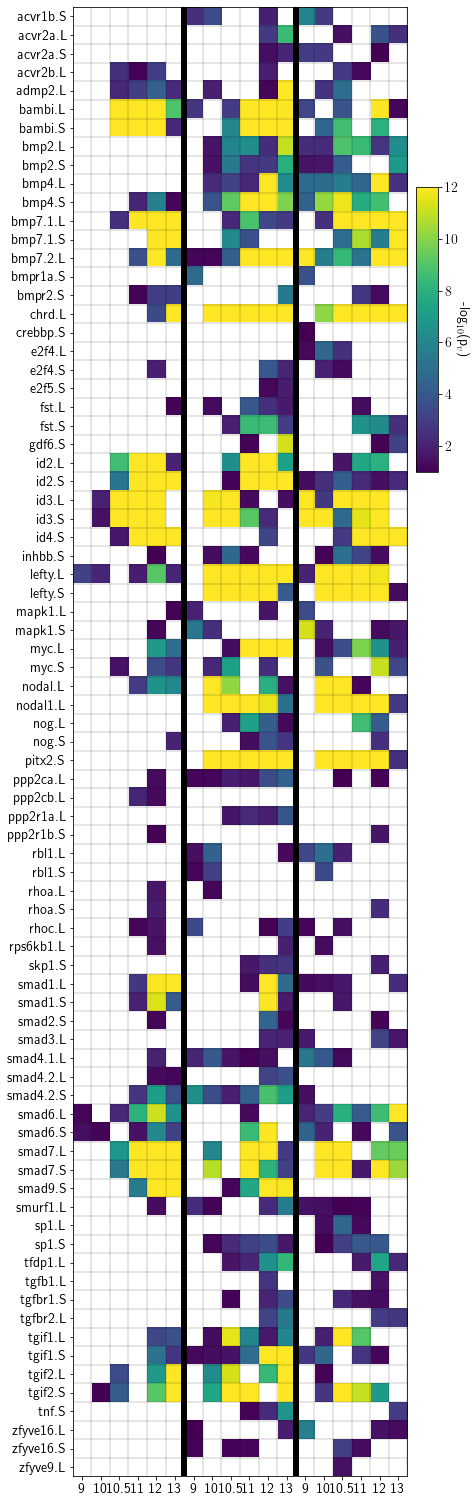

In [1272]:
fac = 1
fig,axs=plt.subplots(figsize=(6*fac,len(gidxs)*fac))
#axs.imshow(gidxPresent.T, cmap='binary')
cmap = plt.get_cmap('viridis')
cmap.set_under('white')  # Color for values less than vmin

im = axs.imshow(nlog(gidxPVsF[sort2]),vmin=1,vmax = 12, aspect=1)
axs.set_yticks(np.arange(len(gidxs)))
axs.set_ylim(len(gidxs)-0.5,-0.5)
axs.set_yticklabels(gnmsS[gidxs[sort2]])

axs.set_xticks(np.arange(18))
axs.set_xticklabels(stagestrs*3)

axs.vlines(x=[5.5,11.5],ymin=-1,ymax=len(gidxs),lw=6,color='black')
axs.vlines(x=np.arange(0.5,18.5,1),ymin=-1,ymax=len(gidxs),lw=0.2,color='black')
axs.hlines(y=np.arange(0.5,len(gidxs)-0.5,1),xmin=-0.5,xmax=17.5,lw=0.2,color='black')
#colorbar
divider = make_axes_locatable(axs)
cax2 = fig.add_axes([0.92, 0.55, 0.05, 0.05])

#cax2     = divider.append_axes("right", size=0.1, pad=0.05)

cbar = fig.colorbar(im, cax=cax2)
cbar.set_label('-log$_{10}$(p$_v$)',rotation=270, labelpad=10)
cax2.xaxis.set_label_position('top')
#mf.set_axs_fontsize(cax2,20)

mf.set_axs_fontsize(axs,14)
mf.set_axs_fontsize(cax2,14)


plt.savefig('{0}/gnm_pval_split_genes_{1}.jpg'.format(plotdir,pways[pway_idx]),bbox_inches="tight")

In [ ]:
fig,axs=plt.subplots(1,1,figsize=(12*fac,len(idxs)*fac))
datS   = dat[:,idxs].T+0.5
im = axs.imshow(datS,aspect='auto',norm=matplotlib.colors.LogNorm())
axs.vlines(x=5.5,ymin=-0.5,ymax=len(idxs)-0.5)

# breaks = np.cumsum(glens)
# for br in breaks[:-1]:
#     axs.hlines(y=br-0.5,xmin=-0.5,xmax=11.5,linestyle='dashed')

for idx in isDeIdxs:
    cidx,ridx = idx
    if datS[ridx,cidx] < datS[ridx,cidx+1]:
        axs.text(s=r'$\boldsymbol{+}$',x=cidx+0.18,y=ridx+0.25,color='white',size=13)#for jpg export
        #axs.text(s=r'$\boldsymbol{+}$',x=cidx+0.25,y=ridx+0.2,color='white',size=13) #for pdf export
    else:
        axs.text(s='-',x=cidx+0.35,y=ridx+0.1,color='white',size='30') #for jpg export
        #axs.text(s='-',x=cidx+0.35,y=ridx+0.45,color='white',size='30') #for pdf export

    #axs.text(s='.',x=idx[1]+0.4,y=idx[0]+0.1,color='white',size='40')
    
axs.set_yticks(range(len(idxs)))
axs.set_yticklabels(gnames)

axs.set_xticks(range(len(stages)*3))
axs.set_xlabel('stage')

divider = make_axes_locatable(axs)
cax2     = divider.append_axes("top", size=0.1, pad=0.05)

cbar = fig.colorbar(im, cax=cax2,orientation='horizontal')
cbar.set_label('expr (tpm)',rotation=0, labelpad=2)
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_ticks_position('top')

axs.text(s='epidermal',y=len(idxs)+1.5,x=0.5,color='red',size=16)
axs.text(s='neural',y=len(idxs)+1.5,x=8,color='blue',size=16)


mf.set_axs_fontsize(axs,16)
mf.set_axs_fontsize(cax2,16)
axs.set_xticklabels(stagestrs*2,fontsize=12)

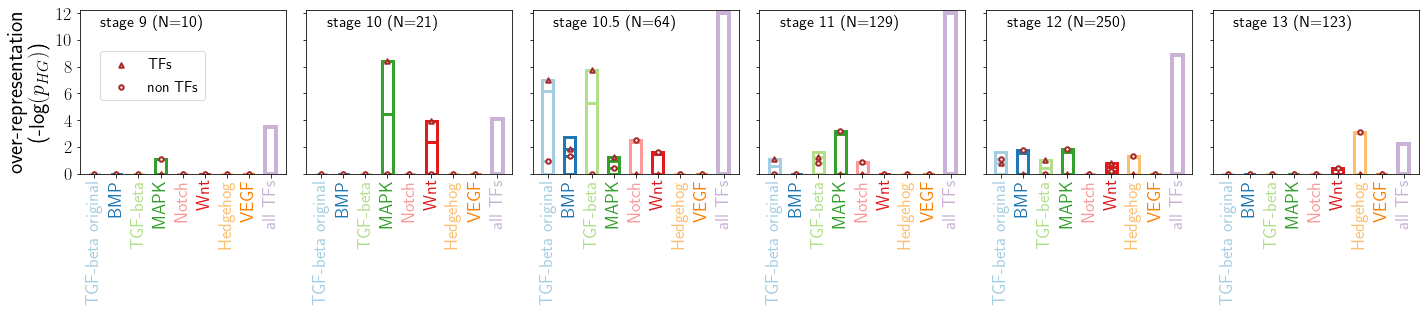

In [1019]:
nc = logpvs.shape[1]
cols = matplotlib.colors.to_rgba_array(plt.cm.Paired.colors)
fig,axs=plt.subplots(1,nc,figsize=(4*nc,3))
labs = pways + ['all TFs'] 
grp_labels = ['stage 9','stage 10','stage 10.5','stage 11', 'stage 12', 'stage 13']
grp_labels = ['{0} (N={1})'.format(grp_labels[i],len(firstDEidxGrps[i])) 
             for i in range(len(grp_labels))]

pms = ['o','^','o']
plabs = ['all','TFs','non TFs']

for i in range(nc):
    for j in range(logpvs[1].shape[2]):
        axs[i].bar(np.arange(len(pways)),logpvs[1,i,:,j],width=0.5, edgecolor=cols, 
                   ls = lss[0], lw=3, fc=(1,1,1,0))
        if j > 0:
            axs[i].scatter(np.arange(len(pways)),logpvs[1,i,:,j],s=20,marker=pms[j],
                           label=plabs[j],edgecolor='brown',c='white',linewidth=2,zorder=2) #c=cols[0:len(pways)],)
    
    axs[i].bar(len(labs)-1,logtfpvs[1,i],width=0.5, edgecolor=cols[len(labs)-1], lw=4,fc=(1,1,1,0))
    
    axs[i].set_xticks(range(len(labs)))
    axs[i].set_xticklabels(labs,rotation=90)
    axs[i].set_ylim(0,np.max([np.max(logpvs[1]),np.max(logtfpvs[1])])+0.2) #12.5)
    #[i.set_color(cols[]) for i in plt.gca().get_xticklabels()]
    [t.set_color(c) for (c,t) in zip(cols[0:len(labs)],axs[i].xaxis.get_ticklabels())]
    if i > 0:
        axs[i].set_yticklabels([])
#axs[0].set_yticklabels(range(0,14,2))
    
    axs[i].text(x=0.1,y=0.9,s=grp_labels[i],transform=axs[i].transAxes,fontsize=16)
    mf.set_axs_fontsize(axs[i],18)
    
    
axs[0].set_ylabel('over-representation\n(-log$(p_{HG})$)',fontsize=22)
axs[0].legend(loc=(0.1,0.45),fontsize=15)
plt.subplots_adjust(wspace=0.1)
#plt.savefig('{0}/phg_dyn_genes_{1}.jpg'.format(plotdir,'_'.join(condVs[cidx]),addon.replace(' ','_')),bbox_inches="tight")
#plt.savefig('{0}/phg_dyn_genes_all_conds.jpg'.format(plotdir,'_'.join(condVs[cidx]),addon.replace(' ','_')),bbox_inches="tight")


In [946]:
splitIdx = np.argmin(cDEpvs2[0],axis=0)

In [947]:
idxGrps = [np.where(splitIdx==i) for i in range(len(stgs))]

IndexError: index 5206 is out of bounds for axis 0 with size 5205

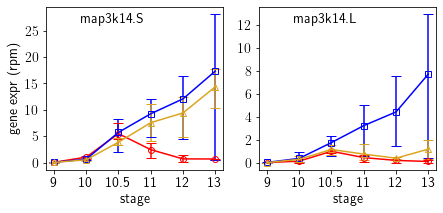

In [1507]:
# plot both s and l

fig,axs=plt.subplots(1,2,figsize=(7,3))
marks = ['o','s','^']
cols = ['red','blue','goldenrod']
labs = ['epidermal','neural','endodermal']
#condranges = np.split(np.arange(18),3)
nm = 'map3k14'
idxs = [np.where(gnmsS=='{0}.{1}'.format(nm,al))[0][0] for al in ['S','L']]

for i in range(len(idxs)):
    for cond in range(3):
        axs[i].errorbar(range(6),gtpmMuS[cond,:,idxs[i]],yerr=loUpErrs[:,cond,:,idxs[i]],
            color=cols[cond],marker=marks[cond],capsize=5, label=labs[cond], fillstyle='none')

    axs[i].text(x=0.2,y=0.9,s=gnmsS[idxs[i]],fontsize=14,transform=axs[i].transAxes)
    axs[i].set_xticks(range(6))
    axs[i].set_xticklabels(stagestrs)
    axs[i].set_xlabel('stage')
    mf.set_axs_fontsize(axs[i],14)

axs[0].set_ylabel('gene expr (rpm)')

    
plt.subplots_adjust(hspace = 0.05)
plt.savefig('{0}/{1}_mu_max_min.jpg'.format(plotdir,nm),bbox_inches="tight")

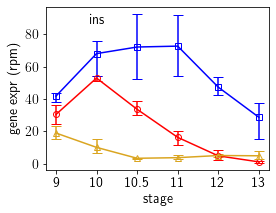

In [1502]:
fig,axs=plt.subplots(1,1,figsize=(4,3))
marks = ['o','s','^']
cols = ['red','blue','goldenrod']
labs = ['epidermal','neural','endodermal']
#condranges = np.split(np.arange(18),3)
nm = 'ins'
idx = np.where(gnmsS==nm)[0][0]

for cond in range(3):
    axs.errorbar(range(6),gtpmMuS[cond,:,idx],yerr=loUpErrs[:,cond,:,idx],
        color=cols[cond],marker=marks[cond],capsize=5, label=labs[cond], fillstyle='none')

axs.text(x=0.2,y=0.9,s=gnmsS[idx],fontsize=14,transform=axs.transAxes)
axs.set_xticks(range(6))
axs.set_xticklabels(stagestrs)
axs.set_xlabel('stage')
mf.set_axs_fontsize(axs,14)

axs.set_ylabel('gene expr (rpm)')

    
plt.subplots_adjust(hspace = 0.05)
plt.savefig('{0}/{1}_mu_max_min.jpg'.format(plotdir,nm),bbox_inches="tight")

In [226]:
np.nanmin(tDEpvs2,axis=(0,1)).shape

(45660,)

In [335]:
# genes that are dynamic, but not conditionally variant:
thresh = 0.1

tDEpvsMinT     = np.nanmin(tDEpvs2,axis=1)
tDEpvsMinTC    = np.nanmin(tDEpvsMinT,axis=0)
tDEpvsMaxTC    = np.nanmax(tDEpvsMinT,axis=0)
lowPVtGenesAny = np.where(tDEpvsMinTC<thresh)[0]
lowPVtGenesAll = np.where(tDEpvsMaxTC<thresh)[0]


cDEpvsMin      = np.nanmin(cDEpvs2,axis=(0,1))
lowPVcGenesAny = np.where(cDEpvsMin < thresh)[0]

sameDynamicsIdxs  = np.setdiff1d(lowPVtGenesAny,lowPVcGenesAny)
sameDynamicsIdxsN = np.setdiff1d(sameDynamicsIdxs,unannotatedIdxs)



In [286]:
sameDynamicsIdxs.shape

(251,)

In [104]:
gnmsS[sameDynamicsIdxsN[0:10]]

array(['ifngr2', 'hira.L', 'sf3a2.L', 'btg5.1.L', 'galnt11.L', 'csf1r',
       'rnf125.S', 'sulf1.S', 'eloc', 'ppp1r16a'], dtype='<U23')

In [26]:
# plsr
from sklearn.cross_decomposition import PLSRegression as plsr

In [34]:
pls2 = plsr(n_components=1)
X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [2.,5.,4.]]
Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]
pls2.fit(X, Y)
Y_pred = pls2.predict(X)

In [37]:
gtpmf.shape

(54, 45660)

In [57]:
#X = gtpmf
ts = np.array(mf.flatten2d([list(range(6))]*9))
cE = np.array([1,0,0])
cN = np.array([0,1,0])
cD = np.array([0,0,1])
cs = np.vstack([np.outer(np.ones(18),cC) for cC in [cE,cN,cD]])
y = np.hstack([np.array([ts]).T,cs])

In [85]:
pls2 = plsr(n_components=2)
pls2.fit(gtpmf,y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

In [86]:
Y_pred = pls2.predict(gtpmf)

In [395]:
tDEpvs2.shape

(3, 5, 45660)

In [87]:
hgpv(tDEpvs2[0])

(array([ 4,  5, 10, 11, 11, 16, 16, 17, 17, 18, 19, 19, 19, 20, 20, 20, 21,
        21, 22, 23, 24, 25, 25, 26, 26, 27, 27, 28, 29, 30, 30, 31, 31, 32,
        32, 33, 34, 35, 42, 43, 48]),
 array([2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 0,
        2, 1, 2, 1, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0]))